In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(font_scale=2)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Sequential

import torch_geometric
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import torch_geometric.transforms as T
import torch_cluster

from torch_geometric.nn import NNConv, GCNConv, GraphConv
from torch_geometric.nn import PointConv, EdgeConv, SplineConv

from sklearn.cluster import DBSCAN

In [2]:
torch.cuda.device_count()

4

In [3]:
#device = torch.device('cuda:0')
device = torch.device('cuda:0')

In [4]:
#!pip install --upgrade --force-reinstall torch-sparse && pip install --upgrade --force-reinstall torch-cluster && pip install --upgrade --force-reinstall torch-scatter && pip install --upgrade --force-reinstall torch-spline_conv && pip install --upgrade --force-reinstall torch-geometric

## Download train data

In [5]:
showers_train = torch.load('./data/showers_train.pt')

In [6]:
showers_train = [shower.to(device) for shower in showers_train[:20]]

## Features creation

In [7]:
for i in range(len(showers_train)):
    data = showers_train[i].x
    
    shape_0 = data.shape[0]
    
    #azimuthal_angle
    feat_0 = torch.atan(data[:, 1]/data[:, 0]).view(shape_0,1)
    
    feat_1 = (torch.sqrt(torch.pow(data[:, 1], 2) + torch.pow(data[:, 0],2))
              /data[:, 2]).view(shape_0,1)
    
    feat_2 = (data[:, 0]/data[:, 2]).view(shape_0,1)
    
    feat_3 = (data[:, 1]/data[:, 2]).view(shape_0,1)
    
    showers_train[i].x = torch.cat((data, feat_0, feat_1, feat_2, feat_3), 1)

In [8]:
showers_train[0].x.shape

torch.Size([8816, 9])

## Checking weather edges connect hits from the same shower

We need to compare Z-coordinates of each brick layer with our data Z-coordinate

In [9]:
Z = np.array([     0.,   1293.,   2586.,   3879.,   5172.,   6465.,   7758.,
                          9051.,  10344.,  11637.,  12930.,  14223.,  15516.,  16809.,
                         18102.,  19395.,  20688.,  21981.,  23274.,  24567.,  25860.,
                         27153.,  28446.,  29739.,  31032.,  32325.,  33618.,  34911.,
                         36204.,  37497.,  38790.,  40083.,  41376.,  42669.,  43962.,
                         45255.,  46548.,  47841.,  49134.,  50427.,  51720.,  53013.,
                         54306.,  55599.,  56892.,  58185.,  59478.,  60771.,  62064.,
                         63357.,  64650.,  65943.,  67236.,  68529.,  69822.,  71115.,
                         72408.,  73701.])

In [10]:
Z_centered = Z - 73701. / 2

In [11]:
Z_centered

array([-36850.5, -35557.5, -34264.5, -32971.5, -31678.5, -30385.5,
       -29092.5, -27799.5, -26506.5, -25213.5, -23920.5, -22627.5,
       -21334.5, -20041.5, -18748.5, -17455.5, -16162.5, -14869.5,
       -13576.5, -12283.5, -10990.5,  -9697.5,  -8404.5,  -7111.5,
        -5818.5,  -4525.5,  -3232.5,  -1939.5,   -646.5,    646.5,
         1939.5,   3232.5,   4525.5,   5818.5,   7111.5,   8404.5,
         9697.5,  10990.5,  12283.5,  13576.5,  14869.5,  16162.5,
        17455.5,  18748.5,  20041.5,  21334.5,  22627.5,  23920.5,
        25213.5,  26506.5,  27799.5,  29092.5,  30385.5,  31678.5,
        32971.5,  34264.5,  35557.5,  36850.5])

In [12]:
Z_0 = np.array(showers_train[0].x[:, 2].cpu())*np.array([1e4])

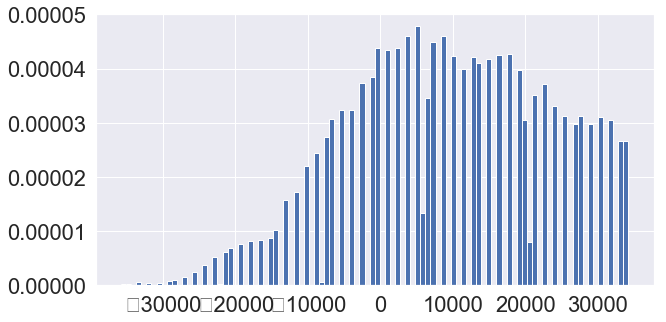

In [13]:
plt.figure(figsize=(10, 5))
# the histogram of the data
plt.hist(Z_0, 100, density=True)

plt.grid(True)
plt.show()


## Masks for activating only those edges that are connecting the same shower

In [14]:
def round_Z_coodr(x):
        return Z_centered[np.argmin(np.abs(Z_centered - x))]
round_Z_coodr = np.vectorize(round_Z_coodr)
    
def mask(data):
    x = data.x[:, 2]
    
    Z_0 = np.array(x.cpu()) * np.array([1e4])
    
    z_rounded = round_Z_coodr(Z_0)
    
    orders = np.zeros((len(Z_centered), data.edge_index.shape[1]))

    for i, z_i in enumerate(Z_centered):
        for j, z_0_i in enumerate(z_rounded):
            if z_0_i == z_i:
                # TODO data.edge_index[0] vs data.edge_index[1]
                orders[i][(data.edge_index[0] == j).cpu().numpy().astype(bool)] = 1
            
    return orders.astype(np.uint8)

In [15]:
masks = []
for i in range(len(showers_train)):
    masks.append(mask(showers_train[i]))

## GNN 

In [16]:
class EmulsionConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')
        self.mp = torch.nn.Linear(in_channels * 2, out_channels)
        
    def forward(self, x, edge_index, orders):
        for order in orders: 
            x = self.propagate('add', 
                               torch.index_select(edge_index[:, torch.ByteTensor(order)], 
                                                  0, 
                                                  torch.LongTensor([1, 0]).to(device)), x=x)     
        return x

    def message(self, x_j, x_i):
        return self.mp(torch.cat([x_i, x_j - x_i], dim=1))

    def update(self, aggr_out, x):
        return aggr_out + x

In [17]:
class GraphNN_KNN(torch.nn.Module):
    def __init__(self, k=9, dim_out=10):
        super().__init__()
        self.k = k
        self.emconv = EmulsionConv(self.k, dim_out)
        
        
    def forward(self, data, mask):
        x, edge_index, orders = data.x, data.edge_index, mask
        x = self.emconv(x=x, edge_index=edge_index, orders=orders)
        return x

In [18]:
model = GraphNN_KNN(dim_out=9).to(device)

In [19]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

----------------

In [ ]:
embeddings = model(showers_train[0], masks[0])

In [ ]:
edge_classifier = nn.Linear(18, 2)

In [ ]:
edge_labels = (showers_train[0].y[showers_train[0].edge_index[0]] == showers_train[0].y[showers_train[0].edge_index[1]])

In [ ]:
edge_labels.shape

In [ ]:
edge_data = torch.cat([embeddings[showers_train[0].edge_index[0]], embeddings[showers_train[0].edge_index[1]]], dim=1)

In [ ]:
edge_data.shape

In [ ]:
edge_labels.to(torch.int64)

In [ ]:
loss = F.nll_loss(edge_classifier(edge_data), edge_labels.to(torch.int64))

In [26]:
criterion = nn.BCELoss()
edge_classifier = nn.Sequential(nn.Linear(18, 1),
                                nn.Sigmoid()).to(device)


from tqdm import tqdm
for i in tqdm(range(10000)):
    mask = masks[i % len(showers_train)]
    shower = showers_train[i % len(showers_train)]
    
    optimizer.zero_grad()
    
    embeddings = model(shower, mask)
 
    
    edge_labels = (shower.y[shower.edge_index[0]] 
                   == shower.y[shower.edge_index[1]])  
    
    
    
    edge_data = torch.cat([embeddings[shower.edge_index[0]], 
                           embeddings[shower.edge_index[1]]], dim=1)
    

    loss = criterion(edge_classifier(edge_data).view(-1), edge_labels.view(-1).float())
    
    
    loss.backward()
    
    
    print(loss)
    
    optimizer.step()
    

  0%|          | 2/10000 [00:00<18:27,  9.03it/s]

tensor(1.3425, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(1.0680, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 4/10000 [00:00<18:17,  9.11it/s]

tensor(0.9725, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(1.2875, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 6/10000 [00:00<18:01,  9.24it/s]

tensor(1.0352, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.9298, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 8/10000 [00:00<17:36,  9.46it/s]

tensor(1.2096, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.9916, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 10/10000 [00:01<17:43,  9.39it/s]

tensor(0.8823, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(1.1287, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 12/10000 [00:01<17:33,  9.48it/s]

tensor(0.9498, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.8382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 14/10000 [00:01<17:43,  9.39it/s]

tensor(1.0448, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.9067, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 16/10000 [00:01<18:11,  9.15it/s]

tensor(0.8090, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.9775, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/10000 [00:01<18:04,  9.21it/s]

tensor(0.8559, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7876, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 20/10000 [00:02<17:36,  9.45it/s]

tensor(0.9329, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.8157, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 22/10000 [00:02<17:34,  9.47it/s]

tensor(0.7807, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.9291, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 24/10000 [00:02<17:25,  9.54it/s]

tensor(0.7918, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7804, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 26/10000 [00:02<17:53,  9.29it/s]

tensor(0.9193, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7806, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 28/10000 [00:03<18:32,  8.96it/s]

tensor(0.7741, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.8910, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 30/10000 [00:03<18:33,  8.95it/s]

tensor(0.7681, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7619, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 32/10000 [00:03<18:28,  8.99it/s]

tensor(0.8602, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7622, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 34/10000 [00:03<18:22,  9.04it/s]

tensor(0.7518, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.8462, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 36/10000 [00:03<17:45,  9.35it/s]

tensor(0.7626, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7470, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 38/10000 [00:04<17:29,  9.49it/s]

tensor(0.8406, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7610, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 40/10000 [00:04<17:32,  9.47it/s]

tensor(0.7398, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.8309, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 42/10000 [00:04<17:27,  9.51it/s]

tensor(0.7542, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7315, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 44/10000 [00:04<18:00,  9.21it/s]

tensor(0.8168, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7468, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 46/10000 [00:04<18:28,  8.98it/s]

tensor(0.7224, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.8075, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 48/10000 [00:05<18:32,  8.95it/s]

tensor(0.7445, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7178, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 50/10000 [00:05<18:41,  8.87it/s]

tensor(0.8006, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7413, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|          | 52/10000 [00:05<19:10,  8.65it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7923, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|          | 54/10000 [00:05<18:57,  8.74it/s]

tensor(0.7389, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7107, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|          | 56/10000 [00:06<18:34,  8.92it/s]

tensor(0.7863, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|          | 58/10000 [00:06<18:23,  9.01it/s]

tensor(0.7081, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7798, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|          | 60/10000 [00:06<18:00,  9.20it/s]

tensor(0.7346, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7046, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|          | 62/10000 [00:06<17:42,  9.36it/s]

tensor(0.7740, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7321, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|          | 64/10000 [00:06<17:48,  9.30it/s]

tensor(0.7028, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7714, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|          | 66/10000 [00:07<17:39,  9.38it/s]

tensor(0.7303, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7020, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|          | 68/10000 [00:07<17:24,  9.51it/s]

tensor(0.7678, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7288, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|          | 70/10000 [00:07<17:47,  9.31it/s]

tensor(0.7015, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7653, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|          | 72/10000 [00:07<17:31,  9.45it/s]

tensor(0.7277, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7002, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|          | 74/10000 [00:08<17:27,  9.47it/s]

tensor(0.7637, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7264, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|          | 76/10000 [00:08<17:23,  9.51it/s]

tensor(0.6980, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7626, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|          | 78/10000 [00:08<17:12,  9.61it/s]

tensor(0.7255, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6964, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|          | 79/10000 [00:08<17:20,  9.54it/s]

tensor(0.7618, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7248, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|          | 82/10000 [00:08<17:28,  9.46it/s]

tensor(0.6956, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7610, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|          | 84/10000 [00:09<17:26,  9.48it/s]

tensor(0.7243, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6947, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|          | 86/10000 [00:09<17:16,  9.56it/s]

tensor(0.7600, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7239, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|          | 88/10000 [00:09<17:28,  9.46it/s]

tensor(0.6941, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7593, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|          | 90/10000 [00:09<18:09,  9.10it/s]

tensor(0.7234, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6932, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|          | 92/10000 [00:09<17:36,  9.38it/s]

tensor(0.7589, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7231, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|          | 94/10000 [00:10<17:30,  9.43it/s]

tensor(0.6925, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7583, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|          | 96/10000 [00:10<17:25,  9.48it/s]

tensor(0.7230, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6920, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|          | 97/10000 [00:10<17:22,  9.50it/s]

tensor(0.7576, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7229, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|          | 100/10000 [00:10<17:15,  9.56it/s]

tensor(0.6917, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7571, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|          | 102/10000 [00:10<17:28,  9.44it/s]

tensor(0.7226, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6914, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|          | 104/10000 [00:11<17:44,  9.29it/s]

tensor(0.7573, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7222, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|          | 106/10000 [00:11<18:06,  9.11it/s]

tensor(0.6911, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7574, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|          | 108/10000 [00:11<18:10,  9.07it/s]

tensor(0.7220, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6905, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|          | 110/10000 [00:11<18:26,  8.94it/s]

tensor(0.7571, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7218, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|          | 112/10000 [00:12<17:58,  9.17it/s]

tensor(0.6902, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7567, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|          | 114/10000 [00:12<17:35,  9.36it/s]

tensor(0.7218, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6898, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|          | 115/10000 [00:12<17:30,  9.41it/s]

tensor(0.7565, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7218, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|          | 118/10000 [00:12<17:20,  9.50it/s]

tensor(0.6894, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7564, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|          | 120/10000 [00:12<17:08,  9.60it/s]

tensor(0.7217, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6891, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|          | 122/10000 [00:13<17:34,  9.37it/s]

tensor(0.7561, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7216, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|          | 124/10000 [00:13<18:01,  9.13it/s]

tensor(0.6889, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7559, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|▏         | 126/10000 [00:13<18:02,  9.12it/s]

tensor(0.7216, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6887, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|▏         | 128/10000 [00:13<18:25,  8.93it/s]

tensor(0.7556, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7215, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|▏         | 130/10000 [00:14<18:41,  8.80it/s]

tensor(0.6885, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7555, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|▏         | 132/10000 [00:14<18:35,  8.84it/s]

tensor(0.7215, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6882, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|▏         | 134/10000 [00:14<18:20,  8.97it/s]

tensor(0.7553, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7214, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|▏         | 136/10000 [00:14<18:17,  8.99it/s]

tensor(0.6880, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7552, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|▏         | 138/10000 [00:14<17:48,  9.23it/s]

tensor(0.7214, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6878, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|▏         | 140/10000 [00:15<17:23,  9.45it/s]

tensor(0.7550, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7213, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|▏         | 142/10000 [00:15<17:30,  9.38it/s]

tensor(0.6876, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7548, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|▏         | 144/10000 [00:15<17:24,  9.44it/s]

tensor(0.7213, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6874, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|▏         | 146/10000 [00:15<17:21,  9.47it/s]

tensor(0.7547, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7212, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  1%|▏         | 148/10000 [00:15<17:33,  9.35it/s]

tensor(0.6872, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7545, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 150/10000 [00:16<17:46,  9.24it/s]

tensor(0.7212, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6870, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 152/10000 [00:16<18:07,  9.05it/s]

tensor(0.7544, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7212, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 154/10000 [00:16<18:29,  8.87it/s]

tensor(0.6869, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7542, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 156/10000 [00:16<18:05,  9.07it/s]

tensor(0.7211, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6867, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 158/10000 [00:17<17:42,  9.27it/s]

tensor(0.7541, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7211, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 160/10000 [00:17<17:45,  9.23it/s]

tensor(0.6868, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7539, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 162/10000 [00:17<17:59,  9.11it/s]

tensor(0.7210, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6866, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 164/10000 [00:17<18:16,  8.97it/s]

tensor(0.7538, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7210, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 166/10000 [00:17<17:49,  9.20it/s]

tensor(0.6865, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7536, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 168/10000 [00:18<17:26,  9.39it/s]

tensor(0.7209, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6863, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 170/10000 [00:18<17:07,  9.56it/s]

tensor(0.7535, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7209, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 172/10000 [00:18<17:35,  9.31it/s]

tensor(0.6862, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7534, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 174/10000 [00:18<17:18,  9.46it/s]

tensor(0.7208, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6860, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 175/10000 [00:18<17:21,  9.44it/s]

tensor(0.7533, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7208, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 178/10000 [00:19<17:39,  9.27it/s]

tensor(0.6859, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7531, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 180/10000 [00:19<17:11,  9.52it/s]

tensor(0.7208, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6858, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 181/10000 [00:19<17:08,  9.54it/s]

tensor(0.7530, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7207, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 184/10000 [00:19<17:09,  9.54it/s]

tensor(0.6857, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7529, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 186/10000 [00:20<17:02,  9.59it/s]

tensor(0.7207, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6855, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 188/10000 [00:20<16:56,  9.65it/s]

tensor(0.7528, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7206, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 190/10000 [00:20<17:15,  9.47it/s]

tensor(0.6854, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7526, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 192/10000 [00:20<17:05,  9.56it/s]

tensor(0.7206, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6853, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 193/10000 [00:20<17:08,  9.54it/s]

tensor(0.7525, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7205, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 196/10000 [00:21<17:02,  9.59it/s]

tensor(0.6852, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7524, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 198/10000 [00:21<16:58,  9.62it/s]

tensor(0.7205, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6851, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 200/10000 [00:21<16:50,  9.70it/s]

tensor(0.7523, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7205, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 202/10000 [00:21<17:01,  9.60it/s]

tensor(0.6850, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7522, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 204/10000 [00:21<16:58,  9.61it/s]

tensor(0.7204, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6848, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 206/10000 [00:22<17:07,  9.54it/s]

tensor(0.7521, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7204, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 208/10000 [00:22<17:13,  9.47it/s]

tensor(0.6847, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7520, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 210/10000 [00:22<17:02,  9.58it/s]

tensor(0.7203, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6846, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 212/10000 [00:22<17:15,  9.45it/s]

tensor(0.7519, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7203, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 214/10000 [00:22<17:13,  9.47it/s]

tensor(0.6845, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7517, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 216/10000 [00:23<17:16,  9.44it/s]

tensor(0.7203, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6844, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 218/10000 [00:23<17:07,  9.52it/s]

tensor(0.7516, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7202, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 220/10000 [00:23<17:25,  9.35it/s]

tensor(0.6843, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7515, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 222/10000 [00:23<17:32,  9.29it/s]

tensor(0.7202, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6842, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 224/10000 [00:24<17:43,  9.19it/s]

tensor(0.7514, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7201, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 226/10000 [00:24<17:33,  9.28it/s]

tensor(0.6841, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7513, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 228/10000 [00:24<17:19,  9.40it/s]

tensor(0.7201, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6840, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 230/10000 [00:24<17:10,  9.48it/s]

tensor(0.7512, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7201, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 232/10000 [00:24<17:23,  9.36it/s]

tensor(0.6839, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7511, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 234/10000 [00:25<17:15,  9.43it/s]

tensor(0.7200, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6838, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 236/10000 [00:25<17:04,  9.53it/s]

tensor(0.7510, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7200, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 238/10000 [00:25<17:12,  9.45it/s]

tensor(0.6837, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7509, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 240/10000 [00:25<17:01,  9.56it/s]

tensor(0.7199, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6836, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 242/10000 [00:25<16:59,  9.57it/s]

tensor(0.7508, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7199, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 244/10000 [00:26<17:16,  9.41it/s]

tensor(0.6836, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7507, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 246/10000 [00:26<17:29,  9.29it/s]

tensor(0.7199, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6835, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 248/10000 [00:26<17:11,  9.46it/s]

tensor(0.7506, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7198, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▎         | 250/10000 [00:26<17:48,  9.12it/s]

tensor(0.6834, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7506, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 252/10000 [00:27<17:53,  9.08it/s]

tensor(0.7198, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6833, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 254/10000 [00:27<17:54,  9.07it/s]

tensor(0.7505, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7198, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 256/10000 [00:27<18:11,  8.93it/s]

tensor(0.6832, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7504, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 258/10000 [00:27<17:39,  9.20it/s]

tensor(0.7197, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6831, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 260/10000 [00:27<17:18,  9.38it/s]

tensor(0.7503, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7197, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 262/10000 [00:28<17:42,  9.17it/s]

tensor(0.6831, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7502, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 264/10000 [00:28<17:16,  9.39it/s]

tensor(0.7196, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6830, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 266/10000 [00:28<17:03,  9.51it/s]

tensor(0.7501, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7196, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 268/10000 [00:28<17:06,  9.48it/s]

tensor(0.6829, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7500, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 270/10000 [00:28<17:05,  9.49it/s]

tensor(0.7196, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6828, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 272/10000 [00:29<16:57,  9.56it/s]

tensor(0.7499, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7195, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 274/10000 [00:29<17:04,  9.50it/s]

tensor(0.6828, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7498, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 276/10000 [00:29<17:05,  9.48it/s]

tensor(0.7195, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6827, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 278/10000 [00:29<17:01,  9.51it/s]

tensor(0.7498, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7195, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 280/10000 [00:29<17:18,  9.36it/s]

tensor(0.6826, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7497, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 282/10000 [00:30<17:03,  9.50it/s]

tensor(0.7194, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6825, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 284/10000 [00:30<16:58,  9.54it/s]

tensor(0.7496, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7194, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 286/10000 [00:30<17:15,  9.38it/s]

tensor(0.6825, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7495, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 288/10000 [00:30<17:16,  9.37it/s]

tensor(0.7194, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6824, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 290/10000 [00:31<17:07,  9.45it/s]

tensor(0.7494, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7193, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 292/10000 [00:31<17:14,  9.38it/s]

tensor(0.6823, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7493, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 294/10000 [00:31<17:05,  9.47it/s]

tensor(0.7193, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6822, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 296/10000 [00:31<16:52,  9.58it/s]

tensor(0.7493, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7192, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 298/10000 [00:31<17:02,  9.49it/s]

tensor(0.6822, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7492, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 300/10000 [00:32<16:54,  9.56it/s]

tensor(0.7192, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6821, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 302/10000 [00:32<16:48,  9.62it/s]

tensor(0.7491, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7192, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 304/10000 [00:32<16:58,  9.52it/s]

tensor(0.6820, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7490, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 306/10000 [00:32<16:56,  9.53it/s]

tensor(0.7191, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6820, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 308/10000 [00:32<16:55,  9.54it/s]

tensor(0.7489, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7191, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 310/10000 [00:33<17:07,  9.43it/s]

tensor(0.6819, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7489, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 312/10000 [00:33<16:55,  9.54it/s]

tensor(0.7191, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6819, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 314/10000 [00:33<16:47,  9.61it/s]

tensor(0.7488, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7190, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 316/10000 [00:33<17:01,  9.48it/s]

tensor(0.6818, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7487, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 318/10000 [00:33<16:53,  9.56it/s]

tensor(0.7190, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6817, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 319/10000 [00:34<16:57,  9.51it/s]

tensor(0.7486, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7190, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 322/10000 [00:34<17:07,  9.42it/s]

tensor(0.6817, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7486, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 324/10000 [00:34<16:58,  9.50it/s]

tensor(0.7189, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6816, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 326/10000 [00:34<16:49,  9.58it/s]

tensor(0.7485, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7189, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 328/10000 [00:35<17:05,  9.43it/s]

tensor(0.6815, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7484, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 330/10000 [00:35<16:56,  9.52it/s]

tensor(0.7189, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6815, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 332/10000 [00:35<16:47,  9.59it/s]

tensor(0.7483, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7188, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 334/10000 [00:35<17:01,  9.46it/s]

tensor(0.6814, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7483, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 336/10000 [00:35<16:55,  9.51it/s]

tensor(0.7188, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6814, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 338/10000 [00:36<16:48,  9.58it/s]

tensor(0.7482, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7188, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 340/10000 [00:36<17:02,  9.44it/s]

tensor(0.6813, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7481, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 342/10000 [00:36<16:58,  9.48it/s]

tensor(0.7187, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6813, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 344/10000 [00:36<16:46,  9.59it/s]

tensor(0.7481, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7187, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 346/10000 [00:36<17:54,  8.99it/s]

tensor(0.6812, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7480, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 348/10000 [00:37<17:23,  9.25it/s]

tensor(0.7187, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6811, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▎         | 350/10000 [00:37<16:56,  9.50it/s]

tensor(0.7479, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7186, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▎         | 352/10000 [00:37<17:13,  9.33it/s]

tensor(0.6811, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7479, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▎         | 354/10000 [00:37<17:04,  9.41it/s]

tensor(0.7186, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6810, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▎         | 356/10000 [00:38<16:50,  9.54it/s]

tensor(0.7478, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7186, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▎         | 358/10000 [00:38<17:12,  9.34it/s]

tensor(0.6810, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7477, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▎         | 360/10000 [00:38<16:56,  9.48it/s]

tensor(0.7185, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6809, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▎         | 362/10000 [00:38<16:48,  9.56it/s]

tensor(0.7477, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7185, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▎         | 364/10000 [00:38<16:53,  9.50it/s]

tensor(0.6809, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7476, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▎         | 366/10000 [00:39<16:57,  9.47it/s]

tensor(0.7185, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6809, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▎         | 368/10000 [00:39<16:45,  9.58it/s]

tensor(0.7475, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7184, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▎         | 370/10000 [00:39<16:51,  9.52it/s]

tensor(0.6808, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7474, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▎         | 372/10000 [00:39<16:56,  9.47it/s]

tensor(0.7184, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6808, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▎         | 374/10000 [00:39<16:50,  9.53it/s]

tensor(0.7474, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7184, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▍         | 376/10000 [00:40<16:56,  9.46it/s]

tensor(0.6807, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7473, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▍         | 378/10000 [00:40<16:55,  9.48it/s]

tensor(0.7183, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6807, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▍         | 380/10000 [00:40<16:52,  9.50it/s]

tensor(0.7473, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7183, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▍         | 382/10000 [00:40<17:01,  9.41it/s]

tensor(0.6806, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7472, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▍         | 384/10000 [00:40<16:48,  9.53it/s]

tensor(0.7183, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6806, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▍         | 386/10000 [00:41<16:41,  9.60it/s]

tensor(0.7471, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7182, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▍         | 388/10000 [00:41<16:49,  9.52it/s]

tensor(0.6805, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7471, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▍         | 390/10000 [00:41<16:47,  9.54it/s]

tensor(0.7182, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6805, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▍         | 392/10000 [00:41<17:03,  9.39it/s]

tensor(0.7470, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7182, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▍         | 394/10000 [00:42<17:01,  9.41it/s]

tensor(0.6804, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7469, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▍         | 396/10000 [00:42<16:52,  9.48it/s]

tensor(0.7181, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6804, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▍         | 398/10000 [00:42<16:38,  9.62it/s]

tensor(0.7469, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7181, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▍         | 400/10000 [00:42<16:50,  9.50it/s]

tensor(0.6803, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7468, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▍         | 402/10000 [00:42<16:45,  9.54it/s]

tensor(0.7181, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6803, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▍         | 404/10000 [00:43<16:41,  9.58it/s]

tensor(0.7468, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7180, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▍         | 406/10000 [00:43<16:51,  9.48it/s]

tensor(0.6803, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7467, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▍         | 408/10000 [00:43<16:41,  9.57it/s]

tensor(0.7180, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6802, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▍         | 410/10000 [00:43<16:33,  9.65it/s]

tensor(0.7466, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7180, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▍         | 412/10000 [00:43<16:55,  9.44it/s]

tensor(0.6802, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7466, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▍         | 414/10000 [00:44<16:50,  9.48it/s]

tensor(0.7180, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6801, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▍         | 416/10000 [00:44<16:37,  9.60it/s]

tensor(0.7465, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7179, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▍         | 418/10000 [00:44<16:46,  9.52it/s]

tensor(0.6801, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7465, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▍         | 420/10000 [00:44<16:41,  9.57it/s]

tensor(0.7179, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6801, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▍         | 422/10000 [00:44<16:32,  9.65it/s]

tensor(0.7464, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7179, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▍         | 424/10000 [00:45<16:48,  9.50it/s]

tensor(0.6800, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7464, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▍         | 426/10000 [00:45<16:41,  9.56it/s]

tensor(0.7178, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6800, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▍         | 428/10000 [00:45<16:39,  9.57it/s]

tensor(0.7463, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7178, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▍         | 430/10000 [00:45<16:55,  9.42it/s]

tensor(0.6799, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7462, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▍         | 432/10000 [00:45<16:46,  9.50it/s]

tensor(0.7178, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6799, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▍         | 434/10000 [00:46<16:43,  9.54it/s]

tensor(0.7462, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7177, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▍         | 436/10000 [00:46<16:49,  9.48it/s]

tensor(0.6799, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7461, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▍         | 438/10000 [00:46<16:53,  9.43it/s]

tensor(0.7177, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6798, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▍         | 440/10000 [00:46<16:39,  9.57it/s]

tensor(0.7461, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7177, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▍         | 442/10000 [00:47<16:49,  9.47it/s]

tensor(0.6798, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7460, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▍         | 444/10000 [00:47<16:43,  9.53it/s]

tensor(0.7176, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6798, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▍         | 446/10000 [00:47<16:32,  9.62it/s]

tensor(0.7460, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7176, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▍         | 448/10000 [00:47<16:43,  9.52it/s]

tensor(0.6797, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7459, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  4%|▍         | 450/10000 [00:47<16:38,  9.57it/s]

tensor(0.7176, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6797, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▍         | 452/10000 [00:48<16:31,  9.63it/s]

tensor(0.7459, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7176, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▍         | 454/10000 [00:48<16:43,  9.51it/s]

tensor(0.6797, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7458, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▍         | 456/10000 [00:48<16:36,  9.57it/s]

tensor(0.7175, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6796, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▍         | 458/10000 [00:48<16:31,  9.62it/s]

tensor(0.7458, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7175, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▍         | 460/10000 [00:48<17:05,  9.30it/s]

tensor(0.6796, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7457, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▍         | 462/10000 [00:49<16:56,  9.39it/s]

tensor(0.7175, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6796, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▍         | 464/10000 [00:49<16:39,  9.54it/s]

tensor(0.7457, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7174, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▍         | 466/10000 [00:49<16:42,  9.51it/s]

tensor(0.6795, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7456, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▍         | 468/10000 [00:49<16:39,  9.54it/s]

tensor(0.7174, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6795, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▍         | 470/10000 [00:49<16:29,  9.63it/s]

tensor(0.7456, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7174, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▍         | 472/10000 [00:50<16:39,  9.54it/s]

tensor(0.6795, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7455, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▍         | 474/10000 [00:50<16:35,  9.57it/s]

tensor(0.7173, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6794, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▍         | 476/10000 [00:50<16:36,  9.56it/s]

tensor(0.7455, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7173, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▍         | 478/10000 [00:50<16:41,  9.51it/s]

tensor(0.6794, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7454, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▍         | 480/10000 [00:51<16:33,  9.58it/s]

tensor(0.7173, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6794, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▍         | 482/10000 [00:51<16:35,  9.56it/s]

tensor(0.7454, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7173, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▍         | 484/10000 [00:51<16:40,  9.51it/s]

tensor(0.6793, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7453, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▍         | 486/10000 [00:51<16:31,  9.59it/s]

tensor(0.7172, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6793, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▍         | 488/10000 [00:51<16:36,  9.55it/s]

tensor(0.7453, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7172, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▍         | 490/10000 [00:52<16:44,  9.47it/s]

tensor(0.6793, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7452, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▍         | 492/10000 [00:52<16:37,  9.53it/s]

tensor(0.7172, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6793, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▍         | 494/10000 [00:52<16:29,  9.60it/s]

tensor(0.7452, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7171, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▍         | 496/10000 [00:52<16:45,  9.46it/s]

tensor(0.6792, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7451, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▍         | 498/10000 [00:52<16:42,  9.48it/s]

tensor(0.7171, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6792, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▌         | 500/10000 [00:53<16:58,  9.32it/s]

tensor(0.7451, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7171, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▌         | 502/10000 [00:53<16:54,  9.37it/s]

tensor(0.6792, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7450, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▌         | 504/10000 [00:53<16:40,  9.50it/s]

tensor(0.7170, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6792, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▌         | 506/10000 [00:53<16:34,  9.55it/s]

tensor(0.7450, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7170, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▌         | 508/10000 [00:53<16:43,  9.46it/s]

tensor(0.6791, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7449, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▌         | 510/10000 [00:54<16:34,  9.54it/s]

tensor(0.7170, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6791, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▌         | 512/10000 [00:54<16:28,  9.60it/s]

tensor(0.7449, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7170, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▌         | 514/10000 [00:54<16:47,  9.42it/s]

tensor(0.6791, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7448, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▌         | 516/10000 [00:54<16:48,  9.41it/s]

tensor(0.7169, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6791, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▌         | 518/10000 [00:55<16:32,  9.56it/s]

tensor(0.7448, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7169, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▌         | 520/10000 [00:55<16:47,  9.41it/s]

tensor(0.6790, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7448, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▌         | 522/10000 [00:55<16:34,  9.53it/s]

tensor(0.7169, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6790, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▌         | 524/10000 [00:55<16:28,  9.59it/s]

tensor(0.7447, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7169, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▌         | 526/10000 [00:55<16:39,  9.48it/s]

tensor(0.6790, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7447, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▌         | 528/10000 [00:56<16:30,  9.56it/s]

tensor(0.7168, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6790, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▌         | 530/10000 [00:56<16:24,  9.62it/s]

tensor(0.7446, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7168, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▌         | 532/10000 [00:56<16:33,  9.53it/s]

tensor(0.6789, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7446, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▌         | 534/10000 [00:56<16:25,  9.61it/s]

tensor(0.7168, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6789, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▌         | 536/10000 [00:56<16:21,  9.64it/s]

tensor(0.7445, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7167, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▌         | 538/10000 [00:57<16:34,  9.51it/s]

tensor(0.6789, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7445, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▌         | 540/10000 [00:57<16:29,  9.56it/s]

tensor(0.7167, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6789, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▌         | 542/10000 [00:57<16:22,  9.63it/s]

tensor(0.7445, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7167, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▌         | 544/10000 [00:57<16:35,  9.50it/s]

tensor(0.6788, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7444, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▌         | 546/10000 [00:57<16:33,  9.51it/s]

tensor(0.7167, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6788, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  5%|▌         | 548/10000 [00:58<16:22,  9.62it/s]

tensor(0.7444, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7166, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▌         | 550/10000 [00:58<16:33,  9.51it/s]

tensor(0.6788, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7441, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▌         | 552/10000 [00:58<16:28,  9.56it/s]

tensor(0.7166, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6788, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▌         | 554/10000 [00:58<16:19,  9.64it/s]

tensor(0.7440, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7166, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▌         | 556/10000 [00:59<16:58,  9.27it/s]

tensor(0.6785, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7437, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▌         | 558/10000 [00:59<16:40,  9.44it/s]

tensor(0.7166, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6785, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▌         | 560/10000 [00:59<16:28,  9.55it/s]

tensor(0.7437, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7166, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▌         | 562/10000 [00:59<16:38,  9.45it/s]

tensor(0.6785, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7436, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▌         | 564/10000 [00:59<16:40,  9.44it/s]

tensor(0.7165, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6785, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▌         | 566/10000 [01:00<16:24,  9.59it/s]

tensor(0.7436, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7165, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▌         | 568/10000 [01:00<16:31,  9.52it/s]

tensor(0.6785, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7435, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▌         | 570/10000 [01:00<16:26,  9.56it/s]

tensor(0.7165, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6784, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▌         | 571/10000 [01:00<16:30,  9.52it/s]

tensor(0.7435, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7164, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▌         | 574/10000 [01:00<16:32,  9.50it/s]

tensor(0.6784, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7435, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▌         | 576/10000 [01:01<16:24,  9.57it/s]

tensor(0.7164, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6784, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▌         | 578/10000 [01:01<16:18,  9.63it/s]

tensor(0.7434, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7164, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▌         | 580/10000 [01:01<16:29,  9.52it/s]

tensor(0.6784, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7434, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▌         | 582/10000 [01:01<16:22,  9.59it/s]

tensor(0.7164, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6784, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▌         | 583/10000 [01:01<16:31,  9.49it/s]

tensor(0.7433, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7163, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▌         | 586/10000 [01:02<16:27,  9.54it/s]

tensor(0.6784, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7433, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▌         | 588/10000 [01:02<16:22,  9.58it/s]

tensor(0.7163, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6783, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▌         | 590/10000 [01:02<16:14,  9.66it/s]

tensor(0.7433, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7163, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▌         | 592/10000 [01:02<16:33,  9.47it/s]

tensor(0.6783, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7432, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▌         | 594/10000 [01:02<16:34,  9.46it/s]

tensor(0.7163, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6783, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▌         | 596/10000 [01:03<16:26,  9.53it/s]

tensor(0.7432, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7163, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▌         | 598/10000 [01:03<16:32,  9.47it/s]

tensor(0.6783, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7431, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▌         | 600/10000 [01:03<16:22,  9.57it/s]

tensor(0.7162, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6783, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▌         | 602/10000 [01:03<16:20,  9.59it/s]

tensor(0.7431, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7162, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▌         | 604/10000 [01:04<16:27,  9.52it/s]

tensor(0.6782, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7431, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▌         | 606/10000 [01:04<16:18,  9.60it/s]

tensor(0.7162, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6782, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▌         | 608/10000 [01:04<16:10,  9.68it/s]

tensor(0.7430, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7162, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▌         | 610/10000 [01:04<16:22,  9.55it/s]

tensor(0.6782, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7430, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▌         | 612/10000 [01:04<16:32,  9.46it/s]

tensor(0.7162, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6782, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▌         | 614/10000 [01:05<16:22,  9.56it/s]

tensor(0.7430, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7161, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▌         | 616/10000 [01:05<16:28,  9.49it/s]

tensor(0.6782, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7427, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▌         | 618/10000 [01:05<16:31,  9.46it/s]

tensor(0.7161, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6782, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▌         | 620/10000 [01:05<16:22,  9.54it/s]

tensor(0.7426, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7161, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▌         | 622/10000 [01:05<16:31,  9.46it/s]

tensor(0.6781, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7426, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▌         | 624/10000 [01:06<16:43,  9.34it/s]

tensor(0.7161, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6781, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▋         | 626/10000 [01:06<16:34,  9.42it/s]

tensor(0.7426, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7161, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▋         | 628/10000 [01:06<16:42,  9.35it/s]

tensor(0.6781, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7425, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▋         | 630/10000 [01:06<16:34,  9.42it/s]

tensor(0.7160, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6781, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▋         | 631/10000 [01:06<16:34,  9.42it/s]

tensor(0.7425, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7160, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▋         | 634/10000 [01:07<16:27,  9.49it/s]

tensor(0.6781, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7425, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▋         | 636/10000 [01:07<16:27,  9.48it/s]

tensor(0.7160, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6781, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▋         | 638/10000 [01:07<16:18,  9.57it/s]

tensor(0.7424, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7160, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▋         | 640/10000 [01:07<16:47,  9.29it/s]

tensor(0.6781, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7424, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▋         | 642/10000 [01:08<16:31,  9.44it/s]

tensor(0.7160, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6781, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▋         | 644/10000 [01:08<16:18,  9.57it/s]

tensor(0.7424, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7159, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▋         | 646/10000 [01:08<16:27,  9.48it/s]

tensor(0.6780, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7423, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▋         | 648/10000 [01:08<16:19,  9.55it/s]

tensor(0.7159, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6780, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  6%|▋         | 650/10000 [01:08<16:16,  9.58it/s]

tensor(0.7423, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7159, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 652/10000 [01:09<16:23,  9.51it/s]

tensor(0.6780, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7423, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 654/10000 [01:09<16:15,  9.58it/s]

tensor(0.7159, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6780, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 656/10000 [01:09<16:09,  9.64it/s]

tensor(0.7422, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7159, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 658/10000 [01:09<17:52,  8.71it/s]

tensor(0.6780, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7422, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 660/10000 [01:09<17:11,  9.06it/s]

tensor(0.7159, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6780, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 662/10000 [01:10<16:39,  9.34it/s]

tensor(0.7422, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7158, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 664/10000 [01:10<16:36,  9.36it/s]

tensor(0.6780, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7421, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 666/10000 [01:10<16:24,  9.49it/s]

tensor(0.7158, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6779, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 668/10000 [01:10<16:13,  9.59it/s]

tensor(0.7421, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7158, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 670/10000 [01:11<16:25,  9.47it/s]

tensor(0.6779, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7421, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 672/10000 [01:11<16:15,  9.56it/s]

tensor(0.7158, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6779, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 674/10000 [01:11<16:28,  9.43it/s]

tensor(0.7420, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7158, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 676/10000 [01:11<17:02,  9.12it/s]

tensor(0.6779, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7420, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 678/10000 [01:11<18:57,  8.20it/s]

tensor(0.7158, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6779, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 680/10000 [01:12<17:37,  8.81it/s]

tensor(0.7420, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7157, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 682/10000 [01:12<17:00,  9.13it/s]

tensor(0.6779, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7420, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 684/10000 [01:12<16:36,  9.35it/s]

tensor(0.7157, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6779, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 686/10000 [01:12<16:17,  9.53it/s]

tensor(0.7419, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7157, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 688/10000 [01:12<16:28,  9.42it/s]

tensor(0.6779, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7419, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 690/10000 [01:13<16:29,  9.41it/s]

tensor(0.7157, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6778, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 692/10000 [01:13<16:26,  9.43it/s]

tensor(0.7419, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7157, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 694/10000 [01:13<16:25,  9.44it/s]

tensor(0.6778, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7418, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 696/10000 [01:13<16:19,  9.50it/s]

tensor(0.7157, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6778, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 698/10000 [01:14<16:13,  9.55it/s]

tensor(0.7418, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7156, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 700/10000 [01:14<16:24,  9.45it/s]

tensor(0.6778, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7418, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 702/10000 [01:14<16:15,  9.53it/s]

tensor(0.7156, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6778, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 704/10000 [01:14<16:06,  9.62it/s]

tensor(0.7418, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7156, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 706/10000 [01:14<16:18,  9.50it/s]

tensor(0.6778, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7417, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 708/10000 [01:15<16:20,  9.47it/s]

tensor(0.7156, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6778, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 710/10000 [01:15<16:15,  9.53it/s]

tensor(0.7417, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7156, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 712/10000 [01:15<16:20,  9.47it/s]

tensor(0.6778, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7417, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 714/10000 [01:15<25:02,  6.18it/s]

tensor(0.7156, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6777, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 716/10000 [01:16<31:10,  4.96it/s]

tensor(0.7416, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7156, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 718/10000 [01:16<26:39,  5.80it/s]

tensor(0.6777, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7416, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 720/10000 [01:16<21:15,  7.28it/s]

tensor(0.7155, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6777, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 722/10000 [01:17<18:33,  8.34it/s]

tensor(0.7416, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7155, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 724/10000 [01:17<17:25,  8.87it/s]

tensor(0.6777, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7416, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 726/10000 [01:17<16:54,  9.14it/s]

tensor(0.7155, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6777, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 728/10000 [01:17<16:23,  9.43it/s]

tensor(0.7415, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7155, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 730/10000 [01:17<16:20,  9.46it/s]

tensor(0.6777, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7415, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 732/10000 [01:18<16:17,  9.48it/s]

tensor(0.7155, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6777, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 734/10000 [01:18<16:02,  9.63it/s]

tensor(0.7415, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7155, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 736/10000 [01:18<16:17,  9.47it/s]

tensor(0.6777, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7415, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 738/10000 [01:18<16:09,  9.55it/s]

tensor(0.7155, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6777, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 740/10000 [01:19<16:18,  9.47it/s]

tensor(0.7414, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7154, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 742/10000 [01:19<16:51,  9.15it/s]

tensor(0.6777, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7414, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 744/10000 [01:19<17:10,  8.99it/s]

tensor(0.7154, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6776, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 746/10000 [01:19<17:20,  8.89it/s]

tensor(0.7414, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7154, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 748/10000 [01:19<16:57,  9.09it/s]

tensor(0.6776, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7414, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 750/10000 [01:20<16:53,  9.13it/s]

tensor(0.7154, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6776, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 752/10000 [01:20<16:39,  9.25it/s]

tensor(0.7413, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7154, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 754/10000 [01:20<16:47,  9.18it/s]

tensor(0.6776, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7413, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 756/10000 [01:20<16:30,  9.33it/s]

tensor(0.7154, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6776, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 758/10000 [01:20<16:35,  9.28it/s]

tensor(0.7413, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7154, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 760/10000 [01:21<16:47,  9.17it/s]

tensor(0.6776, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7413, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 762/10000 [01:21<16:35,  9.28it/s]

tensor(0.7154, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6776, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 764/10000 [01:21<16:21,  9.41it/s]

tensor(0.7412, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7153, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 766/10000 [01:21<16:29,  9.33it/s]

tensor(0.6776, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7412, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 768/10000 [01:22<16:20,  9.42it/s]

tensor(0.7153, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6776, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 770/10000 [01:22<16:09,  9.52it/s]

tensor(0.7412, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7153, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 772/10000 [01:22<16:30,  9.32it/s]

tensor(0.6776, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7412, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 774/10000 [01:22<16:23,  9.38it/s]

tensor(0.7153, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6775, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 775/10000 [01:22<16:26,  9.35it/s]

tensor(0.7411, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7153, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 778/10000 [01:23<16:40,  9.22it/s]

tensor(0.6775, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7411, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 780/10000 [01:23<17:07,  8.98it/s]

tensor(0.7153, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6775, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 782/10000 [01:23<16:26,  9.34it/s]

tensor(0.7411, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7153, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 784/10000 [01:23<16:27,  9.33it/s]

tensor(0.6775, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7411, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 786/10000 [01:24<17:04,  9.00it/s]

tensor(0.7153, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6775, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 788/10000 [01:24<16:38,  9.23it/s]

tensor(0.7411, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7153, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 790/10000 [01:24<16:45,  9.16it/s]

tensor(0.6775, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7410, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 792/10000 [01:24<16:31,  9.28it/s]

tensor(0.7152, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6775, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 794/10000 [01:24<16:16,  9.43it/s]

tensor(0.7410, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7152, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 796/10000 [01:25<16:27,  9.32it/s]

tensor(0.6775, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7410, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 798/10000 [01:25<16:16,  9.42it/s]

tensor(0.7152, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6775, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 799/10000 [01:25<16:15,  9.43it/s]

tensor(0.7410, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7152, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 802/10000 [01:25<16:14,  9.44it/s]

tensor(0.6775, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7410, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 804/10000 [01:25<16:10,  9.48it/s]

tensor(0.7152, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6775, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 806/10000 [01:26<15:58,  9.59it/s]

tensor(0.7409, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7152, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 808/10000 [01:26<17:36,  8.70it/s]

tensor(0.6775, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7409, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 810/10000 [01:26<16:59,  9.01it/s]

tensor(0.7152, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6774, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 812/10000 [01:26<16:47,  9.12it/s]

tensor(0.7409, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7152, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 814/10000 [01:27<16:37,  9.21it/s]

tensor(0.6774, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7409, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 816/10000 [01:27<16:29,  9.28it/s]

tensor(0.7152, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6774, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 818/10000 [01:27<16:33,  9.25it/s]

tensor(0.7409, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7152, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 820/10000 [01:27<16:23,  9.33it/s]

tensor(0.6774, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7408, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 822/10000 [01:27<16:16,  9.40it/s]

tensor(0.7151, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6774, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 824/10000 [01:28<16:17,  9.39it/s]

tensor(0.7408, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7151, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 826/10000 [01:28<16:28,  9.28it/s]

tensor(0.6774, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7408, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 828/10000 [01:28<16:21,  9.34it/s]

tensor(0.7151, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6774, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 830/10000 [01:28<16:43,  9.14it/s]

tensor(0.7408, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7151, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 832/10000 [01:28<16:42,  9.15it/s]

tensor(0.6774, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7408, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 834/10000 [01:29<16:19,  9.36it/s]

tensor(0.7151, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6774, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 836/10000 [01:29<16:07,  9.47it/s]

tensor(0.7407, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7151, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 838/10000 [01:29<16:16,  9.39it/s]

tensor(0.6774, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7407, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 840/10000 [01:29<16:10,  9.44it/s]

tensor(0.7151, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6774, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 842/10000 [01:30<15:58,  9.56it/s]

tensor(0.7407, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7151, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 844/10000 [01:30<16:32,  9.23it/s]

tensor(0.6774, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7407, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 846/10000 [01:30<17:07,  8.91it/s]

tensor(0.7151, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6773, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 848/10000 [01:30<16:45,  9.10it/s]

tensor(0.7407, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7151, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  8%|▊         | 850/10000 [01:30<16:37,  9.18it/s]

tensor(0.6773, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7406, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▊         | 852/10000 [01:31<16:21,  9.32it/s]

tensor(0.7150, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6773, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▊         | 854/10000 [01:31<16:04,  9.49it/s]

tensor(0.7406, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7150, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▊         | 856/10000 [01:31<16:20,  9.32it/s]

tensor(0.6773, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7406, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▊         | 858/10000 [01:31<16:05,  9.47it/s]

tensor(0.7150, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6773, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▊         | 860/10000 [01:31<15:57,  9.55it/s]

tensor(0.7406, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7150, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▊         | 862/10000 [01:32<16:00,  9.52it/s]

tensor(0.6773, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7406, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▊         | 864/10000 [01:32<16:15,  9.37it/s]

tensor(0.7150, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6773, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▊         | 866/10000 [01:32<16:55,  8.99it/s]

tensor(0.7405, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7150, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▊         | 868/10000 [01:32<16:49,  9.04it/s]

tensor(0.6773, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7405, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▊         | 870/10000 [01:33<16:23,  9.28it/s]

tensor(0.7150, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6773, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▊         | 872/10000 [01:33<16:05,  9.46it/s]

tensor(0.7405, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7150, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▊         | 874/10000 [01:33<16:04,  9.46it/s]

tensor(0.6773, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7405, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▉         | 876/10000 [01:33<15:49,  9.61it/s]

tensor(0.7150, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6773, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▉         | 877/10000 [01:33<15:48,  9.61it/s]

tensor(0.7405, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7150, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▉         | 880/10000 [01:34<15:42,  9.68it/s]

tensor(0.6773, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7405, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▉         | 882/10000 [01:34<15:36,  9.73it/s]

tensor(0.7150, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6773, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▉         | 884/10000 [01:34<15:35,  9.74it/s]

tensor(0.7404, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7150, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▉         | 886/10000 [01:34<16:11,  9.38it/s]

tensor(0.6773, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7404, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▉         | 888/10000 [01:34<16:12,  9.37it/s]

tensor(0.7149, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6773, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▉         | 890/10000 [01:35<15:54,  9.54it/s]

tensor(0.7404, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7149, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▉         | 892/10000 [01:35<16:01,  9.47it/s]

tensor(0.6772, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7404, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▉         | 894/10000 [01:35<16:11,  9.37it/s]

tensor(0.7149, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6772, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▉         | 896/10000 [01:35<15:59,  9.49it/s]

tensor(0.7404, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7149, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▉         | 898/10000 [01:35<15:58,  9.50it/s]

tensor(0.6772, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7404, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▉         | 900/10000 [01:36<15:48,  9.59it/s]

tensor(0.7149, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6772, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▉         | 902/10000 [01:36<15:44,  9.63it/s]

tensor(0.7403, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7149, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▉         | 904/10000 [01:36<16:08,  9.39it/s]

tensor(0.6772, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7403, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▉         | 906/10000 [01:36<16:06,  9.41it/s]

tensor(0.7149, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6772, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▉         | 908/10000 [01:37<15:54,  9.53it/s]

tensor(0.7403, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7149, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▉         | 910/10000 [01:37<16:04,  9.42it/s]

tensor(0.6772, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7403, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▉         | 912/10000 [01:37<16:01,  9.45it/s]

tensor(0.7149, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6772, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▉         | 914/10000 [01:37<16:00,  9.46it/s]

tensor(0.7403, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7149, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▉         | 916/10000 [01:37<16:03,  9.43it/s]

tensor(0.6772, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7403, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▉         | 918/10000 [01:38<15:58,  9.48it/s]

tensor(0.7149, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6772, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▉         | 920/10000 [01:38<15:45,  9.60it/s]

tensor(0.7402, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7149, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▉         | 922/10000 [01:38<15:52,  9.53it/s]

tensor(0.6772, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7402, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▉         | 924/10000 [01:38<16:07,  9.38it/s]

tensor(0.7149, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6772, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▉         | 925/10000 [01:38<16:04,  9.41it/s]

tensor(0.7402, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7148, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▉         | 928/10000 [01:39<15:54,  9.50it/s]

tensor(0.6772, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7402, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▉         | 930/10000 [01:39<15:54,  9.50it/s]

tensor(0.7148, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6772, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▉         | 932/10000 [01:39<15:44,  9.60it/s]

tensor(0.7402, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7148, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▉         | 934/10000 [01:39<15:52,  9.52it/s]

tensor(0.6772, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7402, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▉         | 936/10000 [01:39<15:50,  9.54it/s]

tensor(0.7148, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6772, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▉         | 938/10000 [01:40<15:46,  9.58it/s]

tensor(0.7402, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7148, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▉         | 940/10000 [01:40<15:54,  9.49it/s]

tensor(0.6772, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7401, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▉         | 942/10000 [01:40<16:04,  9.39it/s]

tensor(0.7148, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6772, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▉         | 944/10000 [01:40<15:48,  9.54it/s]

tensor(0.7401, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7148, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▉         | 946/10000 [01:41<15:58,  9.45it/s]

tensor(0.6771, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7401, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  9%|▉         | 948/10000 [01:41<15:51,  9.51it/s]

tensor(0.7148, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6771, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|▉         | 950/10000 [01:41<15:41,  9.61it/s]

tensor(0.7401, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7148, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|▉         | 952/10000 [01:41<15:55,  9.47it/s]

tensor(0.6771, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7401, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|▉         | 954/10000 [01:41<15:49,  9.53it/s]

tensor(0.7148, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6771, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|▉         | 956/10000 [01:42<15:42,  9.60it/s]

tensor(0.7401, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7148, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|▉         | 958/10000 [01:42<16:30,  9.13it/s]

tensor(0.6771, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7401, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|▉         | 960/10000 [01:42<16:39,  9.04it/s]

tensor(0.7148, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6771, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|▉         | 962/10000 [01:42<16:39,  9.05it/s]

tensor(0.7400, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7148, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|▉         | 964/10000 [01:42<17:06,  8.81it/s]

tensor(0.6771, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7400, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|▉         | 966/10000 [01:43<16:32,  9.10it/s]

tensor(0.7148, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6771, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|▉         | 968/10000 [01:43<16:31,  9.11it/s]

tensor(0.7400, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7147, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|▉         | 970/10000 [01:43<16:41,  9.02it/s]

tensor(0.6771, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7400, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|▉         | 972/10000 [01:43<16:10,  9.31it/s]

tensor(0.7147, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6771, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|▉         | 974/10000 [01:44<16:16,  9.24it/s]

tensor(0.7400, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7147, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|▉         | 976/10000 [01:44<16:07,  9.33it/s]

tensor(0.6771, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7400, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|▉         | 978/10000 [01:44<15:46,  9.54it/s]

tensor(0.7147, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6771, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|▉         | 980/10000 [01:44<15:38,  9.61it/s]

tensor(0.7400, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7147, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|▉         | 982/10000 [01:44<15:50,  9.49it/s]

tensor(0.6771, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7399, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|▉         | 984/10000 [01:45<15:40,  9.59it/s]

tensor(0.7147, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6771, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|▉         | 985/10000 [01:45<15:39,  9.59it/s]

tensor(0.7399, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7147, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|▉         | 988/10000 [01:45<15:35,  9.64it/s]

tensor(0.6771, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7399, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|▉         | 990/10000 [01:45<15:32,  9.66it/s]

tensor(0.7147, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6771, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|▉         | 991/10000 [01:45<15:36,  9.62it/s]

tensor(0.7399, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7147, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|▉         | 994/10000 [01:46<15:33,  9.65it/s]

tensor(0.6771, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7399, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|▉         | 996/10000 [01:46<15:29,  9.69it/s]

tensor(0.7147, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6771, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|▉         | 998/10000 [01:46<15:31,  9.67it/s]

tensor(0.7399, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7147, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|█         | 1000/10000 [01:46<16:09,  9.28it/s]

tensor(0.6771, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7399, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|█         | 1002/10000 [01:46<16:20,  9.18it/s]

tensor(0.7147, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6771, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|█         | 1004/10000 [01:47<15:56,  9.40it/s]

tensor(0.7399, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7147, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|█         | 1006/10000 [01:47<16:01,  9.35it/s]

tensor(0.6771, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7398, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|█         | 1008/10000 [01:47<15:46,  9.50it/s]

tensor(0.7147, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6770, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|█         | 1010/10000 [01:47<15:35,  9.61it/s]

tensor(0.7398, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7147, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|█         | 1012/10000 [01:48<16:05,  9.31it/s]

tensor(0.6770, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7398, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|█         | 1014/10000 [01:48<16:24,  9.12it/s]

tensor(0.7147, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6770, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|█         | 1016/10000 [01:48<16:31,  9.06it/s]

tensor(0.7398, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7146, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|█         | 1018/10000 [01:48<16:16,  9.20it/s]

tensor(0.6770, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7398, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|█         | 1020/10000 [01:48<16:02,  9.33it/s]

tensor(0.7146, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6770, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|█         | 1022/10000 [01:49<15:42,  9.53it/s]

tensor(0.7398, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7146, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|█         | 1024/10000 [01:49<15:37,  9.57it/s]

tensor(0.6770, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7398, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|█         | 1026/10000 [01:49<15:32,  9.63it/s]

tensor(0.7146, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6770, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|█         | 1028/10000 [01:49<15:28,  9.67it/s]

tensor(0.7398, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7146, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|█         | 1030/10000 [01:49<15:36,  9.58it/s]

tensor(0.6770, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7398, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|█         | 1032/10000 [01:50<15:33,  9.61it/s]

tensor(0.7146, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6770, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|█         | 1033/10000 [01:50<15:40,  9.53it/s]

tensor(0.7397, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7146, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|█         | 1036/10000 [01:50<15:36,  9.58it/s]

tensor(0.6770, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7397, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|█         | 1038/10000 [01:50<15:39,  9.54it/s]

tensor(0.7146, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6770, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|█         | 1039/10000 [01:50<15:40,  9.52it/s]

tensor(0.7397, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7146, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|█         | 1042/10000 [01:51<15:41,  9.51it/s]

tensor(0.6770, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7397, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|█         | 1044/10000 [01:51<15:33,  9.60it/s]

tensor(0.7146, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6770, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|█         | 1046/10000 [01:51<15:32,  9.60it/s]

tensor(0.7397, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7146, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|█         | 1048/10000 [01:51<15:57,  9.35it/s]

tensor(0.6770, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7397, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 10%|█         | 1050/10000 [01:52<15:42,  9.49it/s]

tensor(0.7146, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6770, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█         | 1052/10000 [01:52<15:30,  9.62it/s]

tensor(0.7397, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7146, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█         | 1054/10000 [01:52<15:32,  9.59it/s]

tensor(0.6770, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7397, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█         | 1056/10000 [01:52<15:29,  9.62it/s]

tensor(0.7146, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6770, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█         | 1058/10000 [01:52<15:41,  9.50it/s]

tensor(0.7396, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7146, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█         | 1060/10000 [01:53<16:13,  9.19it/s]

tensor(0.6770, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7396, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█         | 1062/10000 [01:53<16:21,  9.10it/s]

tensor(0.7146, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6770, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█         | 1064/10000 [01:53<16:09,  9.22it/s]

tensor(0.7396, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7146, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█         | 1066/10000 [01:53<16:07,  9.24it/s]

tensor(0.6770, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7396, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█         | 1068/10000 [01:53<15:53,  9.36it/s]

tensor(0.7145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6770, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█         | 1070/10000 [01:54<15:39,  9.51it/s]

tensor(0.7396, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█         | 1072/10000 [01:54<15:43,  9.47it/s]

tensor(0.6770, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7396, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█         | 1074/10000 [01:54<16:15,  9.15it/s]

tensor(0.7145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6770, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█         | 1075/10000 [01:54<16:28,  9.03it/s]

tensor(0.7396, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█         | 1078/10000 [01:55<16:04,  9.25it/s]

tensor(0.6770, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7396, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█         | 1080/10000 [01:55<15:52,  9.37it/s]

tensor(0.7145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6770, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█         | 1081/10000 [01:55<15:54,  9.34it/s]

tensor(0.7396, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█         | 1084/10000 [01:55<15:46,  9.42it/s]

tensor(0.6770, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7396, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█         | 1086/10000 [01:55<15:38,  9.50it/s]

tensor(0.7145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6770, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█         | 1087/10000 [01:55<15:40,  9.48it/s]

tensor(0.7395, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█         | 1090/10000 [01:56<15:34,  9.54it/s]

tensor(0.6769, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7395, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█         | 1092/10000 [01:56<15:39,  9.48it/s]

tensor(0.7145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6769, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█         | 1093/10000 [01:56<15:42,  9.45it/s]

tensor(0.7395, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█         | 1096/10000 [01:56<15:37,  9.49it/s]

tensor(0.6769, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7395, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█         | 1098/10000 [01:57<15:27,  9.60it/s]

tensor(0.7145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6769, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█         | 1100/10000 [01:57<15:23,  9.64it/s]

tensor(0.7395, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█         | 1102/10000 [01:57<16:01,  9.25it/s]

tensor(0.6769, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7395, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█         | 1104/10000 [01:57<16:17,  9.10it/s]

tensor(0.7145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6769, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█         | 1106/10000 [01:57<16:23,  9.05it/s]

tensor(0.7395, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█         | 1108/10000 [01:58<16:32,  8.96it/s]

tensor(0.6769, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7395, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█         | 1110/10000 [01:58<16:28,  8.99it/s]

tensor(0.7145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6769, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█         | 1112/10000 [01:58<16:18,  9.08it/s]

tensor(0.7395, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█         | 1114/10000 [01:58<16:38,  8.90it/s]

tensor(0.6769, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7395, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█         | 1116/10000 [01:59<16:33,  8.94it/s]

tensor(0.7145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6769, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█         | 1118/10000 [01:59<16:19,  9.06it/s]

tensor(0.7394, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█         | 1120/10000 [01:59<16:06,  9.18it/s]

tensor(0.6769, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7394, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█         | 1122/10000 [01:59<15:46,  9.38it/s]

tensor(0.7145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6769, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█         | 1124/10000 [01:59<15:29,  9.55it/s]

tensor(0.7394, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█▏        | 1126/10000 [02:00<15:35,  9.48it/s]

tensor(0.6769, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7394, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█▏        | 1128/10000 [02:00<15:30,  9.53it/s]

tensor(0.7144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6769, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█▏        | 1130/10000 [02:00<15:26,  9.57it/s]

tensor(0.7394, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█▏        | 1132/10000 [02:00<15:32,  9.51it/s]

tensor(0.6769, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7394, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█▏        | 1134/10000 [02:01<15:20,  9.63it/s]

tensor(0.7144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6769, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█▏        | 1136/10000 [02:01<15:13,  9.70it/s]

tensor(0.7394, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█▏        | 1138/10000 [02:01<15:29,  9.53it/s]

tensor(0.6769, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7394, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█▏        | 1140/10000 [02:01<15:26,  9.56it/s]

tensor(0.7144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6769, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█▏        | 1142/10000 [02:01<15:25,  9.57it/s]

tensor(0.7394, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█▏        | 1144/10000 [02:02<15:41,  9.40it/s]

tensor(0.6769, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7394, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█▏        | 1146/10000 [02:02<15:34,  9.47it/s]

tensor(0.7144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6769, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 11%|█▏        | 1148/10000 [02:02<15:30,  9.51it/s]

tensor(0.7393, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1150/10000 [02:02<15:34,  9.47it/s]

tensor(0.6769, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7393, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1152/10000 [02:02<15:28,  9.53it/s]

tensor(0.7144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6769, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1154/10000 [02:03<15:15,  9.66it/s]

tensor(0.7393, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1156/10000 [02:03<15:47,  9.33it/s]

tensor(0.6769, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7393, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1158/10000 [02:03<15:57,  9.23it/s]

tensor(0.7144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6769, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1160/10000 [02:03<16:15,  9.06it/s]

tensor(0.7393, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1162/10000 [02:03<16:43,  8.81it/s]

tensor(0.6769, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7393, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1164/10000 [02:04<16:43,  8.80it/s]

tensor(0.7144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6769, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1166/10000 [02:04<16:11,  9.09it/s]

tensor(0.7393, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1168/10000 [02:04<16:05,  9.15it/s]

tensor(0.6769, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7393, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1170/10000 [02:04<15:46,  9.33it/s]

tensor(0.7144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6769, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1172/10000 [02:05<15:50,  9.29it/s]

tensor(0.7393, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1174/10000 [02:05<15:47,  9.31it/s]

tensor(0.6769, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7393, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1176/10000 [02:05<15:45,  9.33it/s]

tensor(0.7144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6769, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1178/10000 [02:05<15:38,  9.40it/s]

tensor(0.7393, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1180/10000 [02:05<16:08,  9.11it/s]

tensor(0.6769, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7393, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1182/10000 [02:06<16:31,  8.89it/s]

tensor(0.7144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6769, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1184/10000 [02:06<16:12,  9.06it/s]

tensor(0.7392, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1186/10000 [02:06<16:29,  8.91it/s]

tensor(0.6769, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7392, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1188/10000 [02:06<15:58,  9.19it/s]

tensor(0.7144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1190/10000 [02:07<15:42,  9.35it/s]

tensor(0.7392, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1192/10000 [02:07<15:49,  9.28it/s]

tensor(0.6768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7392, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1194/10000 [02:07<15:34,  9.42it/s]

tensor(0.7144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1196/10000 [02:07<15:28,  9.48it/s]

tensor(0.7392, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1198/10000 [02:07<15:46,  9.30it/s]

tensor(0.6768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7392, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1200/10000 [02:08<15:31,  9.45it/s]

tensor(0.7143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1202/10000 [02:08<15:19,  9.57it/s]

tensor(0.7392, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1204/10000 [02:08<15:35,  9.41it/s]

tensor(0.6768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7392, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1206/10000 [02:08<15:24,  9.51it/s]

tensor(0.7143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1208/10000 [02:08<15:18,  9.57it/s]

tensor(0.7392, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1210/10000 [02:09<15:31,  9.44it/s]

tensor(0.6768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7392, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1212/10000 [02:09<16:02,  9.13it/s]

tensor(0.7143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1214/10000 [02:09<16:34,  8.83it/s]

tensor(0.7392, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1216/10000 [02:09<16:44,  8.74it/s]

tensor(0.6768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7392, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1218/10000 [02:10<16:32,  8.85it/s]

tensor(0.7143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1220/10000 [02:10<16:23,  8.93it/s]

tensor(0.7391, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1222/10000 [02:10<16:29,  8.87it/s]

tensor(0.6768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7391, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1224/10000 [02:10<16:36,  8.81it/s]

tensor(0.7143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1226/10000 [02:10<16:08,  9.06it/s]

tensor(0.7391, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1228/10000 [02:11<16:20,  8.95it/s]

tensor(0.6768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7391, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1230/10000 [02:11<15:59,  9.14it/s]

tensor(0.7143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1232/10000 [02:11<15:50,  9.22it/s]

tensor(0.7391, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1234/10000 [02:11<15:49,  9.23it/s]

tensor(0.6768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7391, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1236/10000 [02:12<16:12,  9.02it/s]

tensor(0.7143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1238/10000 [02:12<15:58,  9.14it/s]

tensor(0.7391, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1240/10000 [02:12<16:14,  8.99it/s]

tensor(0.6768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7391, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1242/10000 [02:12<15:58,  9.13it/s]

tensor(0.7143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1244/10000 [02:12<16:01,  9.10it/s]

tensor(0.7391, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1246/10000 [02:13<16:14,  8.98it/s]

tensor(0.6768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7391, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▏        | 1248/10000 [02:13<15:45,  9.25it/s]

tensor(0.7143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 12%|█▎        | 1250/10000 [02:13<15:30,  9.41it/s]

tensor(0.7391, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1252/10000 [02:13<16:06,  9.06it/s]

tensor(0.6768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7391, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1254/10000 [02:14<15:51,  9.19it/s]

tensor(0.7143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1256/10000 [02:14<15:32,  9.37it/s]

tensor(0.7391, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1258/10000 [02:14<15:32,  9.38it/s]

tensor(0.6768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7390, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1260/10000 [02:14<15:44,  9.25it/s]

tensor(0.7143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1262/10000 [02:14<16:02,  9.08it/s]

tensor(0.7390, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1264/10000 [02:15<16:24,  8.87it/s]

tensor(0.6768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7390, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1266/10000 [02:15<16:23,  8.88it/s]

tensor(0.7143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1268/10000 [02:15<16:13,  8.97it/s]

tensor(0.7390, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1270/10000 [02:15<16:20,  8.91it/s]

tensor(0.6768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7390, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1272/10000 [02:16<15:51,  9.17it/s]

tensor(0.7143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1274/10000 [02:16<15:34,  9.34it/s]

tensor(0.7390, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1276/10000 [02:16<15:24,  9.44it/s]

tensor(0.6768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7390, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1278/10000 [02:16<15:15,  9.53it/s]

tensor(0.7143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1279/10000 [02:16<15:17,  9.51it/s]

tensor(0.7390, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1282/10000 [02:17<15:07,  9.61it/s]

tensor(0.6768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7390, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1284/10000 [02:17<15:02,  9.66it/s]

tensor(0.7142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1286/10000 [02:17<15:15,  9.52it/s]

tensor(0.7390, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1288/10000 [02:17<15:54,  9.13it/s]

tensor(0.6768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7390, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1290/10000 [02:17<15:48,  9.18it/s]

tensor(0.7142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1292/10000 [02:18<15:34,  9.32it/s]

tensor(0.7390, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1294/10000 [02:18<15:28,  9.38it/s]

tensor(0.6768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7390, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1296/10000 [02:18<15:19,  9.47it/s]

tensor(0.7142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1298/10000 [02:18<15:08,  9.58it/s]

tensor(0.7390, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1300/10000 [02:18<15:16,  9.49it/s]

tensor(0.6768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7390, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1302/10000 [02:19<15:42,  9.23it/s]

tensor(0.7142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1304/10000 [02:19<15:53,  9.12it/s]

tensor(0.7389, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1306/10000 [02:19<16:08,  8.98it/s]

tensor(0.6768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7389, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1308/10000 [02:19<16:12,  8.93it/s]

tensor(0.7142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1310/10000 [02:20<16:04,  9.01it/s]

tensor(0.7389, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1312/10000 [02:20<16:14,  8.91it/s]

tensor(0.6768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7389, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1314/10000 [02:20<16:07,  8.98it/s]

tensor(0.7142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1316/10000 [02:20<16:04,  9.01it/s]

tensor(0.7389, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1318/10000 [02:20<16:15,  8.90it/s]

tensor(0.6768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7389, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1320/10000 [02:21<15:55,  9.09it/s]

tensor(0.7142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1321/10000 [02:21<16:03,  9.01it/s]

tensor(0.7389, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1324/10000 [02:21<15:55,  9.08it/s]

tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7389, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1326/10000 [02:21<15:57,  9.05it/s]

tensor(0.7142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1328/10000 [02:22<16:18,  8.86it/s]

tensor(0.7389, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1330/10000 [02:22<15:49,  9.13it/s]

tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7389, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1332/10000 [02:22<15:24,  9.38it/s]

tensor(0.7142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1334/10000 [02:22<15:11,  9.51it/s]

tensor(0.7389, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1336/10000 [02:22<15:38,  9.23it/s]

tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7389, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1338/10000 [02:23<15:44,  9.17it/s]

tensor(0.7142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1340/10000 [02:23<15:36,  9.24it/s]

tensor(0.7389, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1342/10000 [02:23<15:41,  9.19it/s]

tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7389, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1344/10000 [02:23<15:38,  9.23it/s]

tensor(0.7142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1346/10000 [02:24<15:27,  9.33it/s]

tensor(0.7389, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 13%|█▎        | 1348/10000 [02:24<15:31,  9.29it/s]

tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7389, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▎        | 1350/10000 [02:24<15:22,  9.37it/s]

tensor(0.7142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▎        | 1352/10000 [02:24<15:28,  9.31it/s]

tensor(0.7388, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▎        | 1354/10000 [02:24<15:35,  9.24it/s]

tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7388, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▎        | 1356/10000 [02:25<15:24,  9.35it/s]

tensor(0.7142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▎        | 1358/10000 [02:25<15:13,  9.46it/s]

tensor(0.7388, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▎        | 1360/10000 [02:25<15:18,  9.41it/s]

tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7388, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▎        | 1362/10000 [02:25<15:15,  9.44it/s]

tensor(0.7142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▎        | 1364/10000 [02:25<15:05,  9.54it/s]

tensor(0.7388, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▎        | 1366/10000 [02:26<15:20,  9.38it/s]

tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7388, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▎        | 1368/10000 [02:26<15:22,  9.36it/s]

tensor(0.7142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▎        | 1370/10000 [02:26<15:13,  9.44it/s]

tensor(0.7388, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▎        | 1372/10000 [02:26<15:25,  9.32it/s]

tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7388, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▎        | 1374/10000 [02:26<15:21,  9.36it/s]

tensor(0.7142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▍        | 1376/10000 [02:27<15:18,  9.38it/s]

tensor(0.7388, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▍        | 1378/10000 [02:27<15:28,  9.29it/s]

tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7388, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▍        | 1380/10000 [02:27<15:36,  9.21it/s]

tensor(0.7142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▍        | 1382/10000 [02:27<15:19,  9.37it/s]

tensor(0.7388, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▍        | 1384/10000 [02:28<15:22,  9.34it/s]

tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7388, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▍        | 1386/10000 [02:28<15:11,  9.45it/s]

tensor(0.7141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▍        | 1388/10000 [02:28<15:05,  9.51it/s]

tensor(0.7388, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▍        | 1390/10000 [02:28<15:12,  9.44it/s]

tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7388, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▍        | 1392/10000 [02:28<15:27,  9.28it/s]

tensor(0.7141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▍        | 1394/10000 [02:29<15:41,  9.15it/s]

tensor(0.7388, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▍        | 1396/10000 [02:29<15:59,  8.97it/s]

tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7388, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▍        | 1398/10000 [02:29<15:30,  9.24it/s]

tensor(0.7141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▍        | 1400/10000 [02:29<15:15,  9.39it/s]

tensor(0.7388, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▍        | 1402/10000 [02:30<15:13,  9.41it/s]

tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7387, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▍        | 1404/10000 [02:30<15:03,  9.51it/s]

tensor(0.7141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▍        | 1406/10000 [02:30<14:52,  9.62it/s]

tensor(0.7387, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▍        | 1408/10000 [02:30<14:58,  9.56it/s]

tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7387, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▍        | 1410/10000 [02:30<15:14,  9.39it/s]

tensor(0.7141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▍        | 1412/10000 [02:31<15:00,  9.53it/s]

tensor(0.7387, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▍        | 1414/10000 [02:31<15:07,  9.46it/s]

tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7387, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▍        | 1416/10000 [02:31<15:03,  9.50it/s]

tensor(0.7141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▍        | 1418/10000 [02:31<14:55,  9.58it/s]

tensor(0.7387, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▍        | 1420/10000 [02:31<15:03,  9.49it/s]

tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7387, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▍        | 1422/10000 [02:32<14:56,  9.57it/s]

tensor(0.7141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▍        | 1424/10000 [02:32<14:53,  9.60it/s]

tensor(0.7387, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▍        | 1426/10000 [02:32<15:02,  9.50it/s]

tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7387, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▍        | 1428/10000 [02:32<14:56,  9.56it/s]

tensor(0.7141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▍        | 1429/10000 [02:32<14:57,  9.55it/s]

tensor(0.7387, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▍        | 1432/10000 [02:33<14:50,  9.62it/s]

tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7387, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▍        | 1434/10000 [02:33<14:44,  9.69it/s]

tensor(0.7141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▍        | 1435/10000 [02:33<14:45,  9.67it/s]

tensor(0.7387, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▍        | 1438/10000 [02:33<14:44,  9.68it/s]

tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7387, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▍        | 1440/10000 [02:33<14:48,  9.64it/s]

tensor(0.7141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▍        | 1442/10000 [02:34<14:41,  9.71it/s]

tensor(0.7387, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▍        | 1444/10000 [02:34<14:54,  9.56it/s]

tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7387, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▍        | 1446/10000 [02:34<15:33,  9.16it/s]

tensor(0.7141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▍        | 1448/10000 [02:34<15:47,  9.03it/s]

tensor(0.7387, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 14%|█▍        | 1450/10000 [02:35<15:59,  8.92it/s]

tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7387, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▍        | 1452/10000 [02:35<16:26,  8.66it/s]

tensor(0.7141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▍        | 1454/10000 [02:35<16:06,  8.84it/s]

tensor(0.7387, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▍        | 1456/10000 [02:35<15:48,  9.01it/s]

tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7387, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▍        | 1458/10000 [02:35<15:14,  9.34it/s]

tensor(0.7141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▍        | 1460/10000 [02:36<15:05,  9.43it/s]

tensor(0.7387, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▍        | 1462/10000 [02:36<15:59,  8.90it/s]

tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7386, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▍        | 1464/10000 [02:36<15:49,  8.99it/s]

tensor(0.7141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▍        | 1466/10000 [02:36<15:44,  9.03it/s]

tensor(0.7386, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▍        | 1468/10000 [02:37<15:54,  8.94it/s]

tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7386, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▍        | 1470/10000 [02:37<15:48,  8.99it/s]

tensor(0.7141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▍        | 1472/10000 [02:37<15:38,  9.09it/s]

tensor(0.7386, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▍        | 1474/10000 [02:37<15:44,  9.02it/s]

tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7386, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▍        | 1476/10000 [02:37<15:39,  9.07it/s]

tensor(0.7141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▍        | 1478/10000 [02:38<15:59,  8.89it/s]

tensor(0.7386, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▍        | 1480/10000 [02:38<16:09,  8.78it/s]

tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7386, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▍        | 1482/10000 [02:38<15:46,  8.99it/s]

tensor(0.7141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▍        | 1484/10000 [02:38<15:37,  9.09it/s]

tensor(0.7386, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▍        | 1486/10000 [02:39<15:58,  8.89it/s]

tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7386, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▍        | 1488/10000 [02:39<16:00,  8.86it/s]

tensor(0.7141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▍        | 1490/10000 [02:39<15:31,  9.14it/s]

tensor(0.7386, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▍        | 1492/10000 [02:39<15:28,  9.17it/s]

tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7386, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▍        | 1494/10000 [02:39<15:14,  9.30it/s]

tensor(0.7141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▍        | 1496/10000 [02:40<14:54,  9.50it/s]

tensor(0.7386, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▍        | 1498/10000 [02:40<15:00,  9.44it/s]

tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7386, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▌        | 1500/10000 [02:40<14:50,  9.55it/s]

tensor(0.7141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▌        | 1502/10000 [02:40<14:48,  9.57it/s]

tensor(0.7386, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▌        | 1504/10000 [02:40<14:50,  9.54it/s]

tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7386, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▌        | 1506/10000 [02:41<14:42,  9.62it/s]

tensor(0.7141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▌        | 1508/10000 [02:41<14:36,  9.69it/s]

tensor(0.7386, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▌        | 1510/10000 [02:41<14:47,  9.56it/s]

tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7386, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▌        | 1512/10000 [02:41<14:39,  9.65it/s]

tensor(0.7141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▌        | 1513/10000 [02:41<14:44,  9.60it/s]

tensor(0.7386, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▌        | 1516/10000 [02:42<14:40,  9.63it/s]

tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7386, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▌        | 1518/10000 [02:42<14:35,  9.69it/s]

tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▌        | 1520/10000 [02:42<14:31,  9.73it/s]

tensor(0.7386, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▌        | 1522/10000 [02:42<14:50,  9.52it/s]

tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7386, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▌        | 1524/10000 [02:43<14:51,  9.51it/s]

tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▌        | 1526/10000 [02:43<14:41,  9.62it/s]

tensor(0.7386, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▌        | 1528/10000 [02:43<14:50,  9.52it/s]

tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7385, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▌        | 1530/10000 [02:43<14:43,  9.59it/s]

tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▌        | 1532/10000 [02:43<14:41,  9.60it/s]

tensor(0.7385, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▌        | 1534/10000 [02:44<14:53,  9.48it/s]

tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7385, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▌        | 1536/10000 [02:44<14:45,  9.56it/s]

tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▌        | 1538/10000 [02:44<14:41,  9.60it/s]

tensor(0.7385, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▌        | 1540/10000 [02:44<14:49,  9.51it/s]

tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7385, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▌        | 1542/10000 [02:44<14:47,  9.53it/s]

tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▌        | 1544/10000 [02:45<14:38,  9.63it/s]

tensor(0.7385, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▌        | 1546/10000 [02:45<14:49,  9.51it/s]

tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7385, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 15%|█▌        | 1548/10000 [02:45<14:44,  9.55it/s]

tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▌        | 1550/10000 [02:45<14:38,  9.62it/s]

tensor(0.7385, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▌        | 1552/10000 [02:45<14:58,  9.40it/s]

tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7385, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▌        | 1554/10000 [02:46<14:49,  9.49it/s]

tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▌        | 1556/10000 [02:46<14:39,  9.60it/s]

tensor(0.7385, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▌        | 1558/10000 [02:46<14:48,  9.50it/s]

tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7385, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▌        | 1560/10000 [02:46<14:39,  9.60it/s]

tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▌        | 1562/10000 [02:47<14:35,  9.64it/s]

tensor(0.7385, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▌        | 1564/10000 [02:47<14:43,  9.55it/s]

tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7385, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▌        | 1566/10000 [02:47<14:44,  9.54it/s]

tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▌        | 1568/10000 [02:47<14:37,  9.61it/s]

tensor(0.7385, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▌        | 1570/10000 [02:47<14:48,  9.49it/s]

tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7385, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▌        | 1572/10000 [02:48<14:44,  9.53it/s]

tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▌        | 1574/10000 [02:48<14:37,  9.60it/s]

tensor(0.7385, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▌        | 1576/10000 [02:48<14:45,  9.51it/s]

tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7385, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▌        | 1578/10000 [02:48<14:38,  9.59it/s]

tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▌        | 1580/10000 [02:48<14:46,  9.50it/s]

tensor(0.7385, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▌        | 1582/10000 [02:49<14:54,  9.41it/s]

tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7385, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▌        | 1584/10000 [02:49<14:46,  9.50it/s]

tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▌        | 1586/10000 [02:49<14:41,  9.54it/s]

tensor(0.7385, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▌        | 1588/10000 [02:49<14:53,  9.42it/s]

tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7385, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▌        | 1590/10000 [02:49<15:03,  9.30it/s]

tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▌        | 1592/10000 [02:50<15:16,  9.17it/s]

tensor(0.7385, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▌        | 1594/10000 [02:50<15:41,  8.93it/s]

tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7385, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▌        | 1596/10000 [02:50<15:12,  9.21it/s]

tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▌        | 1598/10000 [02:50<14:57,  9.36it/s]

tensor(0.7385, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▌        | 1600/10000 [02:51<14:50,  9.43it/s]

tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7385, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▌        | 1602/10000 [02:51<14:43,  9.50it/s]

tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▌        | 1604/10000 [02:51<14:33,  9.61it/s]

tensor(0.7385, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▌        | 1606/10000 [02:51<14:45,  9.48it/s]

tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7385, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▌        | 1608/10000 [02:51<14:54,  9.39it/s]

tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▌        | 1610/10000 [02:52<15:22,  9.10it/s]

tensor(0.7384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▌        | 1612/10000 [02:52<15:34,  8.97it/s]

tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▌        | 1614/10000 [02:52<15:10,  9.21it/s]

tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▌        | 1616/10000 [02:52<14:47,  9.45it/s]

tensor(0.7384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▌        | 1618/10000 [02:52<14:51,  9.40it/s]

tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▌        | 1620/10000 [02:53<14:50,  9.41it/s]

tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▌        | 1622/10000 [02:53<14:39,  9.53it/s]

tensor(0.7384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▌        | 1624/10000 [02:53<14:45,  9.46it/s]

tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▋        | 1626/10000 [02:53<14:54,  9.36it/s]

tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▋        | 1628/10000 [02:54<14:48,  9.42it/s]

tensor(0.7384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▋        | 1630/10000 [02:54<14:54,  9.36it/s]

tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▋        | 1632/10000 [02:54<14:58,  9.31it/s]

tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▋        | 1634/10000 [02:54<15:10,  9.19it/s]

tensor(0.7384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▋        | 1636/10000 [02:54<15:03,  9.25it/s]

tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▋        | 1638/10000 [02:55<14:59,  9.29it/s]

tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▋        | 1640/10000 [02:55<14:51,  9.38it/s]

tensor(0.7384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▋        | 1642/10000 [02:55<15:05,  9.23it/s]

tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▋        | 1644/10000 [02:55<14:52,  9.36it/s]

tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▋        | 1646/10000 [02:55<14:40,  9.49it/s]

tensor(0.7384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▋        | 1648/10000 [02:56<14:41,  9.47it/s]

tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 16%|█▋        | 1650/10000 [02:56<14:35,  9.53it/s]

tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1652/10000 [02:56<14:32,  9.57it/s]

tensor(0.7384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1654/10000 [02:56<14:41,  9.46it/s]

tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1656/10000 [02:57<14:32,  9.57it/s]

tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1658/10000 [02:57<14:26,  9.62it/s]

tensor(0.7384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1660/10000 [02:57<15:07,  9.19it/s]

tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1662/10000 [02:57<14:48,  9.38it/s]

tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1664/10000 [02:57<14:34,  9.53it/s]

tensor(0.7384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1666/10000 [02:58<14:52,  9.34it/s]

tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1668/10000 [02:58<15:05,  9.20it/s]

tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1670/10000 [02:58<15:08,  9.17it/s]

tensor(0.7384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1672/10000 [02:58<15:05,  9.19it/s]

tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1674/10000 [02:58<14:49,  9.36it/s]

tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1675/10000 [02:59<14:43,  9.42it/s]

tensor(0.7384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1678/10000 [02:59<15:04,  9.20it/s]

tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1680/10000 [02:59<14:45,  9.39it/s]

tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1682/10000 [02:59<14:27,  9.59it/s]

tensor(0.7384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1684/10000 [03:00<14:26,  9.59it/s]

tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1686/10000 [03:00<14:21,  9.65it/s]

tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1687/10000 [03:00<14:23,  9.62it/s]

tensor(0.7384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1690/10000 [03:00<14:16,  9.70it/s]

tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1692/10000 [03:00<14:11,  9.75it/s]

tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1693/10000 [03:00<14:19,  9.67it/s]

tensor(0.7384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1696/10000 [03:01<14:25,  9.60it/s]

tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7383, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1698/10000 [03:01<14:19,  9.66it/s]

tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1699/10000 [03:01<14:30,  9.54it/s]

tensor(0.7383, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1702/10000 [03:01<14:19,  9.65it/s]

tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7383, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1704/10000 [03:02<14:58,  9.24it/s]

tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1706/10000 [03:02<14:44,  9.37it/s]

tensor(0.7383, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1708/10000 [03:02<14:51,  9.30it/s]

tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7383, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1710/10000 [03:02<14:40,  9.42it/s]

tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1712/10000 [03:02<14:44,  9.37it/s]

tensor(0.7383, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1714/10000 [03:03<15:21,  9.00it/s]

tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7383, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1716/10000 [03:03<15:44,  8.77it/s]

tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1717/10000 [03:03<27:34,  5.01it/s]

tensor(0.7383, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1719/10000 [03:04<31:47,  4.34it/s]

tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1721/10000 [03:04<23:07,  5.97it/s]

tensor(0.7383, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1723/10000 [03:04<19:18,  7.14it/s]

tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7383, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1725/10000 [03:05<16:52,  8.17it/s]

tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1727/10000 [03:05<15:29,  8.90it/s]

tensor(0.7383, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1729/10000 [03:05<15:08,  9.10it/s]

tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7383, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1731/10000 [03:05<14:59,  9.19it/s]

tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1733/10000 [03:05<15:01,  9.17it/s]

tensor(0.7383, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1735/10000 [03:06<15:13,  9.05it/s]

tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7383, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1737/10000 [03:06<15:11,  9.06it/s]

tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1739/10000 [03:06<15:14,  9.04it/s]

tensor(0.7383, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1741/10000 [03:06<15:23,  8.94it/s]

tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7383, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1743/10000 [03:06<15:31,  8.86it/s]

tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1745/10000 [03:07<15:24,  8.93it/s]

tensor(0.7383, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1747/10000 [03:07<15:53,  8.65it/s]

tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7383, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 17%|█▋        | 1749/10000 [03:07<15:28,  8.89it/s]

tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1751/10000 [03:07<15:10,  9.06it/s]

tensor(0.7383, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1753/10000 [03:08<15:11,  9.05it/s]

tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7383, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1755/10000 [03:08<14:46,  9.30it/s]

tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1757/10000 [03:08<14:35,  9.41it/s]

tensor(0.7383, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1759/10000 [03:08<14:52,  9.23it/s]

tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7383, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1761/10000 [03:08<14:57,  9.18it/s]

tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1763/10000 [03:09<14:33,  9.43it/s]

tensor(0.7383, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1765/10000 [03:09<14:43,  9.32it/s]

tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7383, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1767/10000 [03:09<14:30,  9.45it/s]

tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1769/10000 [03:09<14:55,  9.20it/s]

tensor(0.7383, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1771/10000 [03:10<14:59,  9.15it/s]

tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7383, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1773/10000 [03:10<14:51,  9.23it/s]

tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1775/10000 [03:10<14:42,  9.32it/s]

tensor(0.7383, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1777/10000 [03:10<15:26,  8.87it/s]

tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7383, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1779/10000 [03:10<15:13,  9.00it/s]

tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1781/10000 [03:11<14:47,  9.26it/s]

tensor(0.7383, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1783/10000 [03:11<14:49,  9.24it/s]

tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7383, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1785/10000 [03:11<14:41,  9.31it/s]

tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1787/10000 [03:11<14:43,  9.29it/s]

tensor(0.7383, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1789/10000 [03:11<15:12,  9.00it/s]

tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7383, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1791/10000 [03:12<15:00,  9.11it/s]

tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1793/10000 [03:12<14:39,  9.33it/s]

tensor(0.7382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1795/10000 [03:12<14:57,  9.14it/s]

tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1797/10000 [03:12<14:36,  9.36it/s]

tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1799/10000 [03:13<15:02,  9.08it/s]

tensor(0.7382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1801/10000 [03:13<14:50,  9.21it/s]

tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1803/10000 [03:13<14:36,  9.35it/s]

tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1805/10000 [03:13<14:23,  9.49it/s]

tensor(0.7382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1807/10000 [03:13<14:32,  9.39it/s]

tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1809/10000 [03:14<14:41,  9.29it/s]

tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1811/10000 [03:14<14:45,  9.25it/s]

tensor(0.7382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1813/10000 [03:14<14:56,  9.13it/s]

tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1815/10000 [03:14<15:06,  9.03it/s]

tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1817/10000 [03:15<14:40,  9.29it/s]

tensor(0.7382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1819/10000 [03:15<14:34,  9.36it/s]

tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1821/10000 [03:15<14:23,  9.48it/s]

tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1823/10000 [03:15<14:16,  9.55it/s]

tensor(0.7382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1825/10000 [03:15<14:29,  9.40it/s]

tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1827/10000 [03:16<14:33,  9.35it/s]

tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1829/10000 [03:16<14:19,  9.50it/s]

tensor(0.7382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1831/10000 [03:16<14:31,  9.38it/s]

tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1833/10000 [03:16<14:43,  9.25it/s]

tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1835/10000 [03:16<14:24,  9.44it/s]

tensor(0.7382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1837/10000 [03:17<14:42,  9.25it/s]

tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1839/10000 [03:17<14:29,  9.38it/s]

tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1841/10000 [03:17<14:53,  9.13it/s]

tensor(0.7382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1843/10000 [03:17<15:01,  9.04it/s]

tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1845/10000 [03:18<14:42,  9.24it/s]

tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1847/10000 [03:18<14:37,  9.29it/s]

tensor(0.7382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 18%|█▊        | 1849/10000 [03:18<14:35,  9.31it/s]

tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▊        | 1851/10000 [03:18<14:28,  9.38it/s]

tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▊        | 1853/10000 [03:18<14:49,  9.16it/s]

tensor(0.7382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▊        | 1855/10000 [03:19<14:40,  9.25it/s]

tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▊        | 1857/10000 [03:19<14:44,  9.21it/s]

tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▊        | 1859/10000 [03:19<14:25,  9.41it/s]

tensor(0.7382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▊        | 1861/10000 [03:19<14:31,  9.34it/s]

tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▊        | 1863/10000 [03:19<14:25,  9.40it/s]

tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▊        | 1865/10000 [03:20<14:20,  9.45it/s]

tensor(0.7382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▊        | 1867/10000 [03:20<14:26,  9.39it/s]

tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▊        | 1869/10000 [03:20<14:17,  9.48it/s]

tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▊        | 1870/10000 [03:20<14:19,  9.46it/s]

tensor(0.7382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▊        | 1873/10000 [03:21<14:18,  9.46it/s]

tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▉        | 1875/10000 [03:21<14:12,  9.53it/s]

tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▉        | 1877/10000 [03:21<14:02,  9.65it/s]

tensor(0.7382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▉        | 1879/10000 [03:21<14:08,  9.57it/s]

tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▉        | 1881/10000 [03:21<14:01,  9.64it/s]

tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▉        | 1882/10000 [03:21<14:20,  9.44it/s]

tensor(0.7382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▉        | 1885/10000 [03:22<14:12,  9.52it/s]

tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▉        | 1887/10000 [03:22<14:39,  9.22it/s]

tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▉        | 1889/10000 [03:22<14:22,  9.41it/s]

tensor(0.7382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▉        | 1891/10000 [03:22<14:24,  9.38it/s]

tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▉        | 1893/10000 [03:23<14:30,  9.31it/s]

tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▉        | 1895/10000 [03:23<14:17,  9.45it/s]

tensor(0.7382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▉        | 1897/10000 [03:23<14:22,  9.40it/s]

tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▉        | 1899/10000 [03:23<14:10,  9.52it/s]

tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▉        | 1901/10000 [03:23<14:01,  9.63it/s]

tensor(0.7382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▉        | 1903/10000 [03:24<14:20,  9.41it/s]

tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▉        | 1905/10000 [03:24<14:09,  9.53it/s]

tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▉        | 1907/10000 [03:24<14:17,  9.43it/s]

tensor(0.7381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▉        | 1909/10000 [03:24<14:29,  9.31it/s]

tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▉        | 1911/10000 [03:25<14:41,  9.17it/s]

tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▉        | 1913/10000 [03:25<14:29,  9.30it/s]

tensor(0.7381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▉        | 1915/10000 [03:25<14:24,  9.35it/s]

tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▉        | 1917/10000 [03:25<14:12,  9.49it/s]

tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▉        | 1919/10000 [03:25<14:03,  9.58it/s]

tensor(0.7381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▉        | 1921/10000 [03:26<14:02,  9.59it/s]

tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▉        | 1923/10000 [03:26<14:09,  9.51it/s]

tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▉        | 1925/10000 [03:26<14:02,  9.58it/s]

tensor(0.7381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▉        | 1927/10000 [03:26<14:09,  9.51it/s]

tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▉        | 1929/10000 [03:26<14:01,  9.59it/s]

tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▉        | 1930/10000 [03:27<14:02,  9.58it/s]

tensor(0.7381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▉        | 1933/10000 [03:27<14:07,  9.52it/s]

tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▉        | 1935/10000 [03:27<14:07,  9.52it/s]

tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▉        | 1937/10000 [03:27<14:01,  9.59it/s]

tensor(0.7381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▉        | 1939/10000 [03:27<14:10,  9.48it/s]

tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▉        | 1941/10000 [03:28<14:06,  9.52it/s]

tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▉        | 1943/10000 [03:28<14:05,  9.53it/s]

tensor(0.7381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▉        | 1945/10000 [03:28<14:11,  9.46it/s]

tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▉        | 1947/10000 [03:28<14:07,  9.51it/s]

tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 19%|█▉        | 1949/10000 [03:29<13:58,  9.60it/s]

tensor(0.7381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|█▉        | 1951/10000 [03:29<14:32,  9.23it/s]

tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|█▉        | 1953/10000 [03:29<14:22,  9.33it/s]

tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|█▉        | 1955/10000 [03:29<14:06,  9.51it/s]

tensor(0.7381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|█▉        | 1957/10000 [03:29<14:09,  9.47it/s]

tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|█▉        | 1959/10000 [03:30<13:57,  9.60it/s]

tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|█▉        | 1961/10000 [03:30<14:01,  9.55it/s]

tensor(0.7381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|█▉        | 1963/10000 [03:30<14:13,  9.41it/s]

tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|█▉        | 1965/10000 [03:30<14:25,  9.28it/s]

tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|█▉        | 1967/10000 [03:30<14:09,  9.46it/s]

tensor(0.7381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|█▉        | 1969/10000 [03:31<14:08,  9.47it/s]

tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|█▉        | 1971/10000 [03:31<13:57,  9.58it/s]

tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|█▉        | 1973/10000 [03:31<13:52,  9.65it/s]

tensor(0.7381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|█▉        | 1975/10000 [03:31<14:06,  9.48it/s]

tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|█▉        | 1977/10000 [03:31<14:00,  9.55it/s]

tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|█▉        | 1979/10000 [03:32<13:58,  9.57it/s]

tensor(0.7381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|█▉        | 1981/10000 [03:32<14:06,  9.48it/s]

tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|█▉        | 1983/10000 [03:32<14:17,  9.35it/s]

tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|█▉        | 1985/10000 [03:32<14:09,  9.43it/s]

tensor(0.7381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|█▉        | 1987/10000 [03:33<14:12,  9.40it/s]

tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|█▉        | 1989/10000 [03:33<14:50,  8.99it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|█▉        | 1991/10000 [03:33<14:50,  8.99it/s]

tensor(0.7381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|█▉        | 1993/10000 [03:33<14:58,  8.91it/s]

tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|█▉        | 1995/10000 [03:33<14:42,  9.07it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|█▉        | 1997/10000 [03:34<14:35,  9.14it/s]

tensor(0.7381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|█▉        | 1999/10000 [03:34<14:54,  8.95it/s]

tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|██        | 2001/10000 [03:34<14:19,  9.30it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|██        | 2002/10000 [03:34<14:15,  9.35it/s]

tensor(0.7381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|██        | 2005/10000 [03:34<14:24,  9.25it/s]

tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|██        | 2007/10000 [03:35<14:29,  9.19it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|██        | 2009/10000 [03:35<14:15,  9.34it/s]

tensor(0.7381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|██        | 2011/10000 [03:35<14:33,  9.15it/s]

tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|██        | 2013/10000 [03:35<14:17,  9.31it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|██        | 2015/10000 [03:36<14:19,  9.29it/s]

tensor(0.7381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|██        | 2017/10000 [03:36<14:13,  9.35it/s]

tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|██        | 2019/10000 [03:36<14:08,  9.41it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|██        | 2021/10000 [03:36<13:59,  9.51it/s]

tensor(0.7381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|██        | 2023/10000 [03:36<14:17,  9.30it/s]

tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|██        | 2025/10000 [03:37<14:02,  9.46it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|██        | 2027/10000 [03:37<13:50,  9.60it/s]

tensor(0.7381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|██        | 2029/10000 [03:37<13:57,  9.51it/s]

tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|██        | 2031/10000 [03:37<13:48,  9.61it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|██        | 2033/10000 [03:37<13:47,  9.63it/s]

tensor(0.7381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|██        | 2035/10000 [03:38<13:57,  9.51it/s]

tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|██        | 2037/10000 [03:38<13:53,  9.55it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|██        | 2039/10000 [03:38<13:50,  9.58it/s]

tensor(0.7381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|██        | 2041/10000 [03:38<14:32,  9.12it/s]

tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|██        | 2043/10000 [03:39<14:12,  9.34it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|██        | 2045/10000 [03:39<14:01,  9.45it/s]

tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|██        | 2047/10000 [03:39<14:11,  9.34it/s]

tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 20%|██        | 2049/10000 [03:39<14:59,  8.83it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██        | 2051/10000 [03:39<14:36,  9.07it/s]

tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██        | 2053/10000 [03:40<14:25,  9.19it/s]

tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██        | 2055/10000 [03:40<14:08,  9.36it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██        | 2057/10000 [03:40<14:00,  9.45it/s]

tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██        | 2059/10000 [03:40<14:01,  9.43it/s]

tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██        | 2061/10000 [03:40<13:56,  9.49it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██        | 2063/10000 [03:41<13:51,  9.55it/s]

tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██        | 2065/10000 [03:41<13:58,  9.47it/s]

tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██        | 2067/10000 [03:41<14:17,  9.25it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██        | 2068/10000 [03:41<14:09,  9.34it/s]

tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██        | 2071/10000 [03:42<14:18,  9.24it/s]

tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██        | 2073/10000 [03:42<13:59,  9.44it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██        | 2075/10000 [03:42<13:45,  9.60it/s]

tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██        | 2077/10000 [03:42<13:53,  9.51it/s]

tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██        | 2079/10000 [03:42<13:49,  9.55it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██        | 2081/10000 [03:43<13:54,  9.49it/s]

tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██        | 2083/10000 [03:43<13:53,  9.49it/s]

tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██        | 2085/10000 [03:43<13:46,  9.57it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██        | 2087/10000 [03:43<13:44,  9.60it/s]

tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██        | 2089/10000 [03:43<13:51,  9.52it/s]

tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██        | 2091/10000 [03:44<13:51,  9.52it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██        | 2093/10000 [03:44<13:46,  9.57it/s]

tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██        | 2095/10000 [03:44<13:54,  9.47it/s]

tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██        | 2097/10000 [03:44<13:43,  9.60it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██        | 2098/10000 [03:44<13:56,  9.45it/s]

tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██        | 2101/10000 [03:45<13:55,  9.46it/s]

tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██        | 2103/10000 [03:45<13:50,  9.51it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██        | 2105/10000 [03:45<13:42,  9.60it/s]

tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██        | 2107/10000 [03:45<13:49,  9.51it/s]

tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██        | 2109/10000 [03:46<13:44,  9.57it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██        | 2111/10000 [03:46<13:38,  9.64it/s]

tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██        | 2113/10000 [03:46<13:46,  9.54it/s]

tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██        | 2115/10000 [03:46<13:44,  9.57it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██        | 2117/10000 [03:46<13:42,  9.59it/s]

tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██        | 2119/10000 [03:47<14:09,  9.28it/s]

tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██        | 2121/10000 [03:47<13:53,  9.46it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██        | 2123/10000 [03:47<13:46,  9.53it/s]

tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██▏       | 2125/10000 [03:47<14:08,  9.28it/s]

tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██▏       | 2127/10000 [03:47<14:10,  9.25it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██▏       | 2129/10000 [03:48<14:10,  9.25it/s]

tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██▏       | 2131/10000 [03:48<14:32,  9.02it/s]

tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██▏       | 2133/10000 [03:48<14:18,  9.16it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██▏       | 2135/10000 [03:48<14:12,  9.23it/s]

tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██▏       | 2137/10000 [03:49<14:22,  9.12it/s]

tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██▏       | 2139/10000 [03:49<14:30,  9.03it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██▏       | 2141/10000 [03:49<14:30,  9.03it/s]

tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██▏       | 2143/10000 [03:49<14:15,  9.18it/s]

tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██▏       | 2145/10000 [03:49<13:55,  9.40it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██▏       | 2147/10000 [03:50<13:46,  9.50it/s]

tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 21%|██▏       | 2149/10000 [03:50<13:53,  9.42it/s]

tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2151/10000 [03:50<13:42,  9.55it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2153/10000 [03:50<13:34,  9.63it/s]

tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2155/10000 [03:50<13:48,  9.47it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2157/10000 [03:51<13:43,  9.52it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2159/10000 [03:51<13:37,  9.60it/s]

tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2161/10000 [03:51<13:44,  9.50it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2163/10000 [03:51<13:45,  9.50it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2165/10000 [03:51<13:35,  9.60it/s]

tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2167/10000 [03:52<13:42,  9.52it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2169/10000 [03:52<13:38,  9.57it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2171/10000 [03:52<13:33,  9.62it/s]

tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2173/10000 [03:52<13:41,  9.53it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2175/10000 [03:53<13:35,  9.60it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2177/10000 [03:53<13:47,  9.45it/s]

tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2179/10000 [03:53<14:05,  9.25it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2181/10000 [03:53<13:53,  9.38it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2183/10000 [03:53<13:46,  9.45it/s]

tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2185/10000 [03:54<13:49,  9.42it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2187/10000 [03:54<13:50,  9.41it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2189/10000 [03:54<13:45,  9.46it/s]

tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2191/10000 [03:54<14:12,  9.15it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2193/10000 [03:54<14:00,  9.29it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2195/10000 [03:55<13:47,  9.43it/s]

tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2197/10000 [03:55<14:25,  9.01it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2199/10000 [03:55<14:04,  9.24it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2201/10000 [03:55<13:51,  9.38it/s]

tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2203/10000 [03:56<14:14,  9.12it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2205/10000 [03:56<13:57,  9.31it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2207/10000 [03:56<13:39,  9.51it/s]

tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2209/10000 [03:56<13:44,  9.45it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2211/10000 [03:56<13:40,  9.49it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2213/10000 [03:57<13:51,  9.37it/s]

tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2215/10000 [03:57<13:53,  9.34it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2217/10000 [03:57<13:41,  9.48it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2219/10000 [03:57<13:50,  9.37it/s]

tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2221/10000 [03:57<14:23,  9.01it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2223/10000 [03:58<14:20,  9.04it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2225/10000 [03:58<14:43,  8.80it/s]

tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2227/10000 [03:58<14:43,  8.80it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2229/10000 [03:58<14:17,  9.06it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2231/10000 [03:59<13:45,  9.41it/s]

tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2233/10000 [03:59<13:47,  9.38it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2235/10000 [03:59<13:40,  9.47it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2237/10000 [03:59<13:32,  9.55it/s]

tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2239/10000 [03:59<13:51,  9.34it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2241/10000 [04:00<13:36,  9.50it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2243/10000 [04:00<13:24,  9.64it/s]

tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2245/10000 [04:00<13:32,  9.54it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2247/10000 [04:00<13:24,  9.64it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 22%|██▏       | 2249/10000 [04:00<13:26,  9.61it/s]

tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2251/10000 [04:01<13:29,  9.57it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2253/10000 [04:01<13:28,  9.58it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2255/10000 [04:01<13:21,  9.66it/s]

tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2257/10000 [04:01<13:27,  9.58it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2259/10000 [04:01<13:26,  9.60it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2261/10000 [04:02<13:18,  9.69it/s]

tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2263/10000 [04:02<13:32,  9.52it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2265/10000 [04:02<13:25,  9.60it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2267/10000 [04:02<13:17,  9.69it/s]

tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2269/10000 [04:03<13:30,  9.54it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2271/10000 [04:03<13:25,  9.59it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2273/10000 [04:03<13:28,  9.55it/s]

tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2275/10000 [04:03<13:35,  9.47it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2277/10000 [04:03<13:28,  9.55it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2279/10000 [04:04<13:19,  9.66it/s]

tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2281/10000 [04:04<13:27,  9.55it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2283/10000 [04:04<13:26,  9.57it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2285/10000 [04:04<13:19,  9.65it/s]

tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2287/10000 [04:04<13:34,  9.47it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2289/10000 [04:05<13:27,  9.55it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2291/10000 [04:05<13:18,  9.66it/s]

tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2293/10000 [04:05<13:56,  9.22it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2295/10000 [04:05<13:38,  9.41it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2297/10000 [04:05<13:43,  9.35it/s]

tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2299/10000 [04:06<13:40,  9.39it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2301/10000 [04:06<13:45,  9.32it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2303/10000 [04:06<13:45,  9.32it/s]

tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2305/10000 [04:06<13:38,  9.40it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2307/10000 [04:07<13:24,  9.56it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2308/10000 [04:07<13:25,  9.55it/s]

tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2311/10000 [04:07<13:20,  9.61it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2313/10000 [04:07<13:14,  9.67it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2314/10000 [04:07<13:15,  9.66it/s]

tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2317/10000 [04:08<13:13,  9.68it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2319/10000 [04:08<13:06,  9.76it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2320/10000 [04:08<13:13,  9.68it/s]

tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2323/10000 [04:08<13:11,  9.70it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2325/10000 [04:08<13:41,  9.35it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2327/10000 [04:09<13:36,  9.40it/s]

tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2329/10000 [04:09<13:50,  9.24it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2331/10000 [04:09<13:31,  9.45it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2333/10000 [04:09<13:50,  9.23it/s]

tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2335/10000 [04:09<13:44,  9.29it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2337/10000 [04:10<13:35,  9.40it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2339/10000 [04:10<13:24,  9.52it/s]

tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2341/10000 [04:10<13:31,  9.44it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2343/10000 [04:10<13:38,  9.35it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2345/10000 [04:11<13:30,  9.44it/s]

tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2347/10000 [04:11<13:34,  9.39it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 23%|██▎       | 2349/10000 [04:11<13:36,  9.38it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▎       | 2351/10000 [04:11<13:32,  9.41it/s]

tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▎       | 2353/10000 [04:11<13:45,  9.27it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▎       | 2355/10000 [04:12<14:03,  9.06it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▎       | 2357/10000 [04:12<14:04,  9.05it/s]

tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▎       | 2359/10000 [04:12<14:13,  8.95it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▎       | 2361/10000 [04:12<13:44,  9.26it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▎       | 2363/10000 [04:12<13:57,  9.11it/s]

tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▎       | 2365/10000 [04:13<13:54,  9.15it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▎       | 2367/10000 [04:13<13:59,  9.09it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▎       | 2369/10000 [04:13<13:50,  9.19it/s]

tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▎       | 2371/10000 [04:13<13:52,  9.16it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▎       | 2373/10000 [04:14<13:37,  9.33it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▍       | 2375/10000 [04:14<13:20,  9.53it/s]

tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▍       | 2377/10000 [04:14<13:29,  9.42it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▍       | 2379/10000 [04:14<13:28,  9.42it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▍       | 2381/10000 [04:14<13:25,  9.45it/s]

tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▍       | 2383/10000 [04:15<14:02,  9.04it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▍       | 2385/10000 [04:15<13:36,  9.32it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▍       | 2387/10000 [04:15<13:23,  9.47it/s]

tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▍       | 2389/10000 [04:15<13:29,  9.40it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▍       | 2391/10000 [04:15<13:26,  9.44it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▍       | 2393/10000 [04:16<13:13,  9.58it/s]

tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▍       | 2395/10000 [04:16<13:23,  9.47it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▍       | 2397/10000 [04:16<13:20,  9.50it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▍       | 2399/10000 [04:16<13:10,  9.61it/s]

tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▍       | 2401/10000 [04:17<13:24,  9.44it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▍       | 2403/10000 [04:17<13:18,  9.51it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▍       | 2405/10000 [04:17<13:13,  9.57it/s]

tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▍       | 2407/10000 [04:17<13:25,  9.43it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▍       | 2409/10000 [04:17<13:17,  9.52it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▍       | 2411/10000 [04:18<13:14,  9.55it/s]

tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▍       | 2413/10000 [04:18<13:20,  9.48it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▍       | 2415/10000 [04:18<13:11,  9.58it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▍       | 2416/10000 [04:18<13:24,  9.43it/s]

tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▍       | 2419/10000 [04:18<13:18,  9.49it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▍       | 2421/10000 [04:19<13:17,  9.51it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▍       | 2423/10000 [04:19<13:07,  9.63it/s]

tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▍       | 2425/10000 [04:19<13:18,  9.49it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▍       | 2427/10000 [04:19<13:14,  9.54it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▍       | 2429/10000 [04:19<13:04,  9.65it/s]

tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▍       | 2431/10000 [04:20<13:16,  9.51it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▍       | 2433/10000 [04:20<13:06,  9.62it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▍       | 2435/10000 [04:20<13:00,  9.69it/s]

tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▍       | 2437/10000 [04:20<13:08,  9.60it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▍       | 2439/10000 [04:20<13:12,  9.55it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▍       | 2441/10000 [04:21<13:09,  9.57it/s]

tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▍       | 2443/10000 [04:21<13:15,  9.50it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▍       | 2445/10000 [04:21<13:12,  9.53it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▍       | 2447/10000 [04:21<13:06,  9.60it/s]

tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 24%|██▍       | 2449/10000 [04:22<13:12,  9.53it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▍       | 2451/10000 [04:22<13:06,  9.60it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▍       | 2453/10000 [04:22<13:00,  9.67it/s]

tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▍       | 2455/10000 [04:22<13:11,  9.54it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▍       | 2457/10000 [04:22<13:04,  9.61it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▍       | 2459/10000 [04:23<12:59,  9.67it/s]

tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▍       | 2461/10000 [04:23<13:09,  9.55it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▍       | 2463/10000 [04:23<13:06,  9.58it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▍       | 2465/10000 [04:23<13:02,  9.63it/s]

tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▍       | 2467/10000 [04:23<13:10,  9.53it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▍       | 2469/10000 [04:24<13:26,  9.34it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▍       | 2471/10000 [04:24<13:39,  9.19it/s]

tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▍       | 2473/10000 [04:24<13:53,  9.03it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▍       | 2475/10000 [04:24<13:38,  9.19it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▍       | 2477/10000 [04:25<13:43,  9.13it/s]

tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▍       | 2479/10000 [04:25<13:24,  9.35it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▍       | 2481/10000 [04:25<13:30,  9.28it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▍       | 2483/10000 [04:25<13:30,  9.28it/s]

tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▍       | 2485/10000 [04:25<13:19,  9.40it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▍       | 2487/10000 [04:26<13:10,  9.50it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▍       | 2489/10000 [04:26<13:03,  9.59it/s]

tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▍       | 2491/10000 [04:26<13:08,  9.52it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▍       | 2493/10000 [04:26<13:05,  9.56it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▍       | 2495/10000 [04:26<12:57,  9.65it/s]

tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▍       | 2497/10000 [04:27<13:08,  9.51it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▍       | 2499/10000 [04:27<13:01,  9.59it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▌       | 2501/10000 [04:27<12:55,  9.67it/s]

tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▌       | 2503/10000 [04:27<13:02,  9.58it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▌       | 2505/10000 [04:27<12:58,  9.63it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▌       | 2507/10000 [04:28<12:57,  9.64it/s]

tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▌       | 2509/10000 [04:28<13:04,  9.55it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▌       | 2511/10000 [04:28<13:00,  9.59it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▌       | 2513/10000 [04:28<13:01,  9.58it/s]

tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▌       | 2515/10000 [04:29<13:52,  8.99it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▌       | 2517/10000 [04:29<13:34,  9.19it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▌       | 2519/10000 [04:29<13:57,  8.93it/s]

tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▌       | 2521/10000 [04:29<14:14,  8.75it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▌       | 2523/10000 [04:29<14:02,  8.87it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▌       | 2525/10000 [04:30<13:52,  8.97it/s]

tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▌       | 2527/10000 [04:30<13:43,  9.07it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▌       | 2529/10000 [04:30<13:16,  9.38it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▌       | 2531/10000 [04:30<14:04,  8.84it/s]

tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▌       | 2533/10000 [04:31<14:07,  8.81it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▌       | 2535/10000 [04:31<13:59,  8.90it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▌       | 2537/10000 [04:31<13:22,  9.30it/s]

tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▌       | 2539/10000 [04:31<13:17,  9.35it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▌       | 2541/10000 [04:31<13:03,  9.52it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▌       | 2543/10000 [04:32<12:53,  9.64it/s]

tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▌       | 2545/10000 [04:32<13:02,  9.53it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▌       | 2547/10000 [04:32<13:45,  9.03it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 25%|██▌       | 2549/10000 [04:32<13:18,  9.33it/s]

tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▌       | 2551/10000 [04:32<13:10,  9.43it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▌       | 2553/10000 [04:33<13:00,  9.54it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▌       | 2555/10000 [04:33<13:26,  9.23it/s]

tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▌       | 2557/10000 [04:33<13:51,  8.95it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▌       | 2559/10000 [04:33<13:31,  9.18it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▌       | 2561/10000 [04:34<13:15,  9.35it/s]

tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▌       | 2563/10000 [04:34<13:20,  9.29it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▌       | 2565/10000 [04:34<13:23,  9.26it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▌       | 2567/10000 [04:34<13:20,  9.28it/s]

tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▌       | 2569/10000 [04:34<15:38,  7.92it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▌       | 2571/10000 [04:35<18:11,  6.80it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▌       | 2572/10000 [04:35<16:36,  7.45it/s]

tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▌       | 2575/10000 [04:35<14:45,  8.39it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▌       | 2577/10000 [04:35<13:44,  9.00it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▌       | 2578/10000 [04:36<13:31,  9.15it/s]

tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▌       | 2581/10000 [04:36<13:10,  9.38it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▌       | 2583/10000 [04:36<12:57,  9.54it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▌       | 2584/10000 [04:36<12:57,  9.54it/s]

tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▌       | 2587/10000 [04:36<12:50,  9.62it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▌       | 2589/10000 [04:37<12:46,  9.67it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▌       | 2591/10000 [04:37<12:44,  9.69it/s]

tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▌       | 2593/10000 [04:37<13:08,  9.39it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▌       | 2595/10000 [04:37<13:04,  9.44it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▌       | 2597/10000 [04:37<12:54,  9.56it/s]

tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▌       | 2599/10000 [04:38<13:03,  9.45it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▌       | 2601/10000 [04:38<12:59,  9.50it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▌       | 2603/10000 [04:38<12:51,  9.59it/s]

tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▌       | 2605/10000 [04:38<13:01,  9.46it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▌       | 2607/10000 [04:39<12:56,  9.52it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▌       | 2609/10000 [04:39<12:47,  9.63it/s]

tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▌       | 2611/10000 [04:39<13:28,  9.13it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▌       | 2613/10000 [04:39<14:19,  8.59it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▌       | 2615/10000 [04:39<14:16,  8.62it/s]

tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▌       | 2617/10000 [04:40<13:44,  8.95it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▌       | 2619/10000 [04:40<13:29,  9.12it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▌       | 2621/10000 [04:40<13:14,  9.28it/s]

tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▌       | 2623/10000 [04:40<13:12,  9.31it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▋       | 2625/10000 [04:41<13:14,  9.28it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▋       | 2627/10000 [04:41<13:05,  9.38it/s]

tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▋       | 2629/10000 [04:41<13:25,  9.15it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▋       | 2631/10000 [04:41<13:11,  9.31it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▋       | 2633/10000 [04:41<13:55,  8.82it/s]

tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▋       | 2635/10000 [04:42<13:31,  9.07it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▋       | 2637/10000 [04:42<13:19,  9.21it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▋       | 2639/10000 [04:42<12:58,  9.45it/s]

tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▋       | 2641/10000 [04:42<13:00,  9.42it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▋       | 2643/10000 [04:42<13:06,  9.36it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▋       | 2645/10000 [04:43<12:59,  9.44it/s]

tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▋       | 2647/10000 [04:43<13:06,  9.34it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 26%|██▋       | 2649/10000 [04:43<13:01,  9.41it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2651/10000 [04:43<13:11,  9.28it/s]

tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2653/10000 [04:44<13:11,  9.28it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2655/10000 [04:44<12:55,  9.48it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2657/10000 [04:44<12:49,  9.54it/s]

tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2659/10000 [04:44<13:00,  9.41it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2661/10000 [04:44<13:08,  9.31it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2663/10000 [04:45<12:52,  9.50it/s]

tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2665/10000 [04:45<12:54,  9.47it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2667/10000 [04:45<13:05,  9.34it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2669/10000 [04:45<12:54,  9.47it/s]

tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2671/10000 [04:45<13:14,  9.23it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2673/10000 [04:46<12:56,  9.43it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2675/10000 [04:46<12:55,  9.44it/s]

tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2677/10000 [04:46<13:39,  8.94it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2679/10000 [04:46<13:45,  8.86it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2681/10000 [04:47<13:50,  8.81it/s]

tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2683/10000 [04:47<13:50,  8.81it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2685/10000 [04:47<13:24,  9.09it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2687/10000 [04:47<13:00,  9.37it/s]

tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2689/10000 [04:47<13:09,  9.26it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2691/10000 [04:48<13:04,  9.32it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2693/10000 [04:48<12:55,  9.42it/s]

tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2695/10000 [04:48<12:59,  9.37it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2697/10000 [04:48<12:51,  9.47it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2699/10000 [04:48<12:49,  9.49it/s]

tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2701/10000 [04:49<12:50,  9.47it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2703/10000 [04:49<12:46,  9.51it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2705/10000 [04:49<12:44,  9.55it/s]

tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2707/10000 [04:49<12:59,  9.35it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2709/10000 [04:50<13:00,  9.34it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2711/10000 [04:50<13:03,  9.31it/s]

tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2713/10000 [04:50<13:13,  9.18it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2715/10000 [04:50<12:53,  9.42it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2717/10000 [04:50<12:41,  9.57it/s]

tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2719/10000 [04:51<12:47,  9.49it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2721/10000 [04:51<12:46,  9.49it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2723/10000 [04:51<13:13,  9.17it/s]

tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2725/10000 [04:51<13:15,  9.15it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2727/10000 [04:51<13:10,  9.20it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2729/10000 [04:52<12:54,  9.38it/s]

tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2731/10000 [04:52<12:49,  9.45it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2733/10000 [04:52<12:45,  9.49it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2735/10000 [04:52<12:37,  9.59it/s]

tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2737/10000 [04:53<12:46,  9.48it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2739/10000 [04:53<12:39,  9.57it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2741/10000 [04:53<12:36,  9.59it/s]

tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2743/10000 [04:53<12:48,  9.44it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2745/10000 [04:53<13:09,  9.19it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2747/10000 [04:54<13:08,  9.20it/s]

tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 27%|██▋       | 2749/10000 [04:54<13:05,  9.23it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2751/10000 [04:54<13:00,  9.29it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2753/10000 [04:54<12:53,  9.37it/s]

tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2755/10000 [04:54<12:46,  9.45it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2757/10000 [04:55<12:40,  9.53it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2758/10000 [04:55<12:39,  9.53it/s]

tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2761/10000 [04:55<12:35,  9.58it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2763/10000 [04:55<12:30,  9.65it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2765/10000 [04:55<12:42,  9.49it/s]

tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2767/10000 [04:56<12:53,  9.35it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2769/10000 [04:56<12:49,  9.40it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2771/10000 [04:56<12:55,  9.32it/s]

tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2773/10000 [04:56<13:01,  9.25it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2775/10000 [04:57<12:48,  9.40it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2777/10000 [04:57<12:40,  9.50it/s]

tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2779/10000 [04:57<13:10,  9.13it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2781/10000 [04:57<12:55,  9.31it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2782/10000 [04:57<12:51,  9.36it/s]

tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2785/10000 [04:58<12:44,  9.44it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2787/10000 [04:58<12:43,  9.45it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2789/10000 [04:58<12:43,  9.45it/s]

tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2791/10000 [04:58<12:59,  9.25it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2793/10000 [04:58<12:47,  9.38it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2795/10000 [04:59<12:40,  9.48it/s]

tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2797/10000 [04:59<12:48,  9.38it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2799/10000 [04:59<12:35,  9.53it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2800/10000 [04:59<12:36,  9.52it/s]

tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2803/10000 [05:00<12:34,  9.54it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2805/10000 [05:00<12:34,  9.54it/s]

tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2807/10000 [05:00<12:57,  9.26it/s]

tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2809/10000 [05:00<13:24,  8.94it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2811/10000 [05:00<13:26,  8.91it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2813/10000 [05:01<13:32,  8.85it/s]

tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2815/10000 [05:01<13:40,  8.76it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2817/10000 [05:01<13:38,  8.77it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2819/10000 [05:01<13:12,  9.06it/s]

tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2821/10000 [05:02<13:24,  8.92it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2823/10000 [05:02<12:52,  9.29it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2824/10000 [05:02<12:48,  9.34it/s]

tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2827/10000 [05:02<12:36,  9.49it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2829/10000 [05:02<12:28,  9.57it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2830/10000 [05:02<12:32,  9.53it/s]

tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2833/10000 [05:03<12:32,  9.53it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2835/10000 [05:03<12:25,  9.61it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2837/10000 [05:03<12:24,  9.62it/s]

tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2839/10000 [05:03<12:35,  9.48it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2841/10000 [05:04<12:24,  9.61it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2843/10000 [05:04<12:50,  9.29it/s]

tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2845/10000 [05:04<12:53,  9.25it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2847/10000 [05:04<12:40,  9.41it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 28%|██▊       | 2848/10000 [05:04<12:35,  9.47it/s]

tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▊       | 2851/10000 [05:05<12:30,  9.53it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▊       | 2853/10000 [05:05<12:27,  9.56it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▊       | 2855/10000 [05:05<12:23,  9.61it/s]

tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▊       | 2857/10000 [05:05<12:29,  9.53it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▊       | 2859/10000 [05:06<12:22,  9.62it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▊       | 2861/10000 [05:06<12:16,  9.69it/s]

tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▊       | 2863/10000 [05:06<12:27,  9.55it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▊       | 2865/10000 [05:06<13:04,  9.10it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▊       | 2867/10000 [05:06<12:51,  9.25it/s]

tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▊       | 2869/10000 [05:07<13:11,  9.01it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▊       | 2871/10000 [05:07<12:51,  9.23it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▊       | 2873/10000 [05:07<12:36,  9.42it/s]

tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▉       | 2875/10000 [05:07<12:40,  9.37it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▉       | 2877/10000 [05:07<12:28,  9.52it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▉       | 2878/10000 [05:08<12:29,  9.51it/s]

tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▉       | 2881/10000 [05:08<12:31,  9.48it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▉       | 2883/10000 [05:08<12:23,  9.58it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▉       | 2885/10000 [05:08<12:16,  9.67it/s]

tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▉       | 2887/10000 [05:08<12:20,  9.60it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▉       | 2889/10000 [05:09<12:17,  9.65it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▉       | 2890/10000 [05:09<12:22,  9.57it/s]

tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▉       | 2893/10000 [05:09<13:16,  8.92it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▉       | 2895/10000 [05:09<12:56,  9.15it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▉       | 2897/10000 [05:10<12:37,  9.38it/s]

tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▉       | 2899/10000 [05:10<12:56,  9.14it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▉       | 2901/10000 [05:10<12:34,  9.41it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▉       | 2902/10000 [05:10<12:29,  9.47it/s]

tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▉       | 2905/10000 [05:10<12:26,  9.50it/s]

tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▉       | 2907/10000 [05:11<12:17,  9.62it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▉       | 2909/10000 [05:11<12:09,  9.72it/s]

tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▉       | 2911/10000 [05:11<12:26,  9.49it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▉       | 2913/10000 [05:11<12:30,  9.44it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▉       | 2915/10000 [05:11<12:24,  9.51it/s]

tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▉       | 2917/10000 [05:12<12:30,  9.44it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▉       | 2919/10000 [05:12<12:27,  9.47it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▉       | 2921/10000 [05:12<12:17,  9.59it/s]

tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▉       | 2923/10000 [05:12<12:51,  9.17it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▉       | 2925/10000 [05:13<13:05,  9.01it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▉       | 2927/10000 [05:13<13:13,  8.91it/s]

tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▉       | 2929/10000 [05:13<12:57,  9.10it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▉       | 2931/10000 [05:13<12:34,  9.37it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▉       | 2933/10000 [05:13<12:27,  9.46it/s]

tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▉       | 2935/10000 [05:14<12:30,  9.42it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▉       | 2937/10000 [05:14<12:25,  9.47it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▉       | 2939/10000 [05:14<12:17,  9.57it/s]

tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▉       | 2941/10000 [05:14<12:21,  9.52it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▉       | 2943/10000 [05:14<12:20,  9.53it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▉       | 2945/10000 [05:15<12:14,  9.61it/s]

tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▉       | 2947/10000 [05:15<12:24,  9.48it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 29%|██▉       | 2949/10000 [05:15<12:15,  9.58it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|██▉       | 2951/10000 [05:15<12:07,  9.69it/s]

tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|██▉       | 2953/10000 [05:15<12:15,  9.58it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|██▉       | 2955/10000 [05:16<12:22,  9.49it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|██▉       | 2957/10000 [05:16<12:15,  9.58it/s]

tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|██▉       | 2959/10000 [05:16<12:24,  9.46it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|██▉       | 2961/10000 [05:16<12:21,  9.49it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|██▉       | 2963/10000 [05:17<12:13,  9.59it/s]

tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|██▉       | 2965/10000 [05:17<12:39,  9.27it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|██▉       | 2967/10000 [05:17<12:28,  9.40it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|██▉       | 2969/10000 [05:17<12:17,  9.53it/s]

tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|██▉       | 2971/10000 [05:17<12:24,  9.44it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|██▉       | 2973/10000 [05:18<12:20,  9.49it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|██▉       | 2975/10000 [05:18<12:14,  9.57it/s]

tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|██▉       | 2977/10000 [05:18<12:20,  9.49it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|██▉       | 2979/10000 [05:18<12:12,  9.59it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|██▉       | 2981/10000 [05:18<12:10,  9.61it/s]

tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|██▉       | 2983/10000 [05:19<12:19,  9.49it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|██▉       | 2985/10000 [05:19<12:24,  9.42it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|██▉       | 2986/10000 [05:19<12:21,  9.46it/s]

tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|██▉       | 2989/10000 [05:19<12:16,  9.53it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|██▉       | 2991/10000 [05:19<12:12,  9.57it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|██▉       | 2992/10000 [05:20<12:13,  9.56it/s]

tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|██▉       | 2995/10000 [05:20<12:11,  9.58it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|██▉       | 2997/10000 [05:20<12:13,  9.54it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|██▉       | 2999/10000 [05:20<12:34,  9.28it/s]

tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|███       | 3001/10000 [05:21<12:51,  9.07it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|███       | 3003/10000 [05:21<12:52,  9.06it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|███       | 3005/10000 [05:21<12:34,  9.26it/s]

tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|███       | 3007/10000 [05:21<12:42,  9.17it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|███       | 3009/10000 [05:21<12:37,  9.22it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|███       | 3011/10000 [05:22<12:47,  9.11it/s]

tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|███       | 3013/10000 [05:22<12:58,  8.97it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|███       | 3015/10000 [05:22<12:59,  8.96it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|███       | 3017/10000 [05:22<13:02,  8.92it/s]

tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|███       | 3019/10000 [05:23<12:56,  8.99it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|███       | 3021/10000 [05:23<12:30,  9.30it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|███       | 3023/10000 [05:23<12:17,  9.47it/s]

tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|███       | 3025/10000 [05:23<12:24,  9.37it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|███       | 3027/10000 [05:23<12:12,  9.52it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|███       | 3028/10000 [05:23<12:11,  9.53it/s]

tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|███       | 3031/10000 [05:24<12:06,  9.59it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|███       | 3033/10000 [05:24<12:08,  9.57it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|███       | 3035/10000 [05:24<12:30,  9.28it/s]

tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|███       | 3037/10000 [05:24<12:27,  9.32it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|███       | 3039/10000 [05:25<12:14,  9.48it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|███       | 3041/10000 [05:25<12:08,  9.55it/s]

tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|███       | 3043/10000 [05:25<12:20,  9.40it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|███       | 3045/10000 [05:25<12:10,  9.52it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|███       | 3047/10000 [05:25<12:00,  9.64it/s]

tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 30%|███       | 3049/10000 [05:26<12:22,  9.37it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███       | 3051/10000 [05:26<12:11,  9.49it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███       | 3053/10000 [05:26<12:12,  9.48it/s]

tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███       | 3055/10000 [05:26<12:16,  9.43it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███       | 3057/10000 [05:27<12:06,  9.55it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███       | 3059/10000 [05:27<11:58,  9.66it/s]

tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███       | 3061/10000 [05:27<12:08,  9.53it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███       | 3063/10000 [05:27<12:04,  9.57it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███       | 3065/10000 [05:27<11:55,  9.69it/s]

tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███       | 3067/10000 [05:28<12:06,  9.54it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███       | 3069/10000 [05:28<12:03,  9.58it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███       | 3071/10000 [05:28<11:56,  9.67it/s]

tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███       | 3073/10000 [05:28<12:03,  9.57it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███       | 3075/10000 [05:28<12:02,  9.59it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███       | 3077/10000 [05:29<12:32,  9.20it/s]

tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███       | 3079/10000 [05:29<12:50,  8.98it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███       | 3081/10000 [05:29<12:57,  8.90it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███       | 3083/10000 [05:29<12:31,  9.21it/s]

tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███       | 3085/10000 [05:29<12:23,  9.30it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███       | 3087/10000 [05:30<12:15,  9.39it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███       | 3089/10000 [05:30<12:13,  9.42it/s]

tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███       | 3091/10000 [05:30<12:16,  9.38it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███       | 3093/10000 [05:30<12:09,  9.47it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███       | 3095/10000 [05:31<12:04,  9.53it/s]

tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███       | 3097/10000 [05:31<12:09,  9.46it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███       | 3099/10000 [05:31<12:07,  9.49it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███       | 3101/10000 [05:31<12:06,  9.49it/s]

tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███       | 3103/10000 [05:31<12:12,  9.41it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███       | 3105/10000 [05:32<12:17,  9.35it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███       | 3107/10000 [05:32<12:09,  9.44it/s]

tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███       | 3109/10000 [05:32<12:13,  9.39it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███       | 3111/10000 [05:32<12:12,  9.41it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███       | 3113/10000 [05:32<12:06,  9.48it/s]

tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███       | 3115/10000 [05:33<12:09,  9.43it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███       | 3117/10000 [05:33<12:04,  9.50it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███       | 3119/10000 [05:33<11:56,  9.60it/s]

tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███       | 3121/10000 [05:33<12:09,  9.43it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███       | 3123/10000 [05:34<12:04,  9.49it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███▏      | 3125/10000 [05:34<11:57,  9.58it/s]

tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███▏      | 3127/10000 [05:34<12:04,  9.48it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███▏      | 3129/10000 [05:34<11:57,  9.58it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███▏      | 3131/10000 [05:34<11:54,  9.62it/s]

tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███▏      | 3133/10000 [05:35<12:02,  9.50it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███▏      | 3135/10000 [05:35<12:00,  9.52it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███▏      | 3137/10000 [05:35<11:53,  9.62it/s]

tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███▏      | 3139/10000 [05:35<12:05,  9.46it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███▏      | 3141/10000 [05:35<12:00,  9.51it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███▏      | 3143/10000 [05:36<11:56,  9.57it/s]

tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███▏      | 3145/10000 [05:36<12:04,  9.47it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███▏      | 3147/10000 [05:36<12:01,  9.50it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 31%|███▏      | 3149/10000 [05:36<11:54,  9.59it/s]

tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3151/10000 [05:36<12:03,  9.47it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3153/10000 [05:37<12:01,  9.49it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3155/10000 [05:37<12:02,  9.48it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3157/10000 [05:37<12:15,  9.30it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3159/10000 [05:37<12:04,  9.44it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3161/10000 [05:38<11:58,  9.52it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3163/10000 [05:38<12:03,  9.44it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3165/10000 [05:38<12:00,  9.49it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3167/10000 [05:38<11:57,  9.53it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3169/10000 [05:38<12:03,  9.44it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3171/10000 [05:39<11:56,  9.53it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3173/10000 [05:39<11:58,  9.51it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3175/10000 [05:39<11:59,  9.49it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3177/10000 [05:39<12:18,  9.25it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3179/10000 [05:39<12:09,  9.35it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3181/10000 [05:40<12:13,  9.30it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3183/10000 [05:40<12:15,  9.27it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3185/10000 [05:40<12:03,  9.42it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3187/10000 [05:40<12:06,  9.37it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3189/10000 [05:40<12:17,  9.23it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3191/10000 [05:41<12:00,  9.45it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3193/10000 [05:41<12:04,  9.39it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3195/10000 [05:41<11:54,  9.52it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3197/10000 [05:41<11:50,  9.57it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3199/10000 [05:42<11:56,  9.50it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3201/10000 [05:42<11:58,  9.47it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3203/10000 [05:42<11:54,  9.51it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3205/10000 [05:42<12:01,  9.42it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3207/10000 [05:42<12:01,  9.42it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3209/10000 [05:43<12:12,  9.27it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3211/10000 [05:43<12:13,  9.25it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3213/10000 [05:43<12:02,  9.40it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3215/10000 [05:43<11:49,  9.56it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3217/10000 [05:43<11:58,  9.44it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3219/10000 [05:44<11:49,  9.56it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3221/10000 [05:44<11:45,  9.61it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3223/10000 [05:44<11:51,  9.52it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3225/10000 [05:44<11:46,  9.58it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3227/10000 [05:44<11:43,  9.63it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3229/10000 [05:45<11:49,  9.55it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3231/10000 [05:45<11:46,  9.58it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3233/10000 [05:45<11:40,  9.66it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3235/10000 [05:45<11:48,  9.55it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3237/10000 [05:46<11:45,  9.58it/s]

tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3239/10000 [05:46<11:44,  9.60it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3241/10000 [05:46<11:53,  9.48it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3243/10000 [05:46<11:45,  9.58it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3245/10000 [05:46<11:41,  9.63it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3247/10000 [05:47<11:48,  9.53it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▏      | 3249/10000 [05:47<11:43,  9.59it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 32%|███▎      | 3250/10000 [05:47<11:47,  9.54it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3253/10000 [05:47<11:42,  9.61it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3255/10000 [05:47<11:37,  9.67it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3256/10000 [05:48<11:39,  9.64it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3259/10000 [05:48<11:37,  9.67it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3261/10000 [05:48<11:35,  9.69it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3263/10000 [05:48<11:39,  9.64it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3265/10000 [05:48<11:46,  9.53it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3267/10000 [05:49<11:42,  9.58it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3269/10000 [05:49<11:44,  9.55it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3271/10000 [05:49<11:56,  9.40it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3273/10000 [05:49<11:46,  9.52it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3275/10000 [05:49<11:43,  9.56it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3277/10000 [05:50<11:49,  9.48it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3279/10000 [05:50<11:46,  9.52it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3281/10000 [05:50<11:39,  9.60it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3283/10000 [05:50<11:52,  9.43it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3285/10000 [05:51<11:46,  9.50it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3287/10000 [05:51<11:39,  9.59it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3289/10000 [05:51<11:46,  9.50it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3291/10000 [05:51<11:44,  9.52it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3293/10000 [05:51<11:44,  9.51it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3295/10000 [05:52<11:49,  9.46it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3297/10000 [05:52<11:42,  9.54it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3299/10000 [05:52<11:38,  9.59it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3301/10000 [05:52<11:45,  9.49it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3303/10000 [05:52<11:41,  9.54it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3305/10000 [05:53<11:38,  9.58it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3307/10000 [05:53<11:46,  9.48it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3309/10000 [05:53<11:41,  9.54it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3311/10000 [05:53<11:40,  9.54it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3313/10000 [05:53<11:47,  9.45it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3315/10000 [05:54<11:42,  9.52it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3317/10000 [05:54<11:34,  9.62it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3319/10000 [05:54<11:59,  9.29it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3321/10000 [05:54<11:49,  9.41it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3323/10000 [05:55<11:42,  9.50it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3325/10000 [05:55<11:50,  9.40it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3327/10000 [05:55<11:40,  9.52it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3329/10000 [05:55<11:40,  9.53it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3331/10000 [05:55<11:46,  9.44it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3333/10000 [05:56<11:42,  9.49it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3335/10000 [05:56<11:32,  9.62it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3337/10000 [05:56<11:39,  9.53it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3339/10000 [05:56<11:35,  9.58it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3341/10000 [05:56<11:29,  9.66it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3343/10000 [05:57<11:38,  9.53it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3345/10000 [05:57<11:33,  9.59it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3347/10000 [05:57<11:27,  9.68it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 33%|███▎      | 3349/10000 [05:57<11:41,  9.48it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▎      | 3351/10000 [05:57<11:46,  9.41it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▎      | 3353/10000 [05:58<11:40,  9.49it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▎      | 3355/10000 [05:58<11:42,  9.46it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▎      | 3357/10000 [05:58<11:34,  9.57it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▎      | 3359/10000 [05:58<11:28,  9.65it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▎      | 3361/10000 [05:59<11:35,  9.55it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▎      | 3363/10000 [05:59<11:31,  9.60it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▎      | 3365/10000 [05:59<11:32,  9.58it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▎      | 3367/10000 [05:59<11:50,  9.33it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▎      | 3369/10000 [05:59<11:40,  9.46it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▎      | 3371/10000 [06:00<11:33,  9.56it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▎      | 3373/10000 [06:00<11:46,  9.38it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▍      | 3375/10000 [06:00<11:37,  9.50it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▍      | 3377/10000 [06:00<11:28,  9.61it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▍      | 3379/10000 [06:00<12:02,  9.16it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▍      | 3381/10000 [06:01<12:10,  9.06it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▍      | 3383/10000 [06:01<12:12,  9.03it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▍      | 3385/10000 [06:01<12:07,  9.09it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▍      | 3387/10000 [06:01<12:06,  9.11it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▍      | 3389/10000 [06:02<11:45,  9.38it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▍      | 3391/10000 [06:02<11:47,  9.35it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▍      | 3393/10000 [06:02<11:38,  9.46it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▍      | 3395/10000 [06:02<11:30,  9.56it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▍      | 3397/10000 [06:02<11:43,  9.38it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▍      | 3399/10000 [06:03<11:34,  9.51it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▍      | 3401/10000 [06:03<11:28,  9.59it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▍      | 3403/10000 [06:03<11:35,  9.49it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▍      | 3405/10000 [06:03<11:32,  9.53it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▍      | 3407/10000 [06:03<12:03,  9.11it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▍      | 3409/10000 [06:04<12:17,  8.93it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▍      | 3411/10000 [06:04<12:29,  8.80it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▍      | 3413/10000 [06:04<12:19,  8.91it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▍      | 3415/10000 [06:04<12:41,  8.65it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▍      | 3417/10000 [06:05<12:01,  9.12it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▍      | 3419/10000 [06:05<11:39,  9.40it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▍      | 3421/10000 [06:05<11:40,  9.39it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▍      | 3423/10000 [06:05<11:35,  9.46it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▍      | 3425/10000 [06:05<11:30,  9.52it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▍      | 3427/10000 [06:06<11:35,  9.45it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▍      | 3429/10000 [06:06<11:43,  9.34it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▍      | 3431/10000 [06:06<11:40,  9.38it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▍      | 3433/10000 [06:06<11:44,  9.32it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▍      | 3435/10000 [06:06<11:31,  9.50it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▍      | 3437/10000 [06:07<11:22,  9.61it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▍      | 3439/10000 [06:07<11:27,  9.54it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▍      | 3441/10000 [06:07<11:20,  9.64it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▍      | 3443/10000 [06:07<11:15,  9.71it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▍      | 3445/10000 [06:08<11:19,  9.64it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▍      | 3447/10000 [06:08<11:13,  9.72it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 34%|███▍      | 3449/10000 [06:08<11:27,  9.53it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▍      | 3451/10000 [06:08<11:25,  9.55it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▍      | 3453/10000 [06:08<11:21,  9.61it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▍      | 3454/10000 [06:08<11:24,  9.57it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▍      | 3457/10000 [06:09<11:22,  9.59it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▍      | 3459/10000 [06:09<11:20,  9.61it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▍      | 3461/10000 [06:09<11:42,  9.31it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▍      | 3463/10000 [06:09<11:38,  9.35it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▍      | 3465/10000 [06:10<11:31,  9.44it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▍      | 3467/10000 [06:10<11:37,  9.37it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▍      | 3469/10000 [06:10<12:01,  9.05it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▍      | 3471/10000 [06:10<11:50,  9.19it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▍      | 3473/10000 [06:10<11:50,  9.19it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▍      | 3475/10000 [06:11<11:34,  9.40it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▍      | 3477/10000 [06:11<11:41,  9.30it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▍      | 3479/10000 [06:11<11:44,  9.26it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▍      | 3481/10000 [06:11<11:47,  9.21it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▍      | 3483/10000 [06:12<11:49,  9.18it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▍      | 3485/10000 [06:12<11:34,  9.39it/s]

tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▍      | 3487/10000 [06:12<11:32,  9.40it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▍      | 3489/10000 [06:12<11:23,  9.53it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▍      | 3491/10000 [06:12<11:52,  9.14it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▍      | 3493/10000 [06:13<12:08,  8.93it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▍      | 3495/10000 [06:13<11:50,  9.15it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▍      | 3497/10000 [06:13<11:36,  9.33it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▍      | 3499/10000 [06:13<11:42,  9.25it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▌      | 3501/10000 [06:14<11:47,  9.18it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▌      | 3503/10000 [06:14<11:35,  9.34it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▌      | 3505/10000 [06:14<12:20,  8.77it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▌      | 3507/10000 [06:14<15:07,  7.15it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▌      | 3509/10000 [06:15<13:06,  8.25it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▌      | 3511/10000 [06:15<12:15,  8.83it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▌      | 3513/10000 [06:15<11:45,  9.19it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▌      | 3515/10000 [06:15<11:24,  9.47it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▌      | 3517/10000 [06:15<11:28,  9.41it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▌      | 3519/10000 [06:16<11:21,  9.51it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▌      | 3520/10000 [06:16<11:22,  9.50it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▌      | 3523/10000 [06:16<11:22,  9.50it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▌      | 3525/10000 [06:16<11:17,  9.55it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▌      | 3527/10000 [06:16<11:12,  9.63it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▌      | 3529/10000 [06:17<11:20,  9.51it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▌      | 3531/10000 [06:17<11:25,  9.44it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▌      | 3533/10000 [06:17<11:29,  9.37it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▌      | 3535/10000 [06:17<11:30,  9.36it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▌      | 3537/10000 [06:17<11:21,  9.48it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▌      | 3539/10000 [06:18<11:12,  9.60it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▌      | 3541/10000 [06:18<11:48,  9.12it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▌      | 3543/10000 [06:18<11:56,  9.01it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▌      | 3545/10000 [06:18<11:58,  8.99it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▌      | 3547/10000 [06:19<11:48,  9.11it/s]

tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 35%|███▌      | 3549/10000 [06:19<11:31,  9.33it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▌      | 3551/10000 [06:19<11:21,  9.47it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▌      | 3553/10000 [06:19<11:27,  9.38it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▌      | 3555/10000 [06:19<11:18,  9.50it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▌      | 3557/10000 [06:20<11:25,  9.39it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▌      | 3559/10000 [06:20<11:34,  9.28it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▌      | 3561/10000 [06:20<11:25,  9.40it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▌      | 3563/10000 [06:20<11:19,  9.47it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▌      | 3565/10000 [06:20<11:25,  9.38it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▌      | 3567/10000 [06:21<11:35,  9.25it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▌      | 3569/10000 [06:21<11:36,  9.23it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▌      | 3571/10000 [06:21<11:29,  9.33it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▌      | 3573/10000 [06:21<11:17,  9.49it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▌      | 3575/10000 [06:22<11:24,  9.39it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▌      | 3577/10000 [06:22<11:26,  9.36it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▌      | 3579/10000 [06:22<11:17,  9.48it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▌      | 3581/10000 [06:22<11:25,  9.36it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▌      | 3583/10000 [06:22<11:41,  9.15it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▌      | 3585/10000 [06:23<11:52,  9.00it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▌      | 3587/10000 [06:23<11:30,  9.29it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▌      | 3589/10000 [06:23<11:33,  9.24it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▌      | 3591/10000 [06:23<11:38,  9.18it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▌      | 3593/10000 [06:23<11:34,  9.22it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▌      | 3595/10000 [06:24<11:30,  9.28it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▌      | 3597/10000 [06:24<11:20,  9.41it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▌      | 3599/10000 [06:24<11:19,  9.42it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▌      | 3601/10000 [06:24<11:25,  9.34it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▌      | 3603/10000 [06:25<11:22,  9.37it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▌      | 3605/10000 [06:25<11:10,  9.54it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▌      | 3607/10000 [06:25<11:52,  8.97it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▌      | 3609/10000 [06:25<11:37,  9.16it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▌      | 3611/10000 [06:25<11:19,  9.41it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▌      | 3613/10000 [06:26<11:22,  9.35it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▌      | 3615/10000 [06:26<11:19,  9.40it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▌      | 3617/10000 [06:26<11:23,  9.33it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▌      | 3619/10000 [06:26<11:26,  9.29it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▌      | 3621/10000 [06:26<11:15,  9.44it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▌      | 3622/10000 [06:27<11:15,  9.45it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▋      | 3625/10000 [06:27<11:24,  9.32it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▋      | 3627/10000 [06:27<11:27,  9.27it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▋      | 3629/10000 [06:27<11:24,  9.31it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▋      | 3631/10000 [06:28<11:20,  9.36it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▋      | 3633/10000 [06:28<11:16,  9.41it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▋      | 3635/10000 [06:28<11:44,  9.03it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▋      | 3637/10000 [06:28<11:26,  9.26it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▋      | 3639/10000 [06:28<11:11,  9.47it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▋      | 3641/10000 [06:29<11:06,  9.53it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▋      | 3643/10000 [06:29<11:21,  9.33it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▋      | 3645/10000 [06:29<11:13,  9.44it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▋      | 3647/10000 [06:29<11:09,  9.48it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 36%|███▋      | 3649/10000 [06:29<11:14,  9.42it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3651/10000 [06:30<11:17,  9.38it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3653/10000 [06:30<11:06,  9.52it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3655/10000 [06:30<11:09,  9.47it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3657/10000 [06:30<11:40,  9.06it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3659/10000 [06:31<11:20,  9.31it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3661/10000 [06:31<11:14,  9.39it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3663/10000 [06:31<11:02,  9.57it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3664/10000 [06:31<11:10,  9.45it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3667/10000 [06:31<11:03,  9.55it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3669/10000 [06:32<11:16,  9.36it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3671/10000 [06:32<11:11,  9.42it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3673/10000 [06:32<11:13,  9.40it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3675/10000 [06:32<11:11,  9.42it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3677/10000 [06:32<11:03,  9.54it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3679/10000 [06:33<11:07,  9.47it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3681/10000 [06:33<11:08,  9.46it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3683/10000 [06:33<11:01,  9.55it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3685/10000 [06:33<11:09,  9.44it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3687/10000 [06:33<11:07,  9.46it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3689/10000 [06:34<11:07,  9.45it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3691/10000 [06:34<11:11,  9.40it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3693/10000 [06:34<11:00,  9.55it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3695/10000 [06:34<10:57,  9.59it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3697/10000 [06:35<10:58,  9.57it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3699/10000 [06:35<10:52,  9.65it/s]

tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3700/10000 [06:35<10:57,  9.58it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3703/10000 [06:35<10:54,  9.62it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3705/10000 [06:35<11:15,  9.32it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3707/10000 [06:36<11:09,  9.40it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3709/10000 [06:36<11:11,  9.36it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3711/10000 [06:36<11:08,  9.40it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3713/10000 [06:36<11:02,  9.49it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3715/10000 [06:36<11:07,  9.42it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3717/10000 [06:37<10:58,  9.54it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3719/10000 [06:37<10:56,  9.57it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3721/10000 [06:37<10:58,  9.53it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3723/10000 [06:37<10:53,  9.61it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3725/10000 [06:37<10:51,  9.63it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3727/10000 [06:38<10:55,  9.58it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3729/10000 [06:38<11:13,  9.31it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3731/10000 [06:38<11:30,  9.08it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3733/10000 [06:38<11:33,  9.04it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3735/10000 [06:39<11:11,  9.33it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3736/10000 [06:39<11:06,  9.39it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3739/10000 [06:39<11:02,  9.45it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3741/10000 [06:39<11:48,  8.83it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3743/10000 [06:39<11:18,  9.23it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3745/10000 [06:40<11:09,  9.35it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3747/10000 [06:40<11:01,  9.46it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 37%|███▋      | 3749/10000 [06:40<10:51,  9.59it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3751/10000 [06:40<10:55,  9.53it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3753/10000 [06:40<10:54,  9.54it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3754/10000 [06:41<10:53,  9.56it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3757/10000 [06:41<10:50,  9.60it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3759/10000 [06:41<10:55,  9.53it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3761/10000 [06:41<10:51,  9.58it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3763/10000 [06:42<10:55,  9.51it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3765/10000 [06:42<10:53,  9.55it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3767/10000 [06:42<10:48,  9.61it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3769/10000 [06:42<10:59,  9.44it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3771/10000 [06:42<11:05,  9.35it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3773/10000 [06:43<10:59,  9.44it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3775/10000 [06:43<11:27,  9.06it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3777/10000 [06:43<11:04,  9.37it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3778/10000 [06:43<10:59,  9.43it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3781/10000 [06:43<10:59,  9.43it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3783/10000 [06:44<11:16,  9.19it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3785/10000 [06:44<11:18,  9.16it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3787/10000 [06:44<11:28,  9.03it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3789/10000 [06:44<11:08,  9.30it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3791/10000 [06:45<11:02,  9.38it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3793/10000 [06:45<11:05,  9.33it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3795/10000 [06:45<11:14,  9.20it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3797/10000 [06:45<11:13,  9.20it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3799/10000 [06:45<11:10,  9.24it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3801/10000 [06:46<10:58,  9.41it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3803/10000 [06:46<10:51,  9.50it/s]

tensor(0.7374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3805/10000 [06:46<10:55,  9.45it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3807/10000 [06:46<10:56,  9.43it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3809/10000 [06:46<10:49,  9.53it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3811/10000 [06:47<10:54,  9.46it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3813/10000 [06:47<10:49,  9.52it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3815/10000 [06:47<10:44,  9.60it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3817/10000 [06:47<10:49,  9.51it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3819/10000 [06:47<10:44,  9.58it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3821/10000 [06:48<10:37,  9.69it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3823/10000 [06:48<10:43,  9.59it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3825/10000 [06:48<10:46,  9.55it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3827/10000 [06:48<10:41,  9.63it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3829/10000 [06:49<10:49,  9.50it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3831/10000 [06:49<10:43,  9.59it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3832/10000 [06:49<10:46,  9.54it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3835/10000 [06:49<11:11,  9.18it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3837/10000 [06:49<11:19,  9.07it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3839/10000 [06:50<11:26,  8.97it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3841/10000 [06:50<11:38,  8.82it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3843/10000 [06:50<11:34,  8.87it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3845/10000 [06:50<11:32,  8.88it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3847/10000 [06:51<11:39,  8.79it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 38%|███▊      | 3849/10000 [06:51<11:31,  8.89it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▊      | 3851/10000 [06:51<11:23,  9.00it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▊      | 3853/10000 [06:51<11:28,  8.93it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▊      | 3855/10000 [06:51<11:27,  8.94it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▊      | 3857/10000 [06:52<11:20,  9.02it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▊      | 3859/10000 [06:52<11:25,  8.95it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▊      | 3861/10000 [06:52<11:24,  8.97it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▊      | 3863/10000 [06:52<11:25,  8.96it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▊      | 3865/10000 [06:53<11:31,  8.87it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▊      | 3867/10000 [06:53<11:31,  8.87it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▊      | 3869/10000 [06:53<11:21,  8.99it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▊      | 3871/10000 [06:53<11:12,  9.11it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▊      | 3873/10000 [06:53<11:01,  9.27it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▉      | 3875/10000 [06:54<11:10,  9.13it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▉      | 3877/10000 [06:54<11:11,  9.12it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▉      | 3879/10000 [06:54<11:05,  9.19it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▉      | 3881/10000 [06:54<11:13,  9.09it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▉      | 3883/10000 [06:54<11:05,  9.19it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▉      | 3885/10000 [06:55<10:52,  9.37it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▉      | 3886/10000 [06:55<10:49,  9.41it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▉      | 3889/10000 [06:55<10:59,  9.27it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▉      | 3891/10000 [06:55<11:06,  9.16it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▉      | 3893/10000 [06:56<10:48,  9.42it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▉      | 3895/10000 [06:56<10:49,  9.39it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▉      | 3897/10000 [06:56<10:59,  9.26it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▉      | 3899/10000 [06:56<10:46,  9.44it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▉      | 3901/10000 [06:56<10:49,  9.39it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▉      | 3903/10000 [06:57<10:43,  9.47it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▉      | 3905/10000 [06:57<10:35,  9.59it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▉      | 3907/10000 [06:57<10:45,  9.44it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▉      | 3909/10000 [06:57<10:57,  9.27it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▉      | 3911/10000 [06:57<10:43,  9.46it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▉      | 3913/10000 [06:58<10:59,  9.23it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▉      | 3915/10000 [06:58<10:48,  9.38it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▉      | 3917/10000 [06:58<10:36,  9.55it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▉      | 3919/10000 [06:58<10:43,  9.45it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▉      | 3921/10000 [06:59<10:34,  9.58it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▉      | 3923/10000 [06:59<10:29,  9.66it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▉      | 3925/10000 [06:59<10:32,  9.60it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▉      | 3927/10000 [06:59<10:33,  9.58it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▉      | 3929/10000 [06:59<10:29,  9.64it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▉      | 3931/10000 [07:00<10:35,  9.55it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▉      | 3933/10000 [07:00<10:33,  9.58it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▉      | 3935/10000 [07:00<10:32,  9.60it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▉      | 3937/10000 [07:00<10:46,  9.38it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▉      | 3939/10000 [07:00<10:43,  9.42it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▉      | 3941/10000 [07:01<10:32,  9.58it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▉      | 3943/10000 [07:01<10:39,  9.48it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▉      | 3945/10000 [07:01<10:50,  9.31it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▉      | 3947/10000 [07:01<10:51,  9.30it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▉      | 3949/10000 [07:01<10:50,  9.30it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|███▉      | 3951/10000 [07:02<10:38,  9.47it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|███▉      | 3953/10000 [07:02<10:29,  9.60it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|███▉      | 3955/10000 [07:02<10:32,  9.56it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|███▉      | 3957/10000 [07:02<10:30,  9.58it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|███▉      | 3959/10000 [07:03<10:31,  9.57it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|███▉      | 3961/10000 [07:03<10:36,  9.49it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|███▉      | 3963/10000 [07:03<10:35,  9.49it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|███▉      | 3965/10000 [07:03<10:28,  9.61it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|███▉      | 3967/10000 [07:03<10:31,  9.55it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|███▉      | 3969/10000 [07:04<10:24,  9.65it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|███▉      | 3970/10000 [07:04<10:25,  9.64it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|███▉      | 3973/10000 [07:04<10:27,  9.61it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|███▉      | 3975/10000 [07:04<10:24,  9.65it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|███▉      | 3977/10000 [07:04<10:25,  9.62it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|███▉      | 3979/10000 [07:05<10:31,  9.54it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|███▉      | 3981/10000 [07:05<10:54,  9.20it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|███▉      | 3983/10000 [07:05<10:37,  9.44it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|███▉      | 3985/10000 [07:05<10:44,  9.33it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|███▉      | 3987/10000 [07:05<10:54,  9.18it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|███▉      | 3989/10000 [07:06<10:38,  9.42it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|███▉      | 3991/10000 [07:06<10:41,  9.37it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|███▉      | 3993/10000 [07:06<10:55,  9.16it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|███▉      | 3995/10000 [07:06<10:39,  9.38it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|███▉      | 3997/10000 [07:07<10:39,  9.38it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|███▉      | 3999/10000 [07:07<10:48,  9.25it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|████      | 4001/10000 [07:07<10:34,  9.46it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|████      | 4003/10000 [07:07<11:04,  9.02it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|████      | 4005/10000 [07:07<11:16,  8.86it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|████      | 4006/10000 [07:08<11:04,  9.03it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|████      | 4009/10000 [07:08<10:53,  9.17it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|████      | 4011/10000 [07:08<10:34,  9.44it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|████      | 4012/10000 [07:08<10:32,  9.47it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|████      | 4015/10000 [07:08<10:24,  9.58it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|████      | 4017/10000 [07:09<10:21,  9.63it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|████      | 4019/10000 [07:09<10:26,  9.55it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|████      | 4021/10000 [07:09<10:54,  9.14it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|████      | 4023/10000 [07:09<10:46,  9.25it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|████      | 4025/10000 [07:10<10:35,  9.40it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|████      | 4027/10000 [07:10<10:39,  9.34it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|████      | 4029/10000 [07:10<10:37,  9.36it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|████      | 4031/10000 [07:10<10:27,  9.52it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|████      | 4033/10000 [07:10<10:39,  9.33it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|████      | 4035/10000 [07:11<10:31,  9.45it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|████      | 4037/10000 [07:11<10:42,  9.28it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|████      | 4039/10000 [07:11<10:49,  9.18it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|████      | 4041/10000 [07:11<10:47,  9.21it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|████      | 4043/10000 [07:11<10:35,  9.37it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|████      | 4045/10000 [07:12<10:33,  9.40it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|████      | 4047/10000 [07:12<10:29,  9.46it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 40%|████      | 4049/10000 [07:12<10:21,  9.57it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████      | 4051/10000 [07:12<10:25,  9.51it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████      | 4053/10000 [07:13<10:23,  9.54it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████      | 4055/10000 [07:13<10:18,  9.62it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████      | 4057/10000 [07:13<10:28,  9.45it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████      | 4059/10000 [07:13<10:23,  9.53it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████      | 4061/10000 [07:13<10:19,  9.59it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████      | 4063/10000 [07:14<10:24,  9.51it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████      | 4065/10000 [07:14<10:20,  9.57it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████      | 4066/10000 [07:14<10:24,  9.50it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████      | 4069/10000 [07:14<10:24,  9.49it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████      | 4071/10000 [07:14<10:20,  9.55it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████      | 4073/10000 [07:15<10:16,  9.61it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████      | 4075/10000 [07:15<10:29,  9.41it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████      | 4077/10000 [07:15<10:28,  9.42it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████      | 4079/10000 [07:15<10:19,  9.57it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████      | 4081/10000 [07:15<10:24,  9.47it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████      | 4083/10000 [07:16<10:18,  9.56it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████      | 4084/10000 [07:16<10:19,  9.55it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████      | 4087/10000 [07:16<10:33,  9.33it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████      | 4089/10000 [07:16<10:24,  9.47it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████      | 4091/10000 [07:17<10:19,  9.54it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████      | 4093/10000 [07:17<10:23,  9.48it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████      | 4095/10000 [07:17<10:18,  9.55it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████      | 4096/10000 [07:17<10:23,  9.48it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████      | 4099/10000 [07:17<10:32,  9.33it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████      | 4101/10000 [07:18<10:20,  9.50it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████      | 4102/10000 [07:18<10:20,  9.50it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████      | 4105/10000 [07:18<10:17,  9.55it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████      | 4107/10000 [07:18<10:11,  9.63it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████      | 4108/10000 [07:18<10:13,  9.61it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████      | 4111/10000 [07:19<10:13,  9.60it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████      | 4113/10000 [07:19<10:10,  9.64it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████      | 4115/10000 [07:19<10:06,  9.71it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████      | 4117/10000 [07:19<10:24,  9.42it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████      | 4119/10000 [07:19<10:17,  9.52it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████      | 4120/10000 [07:20<10:18,  9.50it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████      | 4123/10000 [07:20<10:14,  9.56it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████▏     | 4125/10000 [07:20<10:11,  9.61it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████▏     | 4127/10000 [07:20<10:05,  9.70it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████▏     | 4129/10000 [07:20<10:12,  9.58it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████▏     | 4131/10000 [07:21<10:13,  9.57it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████▏     | 4133/10000 [07:21<10:07,  9.65it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████▏     | 4135/10000 [07:21<10:15,  9.53it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████▏     | 4137/10000 [07:21<10:09,  9.62it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████▏     | 4139/10000 [07:22<10:03,  9.71it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████▏     | 4141/10000 [07:22<10:12,  9.57it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████▏     | 4143/10000 [07:22<10:09,  9.61it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████▏     | 4145/10000 [07:22<10:09,  9.61it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████▏     | 4147/10000 [07:22<10:22,  9.40it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 41%|████▏     | 4149/10000 [07:23<10:19,  9.45it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4151/10000 [07:23<10:10,  9.58it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4153/10000 [07:23<10:15,  9.50it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4155/10000 [07:23<10:08,  9.61it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4157/10000 [07:23<10:14,  9.51it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4159/10000 [07:24<10:18,  9.45it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4161/10000 [07:24<10:09,  9.58it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4163/10000 [07:24<10:04,  9.66it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4165/10000 [07:24<10:21,  9.39it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4167/10000 [07:24<10:10,  9.55it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4169/10000 [07:25<10:05,  9.63it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4171/10000 [07:25<10:05,  9.62it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4173/10000 [07:25<10:03,  9.66it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4175/10000 [07:25<10:01,  9.69it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4177/10000 [07:25<10:07,  9.59it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4179/10000 [07:26<10:16,  9.44it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4180/10000 [07:26<10:20,  9.38it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4183/10000 [07:26<10:16,  9.43it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4185/10000 [07:26<10:09,  9.54it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4186/10000 [07:26<10:09,  9.53it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4189/10000 [07:27<10:10,  9.52it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4191/10000 [07:27<10:06,  9.58it/s]

tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4193/10000 [07:27<10:02,  9.64it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4195/10000 [07:27<10:04,  9.60it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4197/10000 [07:28<09:59,  9.68it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4199/10000 [07:28<09:56,  9.73it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4201/10000 [07:28<09:59,  9.67it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4203/10000 [07:28<09:57,  9.70it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4204/10000 [07:28<09:59,  9.67it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4207/10000 [07:29<09:59,  9.66it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4210/10000 [07:29<09:55,  9.71it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4212/10000 [07:29<09:52,  9.77it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4213/10000 [07:29<09:55,  9.71it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4216/10000 [07:30<09:54,  9.73it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4218/10000 [07:30<09:51,  9.78it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4220/10000 [07:30<09:50,  9.78it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4222/10000 [07:30<09:58,  9.65it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4224/10000 [07:30<09:55,  9.71it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4225/10000 [07:30<09:56,  9.67it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4228/10000 [07:31<09:55,  9.69it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4230/10000 [07:31<09:50,  9.77it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4231/10000 [07:31<09:53,  9.71it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4234/10000 [07:31<09:56,  9.67it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4236/10000 [07:32<10:09,  9.45it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4238/10000 [07:32<10:24,  9.23it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4240/10000 [07:32<10:15,  9.36it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4242/10000 [07:32<10:08,  9.47it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4244/10000 [07:32<09:59,  9.60it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4246/10000 [07:33<10:03,  9.54it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▏     | 4248/10000 [07:33<10:02,  9.55it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 42%|████▎     | 4250/10000 [07:33<10:09,  9.44it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4252/10000 [07:33<10:29,  9.14it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4254/10000 [07:34<10:33,  9.08it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4256/10000 [07:34<10:34,  9.06it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4258/10000 [07:34<10:41,  8.95it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4260/10000 [07:34<10:26,  9.17it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4262/10000 [07:34<10:12,  9.36it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4264/10000 [07:35<10:13,  9.34it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4266/10000 [07:35<10:06,  9.45it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4268/10000 [07:35<10:01,  9.53it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4270/10000 [07:35<10:07,  9.42it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4272/10000 [07:35<10:03,  9.49it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4274/10000 [07:36<09:59,  9.56it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4276/10000 [07:36<10:04,  9.47it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4278/10000 [07:36<10:01,  9.52it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4280/10000 [07:36<10:01,  9.51it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4282/10000 [07:36<10:03,  9.48it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4284/10000 [07:37<09:56,  9.58it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4286/10000 [07:37<09:53,  9.63it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4288/10000 [07:37<09:55,  9.60it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4290/10000 [07:37<09:51,  9.65it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4291/10000 [07:37<09:59,  9.53it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4294/10000 [07:38<09:55,  9.58it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4296/10000 [07:38<09:52,  9.62it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4297/10000 [07:38<09:53,  9.61it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4300/10000 [07:38<09:54,  9.58it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4302/10000 [07:39<09:50,  9.66it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4303/10000 [07:39<09:52,  9.62it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4306/10000 [07:39<09:51,  9.63it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4308/10000 [07:39<09:48,  9.67it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4310/10000 [07:39<09:51,  9.62it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4312/10000 [07:40<10:02,  9.44it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4314/10000 [07:40<10:01,  9.45it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4315/10000 [07:40<10:01,  9.46it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4318/10000 [07:40<09:53,  9.58it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4320/10000 [07:40<09:55,  9.53it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4322/10000 [07:41<09:59,  9.47it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4324/10000 [07:41<10:20,  9.15it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4326/10000 [07:41<10:18,  9.18it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4328/10000 [07:41<10:28,  9.03it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4330/10000 [07:42<10:55,  8.65it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4332/10000 [07:42<10:30,  8.99it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4334/10000 [07:42<10:28,  9.01it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4336/10000 [07:42<10:34,  8.92it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4338/10000 [07:42<10:32,  8.95it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4340/10000 [07:43<10:28,  9.00it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4342/10000 [07:43<10:36,  8.89it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4344/10000 [07:43<10:23,  9.08it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4346/10000 [07:43<10:09,  9.28it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 43%|████▎     | 4348/10000 [07:44<10:06,  9.32it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▎     | 4350/10000 [07:44<09:58,  9.45it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▎     | 4352/10000 [07:44<09:52,  9.53it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▎     | 4354/10000 [07:44<09:59,  9.42it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▎     | 4356/10000 [07:44<09:53,  9.51it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▎     | 4358/10000 [07:45<09:45,  9.63it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▎     | 4360/10000 [07:45<09:50,  9.55it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▎     | 4362/10000 [07:45<09:48,  9.58it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▎     | 4364/10000 [07:45<09:56,  9.44it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▎     | 4366/10000 [07:45<09:57,  9.44it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▎     | 4368/10000 [07:46<09:51,  9.52it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▎     | 4370/10000 [07:46<09:57,  9.42it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▎     | 4372/10000 [07:46<09:57,  9.42it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▎     | 4374/10000 [07:46<09:48,  9.56it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▍     | 4376/10000 [07:46<09:50,  9.53it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▍     | 4378/10000 [07:47<09:53,  9.47it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▍     | 4380/10000 [07:47<09:47,  9.56it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▍     | 4382/10000 [07:47<09:47,  9.57it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▍     | 4384/10000 [07:47<09:55,  9.43it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▍     | 4386/10000 [07:48<09:53,  9.46it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▍     | 4388/10000 [07:48<09:43,  9.61it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▍     | 4390/10000 [07:48<09:48,  9.54it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▍     | 4392/10000 [07:48<09:46,  9.57it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▍     | 4394/10000 [07:48<09:44,  9.59it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▍     | 4396/10000 [07:49<09:49,  9.51it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▍     | 4398/10000 [07:49<09:43,  9.59it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▍     | 4400/10000 [07:49<10:29,  8.89it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▍     | 4402/10000 [07:49<10:12,  9.14it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▍     | 4404/10000 [07:49<09:58,  9.35it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▍     | 4406/10000 [07:50<09:45,  9.56it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▍     | 4408/10000 [07:50<09:47,  9.51it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▍     | 4410/10000 [07:50<09:44,  9.57it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▍     | 4412/10000 [07:50<09:39,  9.65it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▍     | 4414/10000 [07:50<09:47,  9.51it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▍     | 4416/10000 [07:51<09:42,  9.59it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▍     | 4418/10000 [07:51<10:00,  9.29it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▍     | 4420/10000 [07:51<09:59,  9.31it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▍     | 4422/10000 [07:51<09:54,  9.38it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▍     | 4424/10000 [07:52<10:06,  9.20it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▍     | 4426/10000 [07:52<10:21,  8.97it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▍     | 4428/10000 [07:52<10:08,  9.16it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▍     | 4430/10000 [07:52<09:52,  9.40it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▍     | 4432/10000 [07:52<09:57,  9.32it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▍     | 4434/10000 [07:53<09:56,  9.34it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▍     | 4436/10000 [07:53<09:43,  9.54it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▍     | 4438/10000 [07:53<09:49,  9.44it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▍     | 4440/10000 [07:53<11:01,  8.41it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▍     | 4441/10000 [07:54<16:46,  5.52it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▍     | 4443/10000 [07:54<16:33,  5.60it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▍     | 4445/10000 [07:54<13:19,  6.95it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▍     | 4447/10000 [07:54<11:37,  7.96it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 44%|████▍     | 4449/10000 [07:55<10:38,  8.69it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▍     | 4451/10000 [07:55<10:02,  9.21it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▍     | 4453/10000 [07:55<09:54,  9.32it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▍     | 4455/10000 [07:55<09:45,  9.47it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▍     | 4457/10000 [07:55<09:39,  9.56it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▍     | 4459/10000 [07:56<09:44,  9.48it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▍     | 4461/10000 [07:56<09:38,  9.58it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▍     | 4463/10000 [07:56<09:32,  9.67it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▍     | 4465/10000 [07:56<10:12,  9.04it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▍     | 4467/10000 [07:57<09:54,  9.31it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▍     | 4469/10000 [07:57<09:44,  9.47it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▍     | 4471/10000 [07:57<09:45,  9.44it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▍     | 4473/10000 [07:57<09:41,  9.50it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▍     | 4475/10000 [07:57<09:42,  9.49it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▍     | 4477/10000 [07:58<09:52,  9.32it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▍     | 4479/10000 [07:58<09:44,  9.44it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▍     | 4481/10000 [07:58<09:39,  9.52it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▍     | 4483/10000 [07:58<09:51,  9.33it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▍     | 4485/10000 [07:58<10:06,  9.10it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▍     | 4487/10000 [07:59<10:01,  9.16it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▍     | 4489/10000 [07:59<10:01,  9.16it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▍     | 4491/10000 [07:59<09:53,  9.28it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▍     | 4493/10000 [07:59<09:54,  9.27it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▍     | 4495/10000 [08:00<09:53,  9.27it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▍     | 4497/10000 [08:00<09:46,  9.38it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▍     | 4499/10000 [08:00<09:40,  9.48it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▌     | 4501/10000 [08:00<09:45,  9.39it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▌     | 4503/10000 [08:00<09:42,  9.44it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▌     | 4505/10000 [08:01<09:57,  9.20it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▌     | 4507/10000 [08:01<09:51,  9.28it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▌     | 4509/10000 [08:01<09:50,  9.29it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▌     | 4511/10000 [08:01<09:51,  9.28it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▌     | 4513/10000 [08:01<09:55,  9.22it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▌     | 4515/10000 [08:02<09:43,  9.40it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▌     | 4517/10000 [08:02<09:40,  9.44it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▌     | 4519/10000 [08:02<09:43,  9.39it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▌     | 4521/10000 [08:02<09:48,  9.31it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▌     | 4523/10000 [08:03<09:38,  9.47it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▌     | 4525/10000 [08:03<09:46,  9.34it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▌     | 4527/10000 [08:03<09:51,  9.26it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▌     | 4529/10000 [08:03<09:42,  9.39it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▌     | 4531/10000 [08:03<10:03,  9.06it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▌     | 4533/10000 [08:04<09:47,  9.30it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▌     | 4535/10000 [08:04<09:39,  9.43it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▌     | 4537/10000 [08:04<09:44,  9.35it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▌     | 4539/10000 [08:04<09:41,  9.39it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▌     | 4541/10000 [08:04<09:32,  9.54it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▌     | 4543/10000 [08:05<09:39,  9.41it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▌     | 4545/10000 [08:05<09:35,  9.49it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▌     | 4547/10000 [08:05<09:41,  9.38it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 45%|████▌     | 4549/10000 [08:05<09:44,  9.33it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▌     | 4551/10000 [08:06<09:35,  9.48it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▌     | 4553/10000 [08:06<09:34,  9.48it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▌     | 4555/10000 [08:06<09:38,  9.41it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▌     | 4557/10000 [08:06<09:37,  9.43it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▌     | 4559/10000 [08:06<09:28,  9.57it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▌     | 4561/10000 [08:07<09:34,  9.47it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▌     | 4563/10000 [08:07<09:41,  9.36it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▌     | 4565/10000 [08:07<09:32,  9.50it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▌     | 4567/10000 [08:07<09:35,  9.44it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▌     | 4569/10000 [08:07<09:39,  9.37it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▌     | 4571/10000 [08:08<09:39,  9.37it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▌     | 4573/10000 [08:08<09:34,  9.45it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▌     | 4575/10000 [08:08<09:27,  9.55it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▌     | 4577/10000 [08:08<09:25,  9.59it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▌     | 4579/10000 [08:09<09:31,  9.49it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▌     | 4581/10000 [08:09<09:28,  9.53it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▌     | 4582/10000 [08:09<09:31,  9.49it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▌     | 4585/10000 [08:09<09:41,  9.32it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▌     | 4587/10000 [08:09<09:47,  9.21it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▌     | 4589/10000 [08:10<09:30,  9.48it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▌     | 4591/10000 [08:10<09:48,  9.19it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▌     | 4593/10000 [08:10<09:36,  9.38it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▌     | 4595/10000 [08:10<09:29,  9.48it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▌     | 4597/10000 [08:10<09:33,  9.42it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▌     | 4599/10000 [08:11<09:32,  9.44it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▌     | 4601/10000 [08:11<09:56,  9.05it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▌     | 4603/10000 [08:11<09:54,  9.08it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▌     | 4605/10000 [08:11<09:50,  9.14it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▌     | 4607/10000 [08:12<09:34,  9.38it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▌     | 4609/10000 [08:12<09:59,  8.99it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▌     | 4611/10000 [08:12<10:00,  8.98it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▌     | 4613/10000 [08:12<09:52,  9.09it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▌     | 4615/10000 [08:12<09:59,  8.99it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▌     | 4617/10000 [08:13<09:43,  9.23it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▌     | 4619/10000 [08:13<09:27,  9.49it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▌     | 4621/10000 [08:13<09:30,  9.43it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▌     | 4623/10000 [08:13<09:24,  9.52it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▌     | 4624/10000 [08:13<09:29,  9.44it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▋     | 4627/10000 [08:14<09:23,  9.54it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▋     | 4629/10000 [08:14<09:17,  9.63it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▋     | 4631/10000 [08:14<09:18,  9.61it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▋     | 4633/10000 [08:14<09:22,  9.54it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▋     | 4635/10000 [08:14<09:17,  9.63it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▋     | 4637/10000 [08:15<09:13,  9.69it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▋     | 4639/10000 [08:15<09:20,  9.56it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▋     | 4641/10000 [08:15<09:20,  9.56it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▋     | 4643/10000 [08:15<09:18,  9.59it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▋     | 4645/10000 [08:16<09:43,  9.18it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▋     | 4647/10000 [08:16<09:48,  9.09it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 46%|████▋     | 4649/10000 [08:16<09:52,  9.03it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4651/10000 [08:16<09:40,  9.22it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4653/10000 [08:16<09:37,  9.26it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4654/10000 [08:17<09:32,  9.35it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4657/10000 [08:17<09:25,  9.44it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4659/10000 [08:17<09:35,  9.29it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4661/10000 [08:17<09:23,  9.47it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4663/10000 [08:17<09:37,  9.24it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4665/10000 [08:18<09:30,  9.35it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4667/10000 [08:18<09:23,  9.46it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4669/10000 [08:18<09:20,  9.52it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4671/10000 [08:18<09:33,  9.29it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4673/10000 [08:19<09:40,  9.18it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4675/10000 [08:19<09:51,  9.00it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4677/10000 [08:19<09:33,  9.29it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4678/10000 [08:19<09:29,  9.34it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4681/10000 [08:19<09:28,  9.36it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4683/10000 [08:20<09:19,  9.51it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4685/10000 [08:20<09:14,  9.59it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4687/10000 [08:20<09:20,  9.48it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4689/10000 [08:20<09:13,  9.59it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4691/10000 [08:20<09:11,  9.63it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4693/10000 [08:21<09:26,  9.36it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4695/10000 [08:21<09:26,  9.36it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4697/10000 [08:21<09:18,  9.50it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4699/10000 [08:21<09:21,  9.44it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4701/10000 [08:22<09:25,  9.37it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4703/10000 [08:22<09:25,  9.37it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4705/10000 [08:22<09:28,  9.32it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4707/10000 [08:22<09:17,  9.49it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4708/10000 [08:22<09:28,  9.31it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4711/10000 [08:23<09:17,  9.48it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4713/10000 [08:23<09:14,  9.53it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4715/10000 [08:23<09:16,  9.50it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4717/10000 [08:23<09:32,  9.23it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4719/10000 [08:23<09:23,  9.37it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4721/10000 [08:24<09:17,  9.48it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4723/10000 [08:24<09:18,  9.45it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4725/10000 [08:24<09:26,  9.30it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4727/10000 [08:24<09:36,  9.14it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4729/10000 [08:25<09:44,  9.01it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4731/10000 [08:25<09:30,  9.23it/s]

tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4733/10000 [08:25<09:33,  9.19it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4735/10000 [08:25<09:21,  9.38it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4737/10000 [08:25<09:12,  9.52it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4739/10000 [08:26<09:04,  9.66it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4741/10000 [08:26<09:08,  9.58it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4743/10000 [08:26<09:30,  9.21it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4745/10000 [08:26<09:32,  9.18it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4747/10000 [08:26<09:31,  9.19it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 47%|████▋     | 4749/10000 [08:27<09:20,  9.37it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4751/10000 [08:27<09:24,  9.31it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4753/10000 [08:27<09:38,  9.07it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4755/10000 [08:27<09:45,  8.96it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4757/10000 [08:28<09:47,  8.92it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4759/10000 [08:28<09:51,  8.87it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4761/10000 [08:28<09:46,  8.93it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4763/10000 [08:28<09:41,  9.01it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4765/10000 [08:28<09:36,  9.07it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4767/10000 [08:29<09:21,  9.33it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4769/10000 [08:29<09:10,  9.49it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4771/10000 [08:29<09:16,  9.40it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4773/10000 [08:29<09:33,  9.11it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4775/10000 [08:29<09:28,  9.19it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4777/10000 [08:30<09:36,  9.06it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4779/10000 [08:30<09:26,  9.22it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4781/10000 [08:30<09:12,  9.45it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4783/10000 [08:30<09:22,  9.28it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4785/10000 [08:31<09:15,  9.38it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4787/10000 [08:31<09:11,  9.45it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4789/10000 [08:31<09:14,  9.40it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4791/10000 [08:31<09:26,  9.20it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4793/10000 [08:31<09:28,  9.15it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4795/10000 [08:32<09:20,  9.28it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4797/10000 [08:32<09:08,  9.48it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4799/10000 [08:32<09:02,  9.60it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4801/10000 [08:32<09:05,  9.53it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4803/10000 [08:32<08:59,  9.63it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4805/10000 [08:33<08:56,  9.69it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4807/10000 [08:33<09:05,  9.52it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4809/10000 [08:33<09:27,  9.15it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4811/10000 [08:33<09:17,  9.31it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4813/10000 [08:34<09:16,  9.32it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4815/10000 [08:34<09:04,  9.52it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4817/10000 [08:34<08:57,  9.65it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4819/10000 [08:34<08:59,  9.59it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4821/10000 [08:34<08:59,  9.60it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4822/10000 [08:34<08:59,  9.59it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4825/10000 [08:35<08:56,  9.64it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4827/10000 [08:35<08:59,  9.59it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4828/10000 [08:35<09:04,  9.50it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4831/10000 [08:35<09:00,  9.56it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4833/10000 [08:36<08:56,  9.64it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4835/10000 [08:36<09:06,  9.46it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4837/10000 [08:36<09:28,  9.08it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4839/10000 [08:36<09:18,  9.23it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4841/10000 [08:36<09:04,  9.47it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4843/10000 [08:37<09:06,  9.44it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4845/10000 [08:37<09:19,  9.21it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4847/10000 [08:37<09:20,  9.19it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4849/10000 [08:37<09:15,  9.28it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▊     | 4851/10000 [08:38<09:05,  9.43it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▊     | 4853/10000 [08:38<09:02,  9.48it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▊     | 4855/10000 [08:38<09:33,  8.97it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▊     | 4857/10000 [08:38<09:14,  9.27it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▊     | 4859/10000 [08:38<09:10,  9.34it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▊     | 4861/10000 [08:39<09:22,  9.13it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▊     | 4863/10000 [08:39<09:12,  9.30it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▊     | 4865/10000 [08:39<09:29,  9.02it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▊     | 4867/10000 [08:39<10:01,  8.53it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▊     | 4869/10000 [08:40<09:49,  8.70it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▊     | 4871/10000 [08:40<09:39,  8.85it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▊     | 4873/10000 [08:40<09:29,  9.01it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▉     | 4875/10000 [08:40<09:11,  9.30it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▉     | 4877/10000 [08:40<09:01,  9.46it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▉     | 4879/10000 [08:41<09:03,  9.42it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▉     | 4881/10000 [08:41<08:59,  9.48it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▉     | 4883/10000 [08:41<08:54,  9.57it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▉     | 4885/10000 [08:41<09:00,  9.47it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▉     | 4887/10000 [08:41<08:57,  9.52it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▉     | 4889/10000 [08:42<08:51,  9.62it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▉     | 4891/10000 [08:42<09:05,  9.36it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▉     | 4893/10000 [08:42<09:24,  9.05it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▉     | 4895/10000 [08:42<09:13,  9.22it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▉     | 4897/10000 [08:43<09:07,  9.32it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▉     | 4899/10000 [08:43<09:26,  9.01it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▉     | 4901/10000 [08:43<09:27,  8.98it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▉     | 4903/10000 [08:43<09:30,  8.93it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▉     | 4905/10000 [08:43<09:16,  9.15it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▉     | 4906/10000 [08:44<09:11,  9.24it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▉     | 4909/10000 [08:44<08:59,  9.44it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▉     | 4911/10000 [08:44<08:54,  9.53it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▉     | 4913/10000 [08:44<08:50,  9.59it/s]

tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▉     | 4915/10000 [08:44<09:13,  9.18it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▉     | 4917/10000 [08:45<09:13,  9.18it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▉     | 4919/10000 [08:45<09:01,  9.38it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▉     | 4921/10000 [08:45<09:16,  9.13it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▉     | 4923/10000 [08:45<09:11,  9.21it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▉     | 4925/10000 [08:46<08:57,  9.43it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▉     | 4927/10000 [08:46<09:08,  9.24it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▉     | 4929/10000 [08:46<09:03,  9.33it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▉     | 4931/10000 [08:46<09:10,  9.21it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▉     | 4933/10000 [08:46<09:07,  9.26it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▉     | 4935/10000 [08:47<09:10,  9.20it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▉     | 4937/10000 [08:47<09:03,  9.31it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▉     | 4939/10000 [08:47<09:08,  9.23it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▉     | 4941/10000 [08:47<08:59,  9.37it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▉     | 4943/10000 [08:48<08:53,  9.48it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▉     | 4945/10000 [08:48<08:57,  9.40it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▉     | 4947/10000 [08:48<09:08,  9.21it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 49%|████▉     | 4949/10000 [08:48<09:10,  9.18it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|████▉     | 4951/10000 [08:48<09:19,  9.02it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|████▉     | 4953/10000 [08:49<09:15,  9.08it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|████▉     | 4955/10000 [08:49<09:02,  9.29it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|████▉     | 4957/10000 [08:49<08:59,  9.34it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|████▉     | 4959/10000 [08:49<08:56,  9.39it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|████▉     | 4961/10000 [08:49<08:57,  9.37it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|████▉     | 4963/10000 [08:50<09:00,  9.32it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|████▉     | 4965/10000 [08:50<08:53,  9.43it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|████▉     | 4967/10000 [08:50<08:50,  9.49it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|████▉     | 4969/10000 [08:50<08:52,  9.45it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|████▉     | 4971/10000 [08:51<08:48,  9.52it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|████▉     | 4973/10000 [08:51<08:42,  9.61it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|████▉     | 4975/10000 [08:51<08:47,  9.53it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|████▉     | 4977/10000 [08:51<08:43,  9.59it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|████▉     | 4979/10000 [08:51<08:43,  9.60it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|████▉     | 4981/10000 [08:52<08:48,  9.50it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|████▉     | 4983/10000 [08:52<08:42,  9.60it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|████▉     | 4985/10000 [08:52<08:40,  9.64it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|████▉     | 4987/10000 [08:52<08:45,  9.54it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|████▉     | 4989/10000 [08:52<08:46,  9.52it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|████▉     | 4991/10000 [08:53<08:40,  9.63it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|████▉     | 4993/10000 [08:53<08:44,  9.55it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|████▉     | 4995/10000 [08:53<08:45,  9.53it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|████▉     | 4997/10000 [08:53<08:38,  9.64it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|████▉     | 4999/10000 [08:53<08:43,  9.55it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|█████     | 5001/10000 [08:54<08:40,  9.61it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|█████     | 5003/10000 [08:54<08:35,  9.69it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|█████     | 5005/10000 [08:54<08:41,  9.59it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|█████     | 5007/10000 [08:54<08:53,  9.36it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|█████     | 5009/10000 [08:54<08:44,  9.52it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|█████     | 5011/10000 [08:55<08:44,  9.50it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|█████     | 5013/10000 [08:55<08:41,  9.57it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|█████     | 5015/10000 [08:55<08:36,  9.65it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|█████     | 5017/10000 [08:55<08:42,  9.54it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|█████     | 5019/10000 [08:56<08:40,  9.57it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|█████     | 5021/10000 [08:56<08:37,  9.63it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|█████     | 5023/10000 [08:56<08:41,  9.55it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|█████     | 5025/10000 [08:56<08:38,  9.59it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|█████     | 5027/10000 [08:56<08:37,  9.61it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|█████     | 5029/10000 [08:57<08:40,  9.54it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|█████     | 5031/10000 [08:57<08:41,  9.53it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|█████     | 5033/10000 [08:57<08:36,  9.62it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|█████     | 5035/10000 [08:57<08:39,  9.56it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|█████     | 5037/10000 [08:57<08:45,  9.44it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|█████     | 5039/10000 [08:58<08:41,  9.52it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|█████     | 5041/10000 [08:58<08:43,  9.47it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|█████     | 5043/10000 [08:58<08:42,  9.49it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|█████     | 5045/10000 [08:58<08:38,  9.55it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|█████     | 5047/10000 [08:58<08:40,  9.51it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|█████     | 5049/10000 [08:59<08:39,  9.53it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████     | 5051/10000 [08:59<08:33,  9.63it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████     | 5053/10000 [08:59<08:38,  9.53it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████     | 5055/10000 [08:59<08:50,  9.33it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████     | 5057/10000 [09:00<08:56,  9.21it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████     | 5059/10000 [09:00<09:09,  8.99it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████     | 5061/10000 [09:00<09:08,  9.01it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████     | 5063/10000 [09:00<08:57,  9.18it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████     | 5065/10000 [09:00<09:02,  9.09it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████     | 5067/10000 [09:01<09:05,  9.05it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████     | 5069/10000 [09:01<09:01,  9.10it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████     | 5071/10000 [09:01<08:48,  9.32it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████     | 5073/10000 [09:01<08:56,  9.18it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████     | 5075/10000 [09:01<08:49,  9.30it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████     | 5077/10000 [09:02<08:45,  9.38it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████     | 5079/10000 [09:02<08:39,  9.48it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████     | 5081/10000 [09:02<08:33,  9.57it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████     | 5083/10000 [09:02<08:55,  9.18it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████     | 5085/10000 [09:03<08:43,  9.40it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████     | 5087/10000 [09:03<08:43,  9.39it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████     | 5089/10000 [09:03<08:42,  9.40it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████     | 5091/10000 [09:03<08:36,  9.51it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████     | 5093/10000 [09:03<09:00,  9.08it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████     | 5095/10000 [09:04<08:58,  9.11it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████     | 5097/10000 [09:04<08:42,  9.38it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████     | 5099/10000 [09:04<08:36,  9.48it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████     | 5101/10000 [09:04<08:49,  9.25it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████     | 5103/10000 [09:05<09:01,  9.04it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████     | 5105/10000 [09:05<09:02,  9.02it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████     | 5107/10000 [09:05<08:53,  9.17it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████     | 5109/10000 [09:05<08:52,  9.18it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████     | 5111/10000 [09:05<08:45,  9.31it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████     | 5113/10000 [09:06<08:48,  9.25it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████     | 5115/10000 [09:06<08:41,  9.36it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████     | 5117/10000 [09:06<08:50,  9.21it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████     | 5119/10000 [09:06<08:48,  9.23it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████     | 5121/10000 [09:06<08:47,  9.25it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████     | 5123/10000 [09:07<08:35,  9.46it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████▏    | 5125/10000 [09:07<08:37,  9.41it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████▏    | 5127/10000 [09:07<08:37,  9.42it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████▏    | 5129/10000 [09:07<08:32,  9.51it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████▏    | 5131/10000 [09:08<08:38,  9.39it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████▏    | 5133/10000 [09:08<08:37,  9.41it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████▏    | 5135/10000 [09:08<08:34,  9.45it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████▏    | 5137/10000 [09:08<08:40,  9.34it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████▏    | 5139/10000 [09:08<08:33,  9.48it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████▏    | 5140/10000 [09:08<08:33,  9.46it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████▏    | 5143/10000 [09:09<08:27,  9.57it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████▏    | 5145/10000 [09:09<08:24,  9.62it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████▏    | 5147/10000 [09:09<08:33,  9.45it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 51%|█████▏    | 5149/10000 [09:09<08:35,  9.41it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5151/10000 [09:10<08:30,  9.49it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5153/10000 [09:10<08:24,  9.60it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5155/10000 [09:10<08:31,  9.47it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5157/10000 [09:10<08:27,  9.55it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5159/10000 [09:10<08:25,  9.58it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5161/10000 [09:11<08:26,  9.55it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5163/10000 [09:11<08:22,  9.63it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5164/10000 [09:11<08:23,  9.60it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5167/10000 [09:11<08:23,  9.60it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5169/10000 [09:11<08:28,  9.51it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5171/10000 [09:12<08:20,  9.64it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5173/10000 [09:12<08:29,  9.48it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5175/10000 [09:12<08:23,  9.58it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5176/10000 [09:12<08:24,  9.57it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5179/10000 [09:13<08:22,  9.60it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5181/10000 [09:13<08:18,  9.67it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5183/10000 [09:13<08:18,  9.65it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5185/10000 [09:13<08:22,  9.58it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5187/10000 [09:13<08:18,  9.65it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5189/10000 [09:14<08:14,  9.72it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5191/10000 [09:14<08:19,  9.64it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5193/10000 [09:14<08:15,  9.70it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5194/10000 [09:14<08:17,  9.66it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5197/10000 [09:14<08:25,  9.50it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5199/10000 [09:15<08:23,  9.53it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5201/10000 [09:15<08:17,  9.64it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5203/10000 [09:15<08:22,  9.54it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5205/10000 [09:15<08:21,  9.57it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5207/10000 [09:15<08:18,  9.62it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5209/10000 [09:16<08:21,  9.55it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5211/10000 [09:16<08:18,  9.61it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5213/10000 [09:16<08:16,  9.65it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5215/10000 [09:16<08:38,  9.23it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5217/10000 [09:17<08:43,  9.14it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5219/10000 [09:17<08:42,  9.15it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5221/10000 [09:17<08:33,  9.30it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5223/10000 [09:17<08:26,  9.43it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5225/10000 [09:17<08:18,  9.57it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5227/10000 [09:18<08:27,  9.40it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5229/10000 [09:18<08:25,  9.44it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5231/10000 [09:18<08:19,  9.55it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5233/10000 [09:18<08:23,  9.48it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5235/10000 [09:18<08:20,  9.52it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5237/10000 [09:19<08:15,  9.61it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5239/10000 [09:19<08:21,  9.50it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5241/10000 [09:19<08:17,  9.57it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5242/10000 [09:19<08:20,  9.51it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5245/10000 [09:19<08:17,  9.55it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5247/10000 [09:20<08:13,  9.62it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 52%|█████▏    | 5248/10000 [09:20<08:13,  9.63it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5251/10000 [09:20<08:15,  9.59it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5253/10000 [09:20<08:10,  9.68it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5255/10000 [09:20<08:09,  9.69it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5257/10000 [09:21<08:13,  9.60it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5259/10000 [09:21<08:10,  9.66it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5261/10000 [09:21<08:07,  9.72it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5263/10000 [09:21<08:12,  9.62it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5265/10000 [09:22<08:09,  9.67it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5266/10000 [09:22<08:13,  9.60it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5269/10000 [09:22<08:13,  9.59it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5271/10000 [09:22<08:12,  9.60it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5273/10000 [09:22<08:13,  9.57it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5275/10000 [09:23<08:32,  9.22it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5277/10000 [09:23<08:36,  9.14it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5278/10000 [09:23<08:40,  9.06it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5281/10000 [09:23<08:24,  9.36it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5283/10000 [09:23<08:17,  9.49it/s]

tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5285/10000 [09:24<08:08,  9.64it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5287/10000 [09:24<08:25,  9.32it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5289/10000 [09:24<08:30,  9.24it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5291/10000 [09:24<08:28,  9.26it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5293/10000 [09:24<08:23,  9.35it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5295/10000 [09:25<08:19,  9.42it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5297/10000 [09:25<08:19,  9.42it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5299/10000 [09:25<08:20,  9.39it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5301/10000 [09:25<08:14,  9.50it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5303/10000 [09:26<08:10,  9.57it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5305/10000 [09:26<08:13,  9.51it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5307/10000 [09:26<08:08,  9.61it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5309/10000 [09:26<08:08,  9.61it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5311/10000 [09:26<08:14,  9.49it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5313/10000 [09:27<08:26,  9.25it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5315/10000 [09:27<08:17,  9.42it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5317/10000 [09:27<08:16,  9.43it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5319/10000 [09:27<08:11,  9.53it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5321/10000 [09:27<08:11,  9.52it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5323/10000 [09:28<08:15,  9.43it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5325/10000 [09:28<08:10,  9.52it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5327/10000 [09:28<08:05,  9.63it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5329/10000 [09:28<08:10,  9.52it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5331/10000 [09:29<08:15,  9.42it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5333/10000 [09:29<08:11,  9.50it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5335/10000 [09:29<08:12,  9.48it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5337/10000 [09:29<08:19,  9.33it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5339/10000 [09:29<08:11,  9.49it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5341/10000 [09:30<08:10,  9.50it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5343/10000 [09:30<08:05,  9.60it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5345/10000 [09:30<08:11,  9.47it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5347/10000 [09:30<08:16,  9.37it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 53%|█████▎    | 5349/10000 [09:30<08:09,  9.49it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▎    | 5351/10000 [09:31<08:03,  9.62it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▎    | 5353/10000 [09:31<08:06,  9.55it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▎    | 5355/10000 [09:31<08:17,  9.33it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▎    | 5357/10000 [09:31<08:07,  9.53it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▎    | 5359/10000 [09:31<08:12,  9.42it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▎    | 5361/10000 [09:32<08:06,  9.53it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▎    | 5363/10000 [09:32<08:06,  9.53it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▎    | 5365/10000 [09:32<08:12,  9.41it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▎    | 5367/10000 [09:32<08:17,  9.32it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▎    | 5369/10000 [09:33<08:15,  9.34it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▎    | 5371/10000 [09:33<08:17,  9.31it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▎    | 5373/10000 [09:33<08:28,  9.09it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▍    | 5375/10000 [09:33<08:27,  9.12it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▍    | 5377/10000 [09:33<08:17,  9.30it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▍    | 5378/10000 [09:34<08:40,  8.88it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▍    | 5380/10000 [09:34<12:59,  5.93it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▍    | 5382/10000 [09:34<11:59,  6.42it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▍    | 5383/10000 [09:34<10:48,  7.12it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▍    | 5386/10000 [09:35<09:18,  8.26it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▍    | 5388/10000 [09:35<08:51,  8.68it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▍    | 5390/10000 [09:35<08:20,  9.20it/s]

tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▍    | 5392/10000 [09:35<08:17,  9.26it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▍    | 5394/10000 [09:36<08:08,  9.42it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▍    | 5395/10000 [09:36<08:06,  9.47it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▍    | 5398/10000 [09:36<07:59,  9.60it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▍    | 5400/10000 [09:36<07:54,  9.69it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▍    | 5401/10000 [09:36<07:55,  9.66it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▍    | 5404/10000 [09:37<07:57,  9.62it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▍    | 5406/10000 [09:37<07:55,  9.67it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▍    | 5408/10000 [09:37<07:58,  9.60it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▍    | 5410/10000 [09:37<08:08,  9.40it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▍    | 5412/10000 [09:37<08:08,  9.39it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▍    | 5414/10000 [09:38<08:02,  9.50it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▍    | 5416/10000 [09:38<08:05,  9.43it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▍    | 5418/10000 [09:38<08:15,  9.25it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▍    | 5420/10000 [09:38<08:29,  8.99it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▍    | 5422/10000 [09:38<08:20,  9.14it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▍    | 5424/10000 [09:39<08:09,  9.35it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▍    | 5426/10000 [09:39<08:05,  9.42it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▍    | 5428/10000 [09:39<08:10,  9.32it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▍    | 5430/10000 [09:39<08:14,  9.25it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▍    | 5432/10000 [09:40<08:08,  9.36it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▍    | 5434/10000 [09:40<08:07,  9.37it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▍    | 5436/10000 [09:40<08:02,  9.45it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▍    | 5438/10000 [09:40<07:55,  9.59it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▍    | 5440/10000 [09:40<08:03,  9.43it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▍    | 5442/10000 [09:41<08:02,  9.45it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▍    | 5444/10000 [09:41<07:57,  9.54it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▍    | 5446/10000 [09:41<08:10,  9.29it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 54%|█████▍    | 5448/10000 [09:41<08:16,  9.17it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▍    | 5450/10000 [09:41<08:08,  9.31it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▍    | 5452/10000 [09:42<08:07,  9.33it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▍    | 5454/10000 [09:42<07:59,  9.49it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▍    | 5456/10000 [09:42<08:05,  9.36it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▍    | 5458/10000 [09:42<08:05,  9.35it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▍    | 5460/10000 [09:43<08:07,  9.32it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▍    | 5462/10000 [09:43<08:07,  9.31it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▍    | 5464/10000 [09:43<08:09,  9.26it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▍    | 5466/10000 [09:43<08:01,  9.41it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▍    | 5468/10000 [09:43<07:57,  9.49it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▍    | 5470/10000 [09:44<08:06,  9.32it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▍    | 5472/10000 [09:44<08:00,  9.42it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▍    | 5474/10000 [09:44<07:56,  9.49it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▍    | 5476/10000 [09:44<08:01,  9.39it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▍    | 5478/10000 [09:44<08:06,  9.30it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▍    | 5480/10000 [09:45<08:08,  9.26it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▍    | 5482/10000 [09:45<08:14,  9.15it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▍    | 5484/10000 [09:45<08:05,  9.30it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▍    | 5485/10000 [09:45<08:04,  9.32it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▍    | 5488/10000 [09:46<08:01,  9.37it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▍    | 5490/10000 [09:46<07:57,  9.45it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▍    | 5492/10000 [09:46<07:53,  9.51it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▍    | 5494/10000 [09:46<08:01,  9.36it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▍    | 5496/10000 [09:46<08:09,  9.20it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▍    | 5498/10000 [09:47<08:03,  9.31it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▌    | 5500/10000 [09:47<08:05,  9.26it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▌    | 5502/10000 [09:47<07:59,  9.37it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▌    | 5504/10000 [09:47<07:52,  9.52it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▌    | 5506/10000 [09:47<07:55,  9.45it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▌    | 5508/10000 [09:48<07:53,  9.48it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▌    | 5510/10000 [09:48<07:54,  9.46it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▌    | 5512/10000 [09:48<08:00,  9.34it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▌    | 5514/10000 [09:48<08:07,  9.20it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▌    | 5516/10000 [09:49<08:02,  9.30it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▌    | 5518/10000 [09:49<08:02,  9.30it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▌    | 5520/10000 [09:49<07:55,  9.43it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▌    | 5522/10000 [09:49<07:46,  9.59it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▌    | 5524/10000 [09:49<07:50,  9.51it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▌    | 5526/10000 [09:50<07:49,  9.54it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▌    | 5528/10000 [09:50<07:44,  9.62it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▌    | 5530/10000 [09:50<07:48,  9.55it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▌    | 5532/10000 [09:50<07:47,  9.56it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▌    | 5534/10000 [09:50<07:45,  9.60it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▌    | 5536/10000 [09:51<07:59,  9.31it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▌    | 5538/10000 [09:51<07:49,  9.50it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▌    | 5540/10000 [09:51<07:55,  9.37it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▌    | 5542/10000 [09:51<08:07,  9.14it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▌    | 5544/10000 [09:51<08:02,  9.23it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▌    | 5546/10000 [09:52<08:04,  9.20it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 55%|█████▌    | 5548/10000 [09:52<07:58,  9.30it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▌    | 5550/10000 [09:52<07:49,  9.47it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▌    | 5552/10000 [09:52<07:45,  9.55it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▌    | 5554/10000 [09:53<07:46,  9.54it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▌    | 5556/10000 [09:53<07:41,  9.62it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▌    | 5558/10000 [09:53<07:59,  9.27it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▌    | 5560/10000 [09:53<07:58,  9.28it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▌    | 5562/10000 [09:53<07:48,  9.48it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▌    | 5563/10000 [09:53<07:48,  9.48it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▌    | 5566/10000 [09:54<07:42,  9.60it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▌    | 5568/10000 [09:54<07:44,  9.55it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▌    | 5570/10000 [09:54<07:42,  9.58it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▌    | 5572/10000 [09:54<07:41,  9.59it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▌    | 5574/10000 [09:55<07:40,  9.61it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▌    | 5576/10000 [09:55<07:38,  9.64it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▌    | 5578/10000 [09:55<07:43,  9.54it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▌    | 5580/10000 [09:55<07:49,  9.41it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▌    | 5582/10000 [09:56<08:10,  9.00it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▌    | 5584/10000 [09:56<08:16,  8.90it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▌    | 5586/10000 [09:56<08:14,  8.92it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▌    | 5588/10000 [09:56<08:13,  8.95it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▌    | 5590/10000 [09:56<08:10,  8.99it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▌    | 5592/10000 [09:57<08:00,  9.17it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▌    | 5594/10000 [09:57<07:45,  9.46it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▌    | 5596/10000 [09:57<07:46,  9.44it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▌    | 5598/10000 [09:57<07:45,  9.45it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▌    | 5599/10000 [09:57<07:49,  9.38it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▌    | 5602/10000 [09:58<07:41,  9.52it/s]

tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▌    | 5604/10000 [09:58<07:37,  9.61it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▌    | 5606/10000 [09:58<07:41,  9.52it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▌    | 5608/10000 [09:58<07:58,  9.18it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▌    | 5610/10000 [09:59<08:01,  9.11it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▌    | 5612/10000 [09:59<08:01,  9.11it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▌    | 5614/10000 [09:59<08:07,  9.00it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▌    | 5616/10000 [09:59<08:04,  9.04it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▌    | 5618/10000 [09:59<07:52,  9.27it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▌    | 5620/10000 [10:00<07:59,  9.14it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▌    | 5622/10000 [10:00<07:46,  9.39it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▌    | 5624/10000 [10:00<07:47,  9.36it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▋    | 5626/10000 [10:00<07:46,  9.37it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▋    | 5628/10000 [10:00<07:39,  9.51it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▋    | 5630/10000 [10:01<07:37,  9.54it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▋    | 5632/10000 [10:01<07:40,  9.49it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▋    | 5634/10000 [10:01<07:37,  9.55it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▋    | 5636/10000 [10:01<07:34,  9.61it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▋    | 5638/10000 [10:02<07:35,  9.57it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▋    | 5640/10000 [10:02<07:33,  9.61it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▋    | 5642/10000 [10:02<07:30,  9.67it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▋    | 5644/10000 [10:02<07:35,  9.56it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▋    | 5646/10000 [10:02<07:34,  9.57it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▋    | 5647/10000 [10:02<07:36,  9.54it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 56%|█████▋    | 5650/10000 [10:03<07:36,  9.53it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5652/10000 [10:03<07:37,  9.50it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5654/10000 [10:03<07:32,  9.61it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5656/10000 [10:03<07:45,  9.34it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5658/10000 [10:04<07:38,  9.47it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5660/10000 [10:04<07:34,  9.55it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5662/10000 [10:04<07:38,  9.45it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5664/10000 [10:04<07:35,  9.53it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5666/10000 [10:04<07:38,  9.46it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5668/10000 [10:05<07:35,  9.51it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5670/10000 [10:05<07:51,  9.19it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5672/10000 [10:05<07:56,  9.08it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5674/10000 [10:05<08:05,  8.91it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5676/10000 [10:06<08:06,  8.88it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5678/10000 [10:06<07:46,  9.27it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5680/10000 [10:06<07:52,  9.14it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5682/10000 [10:06<07:41,  9.35it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5684/10000 [10:06<07:36,  9.44it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5686/10000 [10:07<07:48,  9.21it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5688/10000 [10:07<07:41,  9.35it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5690/10000 [10:07<07:36,  9.44it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5692/10000 [10:07<07:40,  9.36it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5694/10000 [10:07<07:34,  9.47it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5696/10000 [10:08<07:49,  9.18it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5698/10000 [10:08<07:50,  9.15it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5700/10000 [10:08<07:37,  9.40it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5702/10000 [10:08<07:29,  9.56it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5704/10000 [10:09<07:32,  9.49it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5706/10000 [10:09<07:26,  9.61it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5708/10000 [10:09<07:26,  9.61it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5710/10000 [10:09<07:33,  9.47it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5712/10000 [10:09<07:30,  9.51it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5713/10000 [10:09<07:31,  9.50it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5716/10000 [10:10<07:52,  9.07it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5718/10000 [10:10<07:54,  9.03it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5720/10000 [10:10<07:52,  9.05it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5722/10000 [10:10<07:58,  8.94it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5724/10000 [10:11<07:59,  8.91it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5726/10000 [10:11<07:53,  9.02it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5728/10000 [10:11<08:04,  8.81it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5730/10000 [10:11<07:51,  9.06it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5732/10000 [10:12<07:46,  9.14it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5734/10000 [10:12<07:55,  8.98it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5736/10000 [10:12<07:47,  9.13it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5738/10000 [10:12<07:32,  9.41it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5740/10000 [10:12<07:46,  9.13it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5742/10000 [10:13<07:53,  9.00it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5744/10000 [10:13<07:53,  8.98it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5746/10000 [10:13<07:58,  8.89it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▋    | 5748/10000 [10:13<07:46,  9.11it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 57%|█████▊    | 5750/10000 [10:14<07:37,  9.29it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5752/10000 [10:14<07:35,  9.33it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5754/10000 [10:14<07:27,  9.50it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5756/10000 [10:14<07:39,  9.23it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5758/10000 [10:14<07:52,  8.98it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5760/10000 [10:15<07:39,  9.23it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5762/10000 [10:15<07:38,  9.24it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5764/10000 [10:15<07:47,  9.05it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5766/10000 [10:15<07:49,  9.02it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5768/10000 [10:16<07:46,  9.08it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5770/10000 [10:16<07:46,  9.06it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5772/10000 [10:16<07:47,  9.04it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5774/10000 [10:16<07:33,  9.33it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5776/10000 [10:16<07:44,  9.10it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5778/10000 [10:17<07:45,  9.08it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5780/10000 [10:17<07:46,  9.04it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5782/10000 [10:17<07:39,  9.17it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5784/10000 [10:17<07:27,  9.43it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5785/10000 [10:17<07:25,  9.47it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5788/10000 [10:18<07:21,  9.55it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5790/10000 [10:18<07:17,  9.63it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5792/10000 [10:18<07:15,  9.66it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5794/10000 [10:18<07:20,  9.55it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5796/10000 [10:19<07:20,  9.55it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5798/10000 [10:19<07:20,  9.55it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5800/10000 [10:19<07:21,  9.51it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5802/10000 [10:19<07:18,  9.57it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5804/10000 [10:19<07:16,  9.60it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5806/10000 [10:20<07:22,  9.48it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5808/10000 [10:20<07:21,  9.50it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5810/10000 [10:20<07:37,  9.15it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5812/10000 [10:20<07:51,  8.89it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5814/10000 [10:20<07:51,  8.88it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5816/10000 [10:21<07:46,  8.97it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5818/10000 [10:21<07:50,  8.89it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5820/10000 [10:21<07:56,  8.77it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5822/10000 [10:21<07:48,  8.92it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5824/10000 [10:22<07:51,  8.85it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5826/10000 [10:22<07:49,  8.90it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5828/10000 [10:22<07:46,  8.94it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5830/10000 [10:22<07:51,  8.84it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5832/10000 [10:22<07:33,  9.19it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5834/10000 [10:23<07:21,  9.43it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5836/10000 [10:23<07:19,  9.48it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5838/10000 [10:23<07:21,  9.43it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5840/10000 [10:23<07:23,  9.38it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5842/10000 [10:24<07:24,  9.35it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5844/10000 [10:24<07:25,  9.32it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5846/10000 [10:24<07:19,  9.45it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5848/10000 [10:24<07:39,  9.03it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 58%|█████▊    | 5850/10000 [10:24<07:34,  9.13it/s]

tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▊    | 5852/10000 [10:25<07:21,  9.39it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▊    | 5854/10000 [10:25<07:22,  9.37it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▊    | 5856/10000 [10:25<07:15,  9.51it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▊    | 5858/10000 [10:25<07:12,  9.59it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▊    | 5860/10000 [10:25<07:17,  9.47it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▊    | 5862/10000 [10:26<07:10,  9.60it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▊    | 5863/10000 [10:26<07:12,  9.56it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▊    | 5866/10000 [10:26<07:14,  9.52it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▊    | 5868/10000 [10:26<07:19,  9.41it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▊    | 5870/10000 [10:27<07:26,  9.24it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▊    | 5872/10000 [10:27<07:33,  9.10it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▊    | 5874/10000 [10:27<07:19,  9.40it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▉    | 5875/10000 [10:27<07:17,  9.42it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▉    | 5878/10000 [10:27<07:21,  9.34it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▉    | 5880/10000 [10:28<07:24,  9.26it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▉    | 5882/10000 [10:28<07:20,  9.36it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▉    | 5884/10000 [10:28<07:29,  9.17it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▉    | 5886/10000 [10:28<07:28,  9.17it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▉    | 5888/10000 [10:28<07:27,  9.19it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▉    | 5890/10000 [10:29<07:33,  9.06it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▉    | 5892/10000 [10:29<07:32,  9.08it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▉    | 5894/10000 [10:29<07:31,  9.10it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▉    | 5896/10000 [10:29<07:30,  9.12it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▉    | 5898/10000 [10:30<07:32,  9.06it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▉    | 5900/10000 [10:30<07:31,  9.08it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▉    | 5902/10000 [10:30<07:21,  9.28it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▉    | 5904/10000 [10:30<07:26,  9.17it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▉    | 5906/10000 [10:30<07:28,  9.13it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▉    | 5908/10000 [10:31<07:34,  9.00it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▉    | 5910/10000 [10:31<07:34,  9.01it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▉    | 5912/10000 [10:31<07:33,  9.02it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▉    | 5914/10000 [10:31<07:39,  8.90it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▉    | 5916/10000 [10:32<07:37,  8.92it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▉    | 5918/10000 [10:32<07:32,  9.02it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▉    | 5920/10000 [10:32<07:36,  8.94it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▉    | 5922/10000 [10:32<07:19,  9.29it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▉    | 5924/10000 [10:32<07:10,  9.46it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▉    | 5926/10000 [10:33<07:25,  9.15it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▉    | 5928/10000 [10:33<07:14,  9.38it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▉    | 5930/10000 [10:33<07:20,  9.24it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▉    | 5932/10000 [10:33<07:23,  9.18it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▉    | 5934/10000 [10:33<07:30,  9.03it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▉    | 5936/10000 [10:34<07:26,  9.09it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▉    | 5938/10000 [10:34<07:32,  8.97it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▉    | 5940/10000 [10:34<07:29,  9.03it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▉    | 5942/10000 [10:34<07:13,  9.36it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▉    | 5944/10000 [10:35<07:17,  9.27it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▉    | 5946/10000 [10:35<07:16,  9.28it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 59%|█████▉    | 5948/10000 [10:35<07:20,  9.20it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|█████▉    | 5950/10000 [10:35<07:27,  9.05it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|█████▉    | 5952/10000 [10:35<07:26,  9.06it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|█████▉    | 5954/10000 [10:36<07:24,  9.11it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|█████▉    | 5956/10000 [10:36<07:22,  9.15it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|█████▉    | 5958/10000 [10:36<07:24,  9.09it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|█████▉    | 5960/10000 [10:36<07:18,  9.22it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|█████▉    | 5962/10000 [10:37<07:17,  9.23it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|█████▉    | 5964/10000 [10:37<07:08,  9.43it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|█████▉    | 5966/10000 [10:37<07:17,  9.22it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|█████▉    | 5968/10000 [10:37<07:25,  9.04it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|█████▉    | 5970/10000 [10:37<07:33,  8.88it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|█████▉    | 5972/10000 [10:38<07:13,  9.28it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|█████▉    | 5974/10000 [10:38<07:10,  9.36it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|█████▉    | 5976/10000 [10:38<07:18,  9.17it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|█████▉    | 5978/10000 [10:38<07:19,  9.14it/s]

tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|█████▉    | 5980/10000 [10:39<07:30,  8.92it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|█████▉    | 5982/10000 [10:39<07:27,  8.98it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|█████▉    | 5984/10000 [10:39<07:24,  9.04it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|█████▉    | 5986/10000 [10:39<07:38,  8.75it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|█████▉    | 5988/10000 [10:39<07:23,  9.06it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|█████▉    | 5990/10000 [10:40<07:25,  9.00it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|█████▉    | 5992/10000 [10:40<07:27,  8.96it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|█████▉    | 5994/10000 [10:40<07:24,  9.02it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|█████▉    | 5996/10000 [10:40<07:22,  9.05it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|█████▉    | 5998/10000 [10:41<07:27,  8.95it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|██████    | 6000/10000 [10:41<07:24,  8.99it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|██████    | 6002/10000 [10:41<07:27,  8.93it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|██████    | 6004/10000 [10:41<07:19,  9.08it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|██████    | 6006/10000 [10:41<07:06,  9.36it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|██████    | 6007/10000 [10:42<07:07,  9.35it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|██████    | 6010/10000 [10:42<06:59,  9.51it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|██████    | 6012/10000 [10:42<06:55,  9.60it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|██████    | 6014/10000 [10:42<06:53,  9.63it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|██████    | 6016/10000 [10:42<07:08,  9.29it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|██████    | 6018/10000 [10:43<07:14,  9.16it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|██████    | 6020/10000 [10:43<07:11,  9.23it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|██████    | 6022/10000 [10:43<07:21,  9.00it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|██████    | 6024/10000 [10:43<07:22,  8.98it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|██████    | 6026/10000 [10:44<07:19,  9.04it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|██████    | 6028/10000 [10:44<07:22,  8.98it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|██████    | 6030/10000 [10:44<07:10,  9.21it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|██████    | 6032/10000 [10:44<07:01,  9.41it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|██████    | 6034/10000 [10:44<07:16,  9.08it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|██████    | 6036/10000 [10:45<07:17,  9.06it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|██████    | 6038/10000 [10:45<07:17,  9.06it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|██████    | 6040/10000 [10:45<07:22,  8.95it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|██████    | 6042/10000 [10:45<07:39,  8.62it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|██████    | 6044/10000 [10:46<07:28,  8.82it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|██████    | 6046/10000 [10:46<07:18,  9.02it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|██████    | 6048/10000 [10:46<07:08,  9.23it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 60%|██████    | 6050/10000 [10:46<07:12,  9.13it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████    | 6052/10000 [10:46<07:18,  9.01it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████    | 6054/10000 [10:47<07:17,  9.02it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████    | 6056/10000 [10:47<07:14,  9.07it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████    | 6058/10000 [10:47<07:20,  8.96it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████    | 6060/10000 [10:47<07:18,  8.98it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████    | 6062/10000 [10:48<07:11,  9.12it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████    | 6064/10000 [10:48<07:17,  8.99it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████    | 6066/10000 [10:48<07:16,  9.01it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████    | 6068/10000 [10:48<07:00,  9.36it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████    | 6070/10000 [10:48<07:05,  9.24it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████    | 6072/10000 [10:49<06:55,  9.44it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████    | 6074/10000 [10:49<06:52,  9.51it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████    | 6076/10000 [10:49<07:01,  9.30it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████    | 6078/10000 [10:49<06:55,  9.44it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████    | 6080/10000 [10:49<06:50,  9.56it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████    | 6082/10000 [10:50<06:58,  9.37it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████    | 6084/10000 [10:50<06:52,  9.49it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████    | 6086/10000 [10:50<06:49,  9.56it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████    | 6088/10000 [10:50<07:05,  9.20it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████    | 6090/10000 [10:51<07:03,  9.22it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████    | 6092/10000 [10:51<07:07,  9.14it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████    | 6094/10000 [10:51<07:01,  9.26it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████    | 6096/10000 [10:51<06:54,  9.43it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████    | 6098/10000 [10:51<07:03,  9.20it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████    | 6100/10000 [10:52<07:12,  9.03it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████    | 6102/10000 [10:52<07:11,  9.03it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████    | 6104/10000 [10:52<07:09,  9.08it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████    | 6106/10000 [10:52<07:14,  8.96it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████    | 6108/10000 [10:53<07:12,  9.00it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████    | 6110/10000 [10:53<07:09,  9.06it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████    | 6112/10000 [10:53<07:13,  8.97it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████    | 6114/10000 [10:53<07:11,  9.02it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████    | 6116/10000 [10:53<07:08,  9.06it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████    | 6118/10000 [10:54<07:13,  8.96it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████    | 6120/10000 [10:54<07:09,  9.03it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████    | 6122/10000 [10:54<07:16,  8.88it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████    | 6124/10000 [10:54<07:12,  8.95it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████▏   | 6126/10000 [10:55<06:58,  9.26it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████▏   | 6128/10000 [10:55<06:54,  9.35it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████▏   | 6130/10000 [10:55<06:50,  9.43it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████▏   | 6132/10000 [10:55<06:43,  9.59it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████▏   | 6134/10000 [10:55<06:41,  9.62it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████▏   | 6136/10000 [10:56<06:44,  9.54it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████▏   | 6138/10000 [10:56<06:45,  9.52it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████▏   | 6139/10000 [10:56<06:45,  9.52it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████▏   | 6142/10000 [10:56<06:46,  9.49it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████▏   | 6144/10000 [10:56<06:47,  9.47it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████▏   | 6146/10000 [10:57<06:45,  9.52it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 61%|██████▏   | 6148/10000 [10:57<06:47,  9.44it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6150/10000 [10:57<06:46,  9.47it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6152/10000 [10:57<06:43,  9.54it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6154/10000 [10:57<06:46,  9.46it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6156/10000 [10:58<06:44,  9.51it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6158/10000 [10:58<06:40,  9.60it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6160/10000 [10:58<06:46,  9.45it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6162/10000 [10:58<06:47,  9.41it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6164/10000 [10:58<06:43,  9.50it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6166/10000 [10:59<06:47,  9.42it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6168/10000 [10:59<06:44,  9.48it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6170/10000 [10:59<06:39,  9.59it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6172/10000 [10:59<06:49,  9.34it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6174/10000 [11:00<06:49,  9.35it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6176/10000 [11:00<06:42,  9.49it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6178/10000 [11:00<06:47,  9.38it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6180/10000 [11:00<06:44,  9.45it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6182/10000 [11:00<06:38,  9.58it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6184/10000 [11:01<06:47,  9.36it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6186/10000 [11:01<06:44,  9.44it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6188/10000 [11:01<06:45,  9.39it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6190/10000 [11:01<07:02,  9.01it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6192/10000 [11:02<07:17,  8.71it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6194/10000 [11:02<07:30,  8.45it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6196/10000 [11:02<07:34,  8.36it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6198/10000 [11:02<07:32,  8.40it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6200/10000 [11:02<07:15,  8.73it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6202/10000 [11:03<07:19,  8.65it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6204/10000 [11:03<07:17,  8.69it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6206/10000 [11:03<07:12,  8.78it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6208/10000 [11:03<07:14,  8.73it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6210/10000 [11:04<06:57,  9.08it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6212/10000 [11:04<06:42,  9.41it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6214/10000 [11:04<06:47,  9.28it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6216/10000 [11:04<06:42,  9.39it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6218/10000 [11:04<06:52,  9.16it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6220/10000 [11:05<07:11,  8.77it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6222/10000 [11:05<07:07,  8.84it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6224/10000 [11:05<07:02,  8.93it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6226/10000 [11:05<07:04,  8.89it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6228/10000 [11:06<06:48,  9.24it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6230/10000 [11:06<06:41,  9.38it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6232/10000 [11:06<06:44,  9.31it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6234/10000 [11:06<06:37,  9.48it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6236/10000 [11:06<06:35,  9.53it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6238/10000 [11:07<06:38,  9.44it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6240/10000 [11:07<06:35,  9.51it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6242/10000 [11:07<06:48,  9.21it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6244/10000 [11:07<06:58,  8.98it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6246/10000 [11:08<07:04,  8.85it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▏   | 6248/10000 [11:08<07:02,  8.89it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 62%|██████▎   | 6250/10000 [11:08<06:56,  9.01it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6252/10000 [11:08<06:54,  9.03it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6254/10000 [11:08<06:55,  9.02it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6256/10000 [11:09<06:53,  9.05it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6258/10000 [11:09<07:03,  8.84it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6260/10000 [11:09<07:02,  8.84it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6262/10000 [11:09<07:00,  8.90it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6264/10000 [11:10<06:45,  9.22it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6265/10000 [11:10<06:46,  9.18it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6268/10000 [11:10<08:00,  7.77it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6269/10000 [11:10<14:07,  4.40it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6271/10000 [11:11<12:51,  4.83it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6273/10000 [11:11<09:47,  6.35it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6275/10000 [11:11<08:16,  7.50it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6277/10000 [11:12<07:23,  8.39it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6279/10000 [11:12<06:53,  9.01it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6280/10000 [11:12<06:45,  9.17it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6283/10000 [11:12<06:37,  9.35it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6285/10000 [11:12<06:32,  9.47it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6286/10000 [11:12<06:31,  9.48it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6289/10000 [11:13<06:27,  9.57it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6291/10000 [11:13<06:25,  9.63it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6293/10000 [11:13<06:22,  9.70it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6295/10000 [11:13<06:26,  9.59it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6297/10000 [11:14<06:24,  9.62it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6299/10000 [11:14<06:24,  9.63it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6301/10000 [11:14<06:31,  9.45it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6303/10000 [11:14<06:27,  9.54it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6305/10000 [11:14<06:25,  9.58it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6307/10000 [11:15<06:29,  9.48it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6309/10000 [11:15<06:41,  9.19it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6311/10000 [11:15<06:32,  9.40it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6313/10000 [11:15<06:32,  9.39it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6315/10000 [11:15<06:45,  9.09it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6317/10000 [11:16<06:34,  9.34it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6319/10000 [11:16<06:34,  9.33it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6321/10000 [11:16<06:30,  9.42it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6323/10000 [11:16<06:26,  9.52it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6325/10000 [11:17<06:47,  9.03it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6327/10000 [11:17<06:40,  9.17it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6329/10000 [11:17<06:48,  8.99it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6331/10000 [11:17<06:57,  8.79it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6333/10000 [11:17<06:56,  8.80it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6335/10000 [11:18<06:39,  9.16it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6337/10000 [11:18<06:34,  9.28it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6339/10000 [11:18<06:28,  9.41it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6341/10000 [11:18<06:24,  9.50it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6343/10000 [11:19<06:33,  9.30it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6345/10000 [11:19<06:28,  9.40it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6346/10000 [11:19<06:28,  9.40it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 63%|██████▎   | 6349/10000 [11:19<06:36,  9.21it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▎   | 6351/10000 [11:19<06:30,  9.34it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▎   | 6353/10000 [11:20<06:25,  9.45it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▎   | 6355/10000 [11:20<06:28,  9.37it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▎   | 6357/10000 [11:20<06:25,  9.44it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▎   | 6359/10000 [11:20<06:22,  9.52it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▎   | 6361/10000 [11:20<06:24,  9.47it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▎   | 6363/10000 [11:21<06:23,  9.48it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▎   | 6365/10000 [11:21<06:20,  9.56it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▎   | 6367/10000 [11:21<06:29,  9.32it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▎   | 6369/10000 [11:21<06:27,  9.38it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▎   | 6371/10000 [11:21<06:20,  9.53it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▎   | 6373/10000 [11:22<06:24,  9.43it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▍   | 6375/10000 [11:22<06:27,  9.37it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▍   | 6377/10000 [11:22<06:29,  9.30it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▍   | 6379/10000 [11:22<06:34,  9.17it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▍   | 6381/10000 [11:23<06:27,  9.34it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▍   | 6383/10000 [11:23<06:28,  9.31it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▍   | 6385/10000 [11:23<06:31,  9.24it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▍   | 6387/10000 [11:23<06:24,  9.39it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▍   | 6389/10000 [11:23<06:19,  9.52it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▍   | 6391/10000 [11:24<06:24,  9.39it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▍   | 6393/10000 [11:24<06:20,  9.48it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▍   | 6395/10000 [11:24<06:16,  9.58it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▍   | 6397/10000 [11:24<06:23,  9.39it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▍   | 6399/10000 [11:24<06:17,  9.53it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▍   | 6401/10000 [11:25<06:18,  9.51it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▍   | 6403/10000 [11:25<06:22,  9.41it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▍   | 6405/10000 [11:25<06:23,  9.38it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▍   | 6407/10000 [11:25<06:30,  9.21it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▍   | 6409/10000 [11:26<06:24,  9.33it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▍   | 6411/10000 [11:26<06:18,  9.48it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▍   | 6413/10000 [11:26<06:14,  9.57it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▍   | 6415/10000 [11:26<06:19,  9.44it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▍   | 6417/10000 [11:26<06:18,  9.46it/s]

tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▍   | 6419/10000 [11:27<06:30,  9.17it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▍   | 6421/10000 [11:27<06:25,  9.28it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▍   | 6423/10000 [11:27<06:19,  9.43it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▍   | 6425/10000 [11:27<06:13,  9.58it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▍   | 6427/10000 [11:27<06:15,  9.51it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▍   | 6429/10000 [11:28<06:12,  9.59it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▍   | 6431/10000 [11:28<06:11,  9.62it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▍   | 6433/10000 [11:28<06:14,  9.53it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▍   | 6435/10000 [11:28<06:10,  9.61it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▍   | 6437/10000 [11:28<06:09,  9.65it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▍   | 6439/10000 [11:29<06:16,  9.46it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▍   | 6441/10000 [11:29<06:11,  9.59it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▍   | 6443/10000 [11:29<06:07,  9.67it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▍   | 6445/10000 [11:29<06:17,  9.43it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▍   | 6447/10000 [11:30<06:14,  9.49it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 64%|██████▍   | 6449/10000 [11:30<06:27,  9.17it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▍   | 6451/10000 [11:30<06:35,  8.97it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▍   | 6453/10000 [11:30<06:36,  8.95it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▍   | 6455/10000 [11:30<06:34,  8.98it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▍   | 6457/10000 [11:31<06:26,  9.16it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▍   | 6459/10000 [11:31<06:18,  9.35it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▍   | 6461/10000 [11:31<06:11,  9.53it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▍   | 6463/10000 [11:31<06:15,  9.43it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▍   | 6465/10000 [11:31<06:19,  9.31it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▍   | 6467/10000 [11:32<06:12,  9.47it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▍   | 6469/10000 [11:32<06:14,  9.42it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▍   | 6471/10000 [11:32<06:12,  9.48it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▍   | 6472/10000 [11:32<06:13,  9.43it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▍   | 6475/10000 [11:33<06:18,  9.31it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▍   | 6477/10000 [11:33<06:25,  9.14it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▍   | 6479/10000 [11:33<06:20,  9.26it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▍   | 6481/10000 [11:33<06:16,  9.35it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▍   | 6483/10000 [11:33<06:23,  9.18it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▍   | 6485/10000 [11:34<06:26,  9.10it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▍   | 6487/10000 [11:34<06:23,  9.15it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▍   | 6489/10000 [11:34<06:16,  9.33it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▍   | 6491/10000 [11:34<06:10,  9.47it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▍   | 6493/10000 [11:35<06:20,  9.22it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▍   | 6495/10000 [11:35<06:23,  9.14it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▍   | 6497/10000 [11:35<06:24,  9.10it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▍   | 6499/10000 [11:35<06:16,  9.29it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▌   | 6501/10000 [11:35<06:10,  9.46it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▌   | 6503/10000 [11:36<06:19,  9.21it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▌   | 6505/10000 [11:36<06:30,  8.96it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▌   | 6507/10000 [11:36<06:21,  9.15it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▌   | 6509/10000 [11:36<06:13,  9.34it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▌   | 6511/10000 [11:36<06:17,  9.25it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▌   | 6513/10000 [11:37<06:07,  9.48it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▌   | 6515/10000 [11:37<06:02,  9.61it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▌   | 6517/10000 [11:37<06:03,  9.58it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▌   | 6519/10000 [11:37<06:02,  9.61it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▌   | 6521/10000 [11:37<06:01,  9.61it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▌   | 6523/10000 [11:38<06:08,  9.44it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▌   | 6525/10000 [11:38<06:07,  9.45it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▌   | 6527/10000 [11:38<06:03,  9.56it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▌   | 6529/10000 [11:38<06:08,  9.41it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▌   | 6531/10000 [11:39<06:13,  9.28it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▌   | 6533/10000 [11:39<06:08,  9.41it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▌   | 6535/10000 [11:39<06:10,  9.35it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▌   | 6537/10000 [11:39<06:13,  9.28it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▌   | 6539/10000 [11:39<06:06,  9.44it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▌   | 6541/10000 [11:40<06:08,  9.39it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▌   | 6543/10000 [11:40<06:11,  9.31it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▌   | 6545/10000 [11:40<06:16,  9.18it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▌   | 6547/10000 [11:40<06:23,  8.99it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 65%|██████▌   | 6549/10000 [11:41<06:21,  9.05it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▌   | 6551/10000 [11:41<06:19,  9.10it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▌   | 6553/10000 [11:41<06:18,  9.10it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▌   | 6555/10000 [11:41<06:13,  9.23it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▌   | 6557/10000 [11:41<06:18,  9.10it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▌   | 6559/10000 [11:42<06:24,  8.96it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▌   | 6561/10000 [11:42<06:10,  9.29it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▌   | 6563/10000 [11:42<06:02,  9.47it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▌   | 6565/10000 [11:42<06:05,  9.41it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▌   | 6567/10000 [11:42<06:01,  9.49it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▌   | 6569/10000 [11:43<06:05,  9.39it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▌   | 6571/10000 [11:43<06:16,  9.10it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▌   | 6573/10000 [11:43<06:11,  9.22it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▌   | 6575/10000 [11:43<06:05,  9.37it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▌   | 6577/10000 [11:44<06:17,  9.07it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▌   | 6579/10000 [11:44<06:07,  9.30it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▌   | 6581/10000 [11:44<06:05,  9.34it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▌   | 6583/10000 [11:44<06:03,  9.40it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▌   | 6585/10000 [11:44<06:01,  9.44it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▌   | 6587/10000 [11:45<05:56,  9.59it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▌   | 6589/10000 [11:45<06:00,  9.47it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▌   | 6591/10000 [11:45<05:59,  9.48it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▌   | 6593/10000 [11:45<05:55,  9.58it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▌   | 6595/10000 [11:45<05:59,  9.48it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▌   | 6597/10000 [11:46<05:57,  9.53it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▌   | 6599/10000 [11:46<05:55,  9.57it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▌   | 6601/10000 [11:46<05:59,  9.47it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▌   | 6603/10000 [11:46<05:54,  9.58it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▌   | 6605/10000 [11:46<05:52,  9.63it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▌   | 6607/10000 [11:47<05:56,  9.51it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▌   | 6609/10000 [11:47<05:54,  9.58it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▌   | 6611/10000 [11:47<05:51,  9.64it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▌   | 6613/10000 [11:47<05:57,  9.46it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▌   | 6615/10000 [11:48<05:54,  9.56it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▌   | 6616/10000 [11:48<05:54,  9.54it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▌   | 6619/10000 [11:48<05:55,  9.52it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▌   | 6621/10000 [11:48<05:52,  9.59it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▌   | 6623/10000 [11:48<05:52,  9.59it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▋   | 6625/10000 [11:49<06:08,  9.15it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▋   | 6627/10000 [11:49<06:10,  9.11it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▋   | 6629/10000 [11:49<06:08,  9.15it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▋   | 6631/10000 [11:49<06:01,  9.32it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▋   | 6633/10000 [11:49<05:57,  9.42it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▋   | 6635/10000 [11:50<06:03,  9.27it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▋   | 6637/10000 [11:50<06:01,  9.31it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▋   | 6639/10000 [11:50<05:55,  9.46it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▋   | 6640/10000 [11:50<05:56,  9.43it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▋   | 6643/10000 [11:51<05:53,  9.50it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▋   | 6645/10000 [11:51<05:48,  9.62it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▋   | 6647/10000 [11:51<05:47,  9.66it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 66%|██████▋   | 6649/10000 [11:51<05:56,  9.39it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6651/10000 [11:51<05:54,  9.45it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6653/10000 [11:52<05:54,  9.43it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6655/10000 [11:52<05:54,  9.44it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6657/10000 [11:52<05:52,  9.48it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6659/10000 [11:52<05:50,  9.54it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6661/10000 [11:52<05:55,  9.39it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6663/10000 [11:53<05:51,  9.49it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6665/10000 [11:53<05:50,  9.52it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6667/10000 [11:53<05:53,  9.43it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6669/10000 [11:53<05:52,  9.44it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6671/10000 [11:53<05:50,  9.48it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6673/10000 [11:54<06:00,  9.22it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6675/10000 [11:54<06:04,  9.11it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6677/10000 [11:54<06:00,  9.22it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6679/10000 [11:54<06:01,  9.18it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6681/10000 [11:55<06:05,  9.09it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6683/10000 [11:55<05:54,  9.35it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6685/10000 [11:55<05:52,  9.40it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6687/10000 [11:55<05:51,  9.42it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6689/10000 [11:55<05:46,  9.56it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6691/10000 [11:56<05:49,  9.46it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6693/10000 [11:56<05:45,  9.57it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6695/10000 [11:56<05:42,  9.64it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6697/10000 [11:56<05:47,  9.51it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6699/10000 [11:56<06:08,  8.95it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6701/10000 [11:57<06:05,  9.03it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6703/10000 [11:57<06:08,  8.95it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6705/10000 [11:57<06:00,  9.14it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6707/10000 [11:57<05:49,  9.43it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6709/10000 [11:58<05:51,  9.36it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6711/10000 [11:58<05:45,  9.51it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6712/10000 [11:58<05:47,  9.46it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6715/10000 [11:58<05:52,  9.32it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6717/10000 [11:58<05:57,  9.19it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6719/10000 [11:59<06:00,  9.10it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6721/10000 [11:59<05:55,  9.24it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6723/10000 [11:59<05:49,  9.38it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6724/10000 [11:59<05:48,  9.39it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6727/10000 [11:59<05:45,  9.47it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6729/10000 [12:00<05:41,  9.57it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6730/10000 [12:00<05:41,  9.57it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6733/10000 [12:00<05:40,  9.60it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6735/10000 [12:00<05:40,  9.58it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6737/10000 [12:01<05:53,  9.24it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6739/10000 [12:01<06:01,  9.02it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6741/10000 [12:01<06:02,  8.98it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6743/10000 [12:01<06:03,  8.95it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6745/10000 [12:01<06:06,  8.88it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6747/10000 [12:02<05:59,  9.06it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 67%|██████▋   | 6749/10000 [12:02<05:48,  9.34it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6751/10000 [12:02<05:45,  9.40it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6753/10000 [12:02<05:45,  9.41it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6755/10000 [12:02<05:42,  9.46it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6757/10000 [12:03<05:46,  9.36it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6759/10000 [12:03<05:39,  9.54it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6761/10000 [12:03<05:37,  9.60it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6763/10000 [12:03<05:40,  9.51it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6765/10000 [12:04<05:37,  9.60it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6766/10000 [12:04<05:37,  9.58it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6769/10000 [12:04<05:51,  9.20it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6771/10000 [12:04<05:43,  9.39it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6773/10000 [12:04<05:38,  9.52it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6775/10000 [12:05<05:38,  9.52it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6777/10000 [12:05<05:37,  9.55it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6779/10000 [12:05<05:39,  9.48it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6781/10000 [12:05<05:41,  9.41it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6783/10000 [12:05<05:43,  9.36it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6785/10000 [12:06<05:41,  9.42it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6787/10000 [12:06<05:43,  9.36it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6789/10000 [12:06<05:39,  9.47it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6791/10000 [12:06<05:37,  9.50it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6793/10000 [12:07<05:45,  9.28it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6795/10000 [12:07<05:49,  9.18it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6797/10000 [12:07<05:48,  9.19it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6799/10000 [12:07<05:53,  9.05it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6801/10000 [12:07<05:47,  9.22it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6803/10000 [12:08<05:36,  9.50it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6805/10000 [12:08<05:37,  9.47it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6807/10000 [12:08<05:34,  9.55it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6809/10000 [12:08<05:33,  9.58it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6811/10000 [12:08<05:37,  9.44it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6813/10000 [12:09<05:34,  9.52it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6815/10000 [12:09<05:31,  9.62it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6817/10000 [12:09<05:42,  9.29it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6819/10000 [12:09<05:57,  8.91it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6821/10000 [12:10<05:56,  8.93it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6823/10000 [12:10<06:02,  8.75it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6825/10000 [12:10<05:59,  8.83it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6827/10000 [12:10<05:48,  9.11it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6829/10000 [12:10<05:57,  8.86it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6831/10000 [12:11<06:01,  8.77it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6833/10000 [12:11<06:00,  8.79it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6835/10000 [12:11<06:00,  8.78it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6837/10000 [12:11<05:57,  8.86it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6839/10000 [12:12<05:46,  9.12it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6841/10000 [12:12<05:40,  9.28it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6843/10000 [12:12<05:35,  9.42it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6845/10000 [12:12<05:31,  9.53it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6847/10000 [12:12<05:34,  9.44it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 68%|██████▊   | 6849/10000 [12:13<05:31,  9.49it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▊   | 6851/10000 [12:13<05:27,  9.61it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▊   | 6853/10000 [12:13<05:32,  9.46it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▊   | 6855/10000 [12:13<05:28,  9.59it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▊   | 6857/10000 [12:13<05:26,  9.63it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▊   | 6859/10000 [12:14<05:28,  9.55it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▊   | 6861/10000 [12:14<05:26,  9.60it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▊   | 6863/10000 [12:14<05:23,  9.69it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▊   | 6865/10000 [12:14<05:26,  9.59it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▊   | 6867/10000 [12:14<05:26,  9.61it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▊   | 6869/10000 [12:15<05:23,  9.67it/s]

tensor(0.7368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▊   | 6871/10000 [12:15<05:28,  9.52it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▊   | 6873/10000 [12:15<05:27,  9.54it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▉   | 6875/10000 [12:15<05:25,  9.60it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▉   | 6877/10000 [12:16<05:29,  9.48it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▉   | 6879/10000 [12:16<05:25,  9.58it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▉   | 6881/10000 [12:16<05:24,  9.62it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▉   | 6883/10000 [12:16<05:27,  9.50it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▉   | 6885/10000 [12:16<05:25,  9.56it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▉   | 6887/10000 [12:17<05:23,  9.63it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▉   | 6889/10000 [12:17<05:25,  9.55it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▉   | 6891/10000 [12:17<05:36,  9.25it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▉   | 6893/10000 [12:17<05:34,  9.30it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▉   | 6895/10000 [12:17<05:34,  9.29it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▉   | 6897/10000 [12:18<05:30,  9.40it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▉   | 6899/10000 [12:18<05:33,  9.30it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▉   | 6901/10000 [12:18<05:31,  9.34it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▉   | 6903/10000 [12:18<05:27,  9.47it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▉   | 6905/10000 [12:18<05:24,  9.53it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▉   | 6907/10000 [12:19<05:25,  9.51it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▉   | 6909/10000 [12:19<05:27,  9.45it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▉   | 6911/10000 [12:19<05:23,  9.54it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▉   | 6913/10000 [12:19<05:25,  9.48it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▉   | 6915/10000 [12:20<05:23,  9.55it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▉   | 6917/10000 [12:20<05:20,  9.62it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▉   | 6919/10000 [12:20<05:26,  9.44it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▉   | 6921/10000 [12:20<05:26,  9.44it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▉   | 6923/10000 [12:20<05:31,  9.28it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▉   | 6925/10000 [12:21<05:40,  9.03it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▉   | 6927/10000 [12:21<05:34,  9.20it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▉   | 6929/10000 [12:21<05:27,  9.38it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▉   | 6931/10000 [12:21<05:39,  9.04it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▉   | 6933/10000 [12:21<05:32,  9.22it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▉   | 6935/10000 [12:22<05:29,  9.31it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▉   | 6937/10000 [12:22<05:26,  9.37it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▉   | 6939/10000 [12:22<05:24,  9.44it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▉   | 6941/10000 [12:22<05:18,  9.59it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▉   | 6943/10000 [12:23<05:24,  9.41it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▉   | 6945/10000 [12:23<05:22,  9.47it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▉   | 6947/10000 [12:23<05:32,  9.18it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 69%|██████▉   | 6949/10000 [12:23<05:38,  9.02it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|██████▉   | 6951/10000 [12:23<05:27,  9.31it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|██████▉   | 6953/10000 [12:24<05:23,  9.42it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|██████▉   | 6955/10000 [12:24<05:36,  9.06it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|██████▉   | 6957/10000 [12:24<05:33,  9.13it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|██████▉   | 6959/10000 [12:24<05:26,  9.32it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|██████▉   | 6961/10000 [12:24<05:24,  9.37it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|██████▉   | 6963/10000 [12:25<05:19,  9.51it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|██████▉   | 6965/10000 [12:25<05:14,  9.64it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|██████▉   | 6967/10000 [12:25<05:21,  9.45it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|██████▉   | 6969/10000 [12:25<05:29,  9.19it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|██████▉   | 6971/10000 [12:26<05:25,  9.30it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|██████▉   | 6973/10000 [12:26<05:24,  9.34it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|██████▉   | 6975/10000 [12:26<05:18,  9.49it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|██████▉   | 6976/10000 [12:26<05:20,  9.45it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|██████▉   | 6979/10000 [12:26<05:16,  9.54it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|██████▉   | 6981/10000 [12:27<05:14,  9.60it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|██████▉   | 6982/10000 [12:27<05:14,  9.59it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|██████▉   | 6985/10000 [12:27<05:22,  9.36it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|██████▉   | 6987/10000 [12:27<05:27,  9.20it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|██████▉   | 6989/10000 [12:27<05:24,  9.28it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|██████▉   | 6991/10000 [12:28<05:31,  9.08it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|██████▉   | 6993/10000 [12:28<05:26,  9.21it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|██████▉   | 6995/10000 [12:28<05:40,  8.82it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|██████▉   | 6997/10000 [12:28<05:40,  8.81it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|██████▉   | 6999/10000 [12:29<05:37,  8.89it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|███████   | 7001/10000 [12:29<05:34,  8.95it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|███████   | 7003/10000 [12:29<05:38,  8.86it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|███████   | 7005/10000 [12:29<05:38,  8.86it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|███████   | 7007/10000 [12:29<05:38,  8.85it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|███████   | 7009/10000 [12:30<05:39,  8.82it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|███████   | 7011/10000 [12:30<05:42,  8.72it/s]

tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|███████   | 7013/10000 [12:30<05:47,  8.59it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|███████   | 7015/10000 [12:30<05:32,  8.99it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|███████   | 7017/10000 [12:31<05:24,  9.20it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|███████   | 7019/10000 [12:31<05:15,  9.45it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|███████   | 7021/10000 [12:31<05:15,  9.45it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|███████   | 7023/10000 [12:31<05:12,  9.54it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|███████   | 7025/10000 [12:31<05:10,  9.59it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|███████   | 7027/10000 [12:32<05:13,  9.49it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|███████   | 7029/10000 [12:32<05:11,  9.52it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|███████   | 7031/10000 [12:32<05:16,  9.37it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|███████   | 7033/10000 [12:32<05:16,  9.37it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|███████   | 7035/10000 [12:33<05:19,  9.29it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|███████   | 7036/10000 [12:33<05:23,  9.17it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|███████   | 7039/10000 [12:33<05:15,  9.37it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|███████   | 7041/10000 [12:33<05:20,  9.25it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|███████   | 7043/10000 [12:33<05:11,  9.49it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|███████   | 7045/10000 [12:34<05:11,  9.50it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|███████   | 7047/10000 [12:34<05:07,  9.59it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 70%|███████   | 7048/10000 [12:34<05:08,  9.57it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████   | 7051/10000 [12:34<05:07,  9.58it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████   | 7053/10000 [12:34<05:07,  9.57it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████   | 7055/10000 [12:35<05:04,  9.66it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████   | 7057/10000 [12:35<05:08,  9.53it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████   | 7059/10000 [12:35<05:07,  9.55it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████   | 7061/10000 [12:35<05:06,  9.59it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████   | 7063/10000 [12:35<05:10,  9.45it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████   | 7065/10000 [12:36<05:06,  9.58it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████   | 7067/10000 [12:36<05:05,  9.60it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████   | 7069/10000 [12:36<05:09,  9.48it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████   | 7071/10000 [12:36<05:09,  9.47it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████   | 7073/10000 [12:36<05:05,  9.58it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████   | 7075/10000 [12:37<05:08,  9.50it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████   | 7077/10000 [12:37<05:04,  9.59it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████   | 7078/10000 [12:37<05:05,  9.56it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████   | 7081/10000 [12:37<05:05,  9.56it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████   | 7083/10000 [12:38<05:02,  9.64it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████   | 7085/10000 [12:38<05:00,  9.71it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████   | 7087/10000 [12:38<05:03,  9.60it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████   | 7089/10000 [12:38<05:02,  9.62it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████   | 7091/10000 [12:38<05:00,  9.67it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████   | 7093/10000 [12:39<05:04,  9.54it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████   | 7095/10000 [12:39<05:04,  9.53it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████   | 7097/10000 [12:39<05:01,  9.64it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████   | 7099/10000 [12:39<05:08,  9.41it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████   | 7101/10000 [12:39<05:07,  9.44it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████   | 7103/10000 [12:40<05:12,  9.26it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████   | 7105/10000 [12:40<05:10,  9.32it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████   | 7107/10000 [12:40<05:09,  9.35it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████   | 7109/10000 [12:40<05:09,  9.35it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████   | 7111/10000 [12:40<05:08,  9.38it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████   | 7113/10000 [12:41<05:05,  9.46it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████   | 7115/10000 [12:41<05:08,  9.34it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████   | 7117/10000 [12:41<05:12,  9.23it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████   | 7119/10000 [12:41<05:07,  9.37it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████   | 7121/10000 [12:42<05:07,  9.37it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████   | 7123/10000 [12:42<05:08,  9.34it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████▏  | 7125/10000 [12:42<05:03,  9.48it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████▏  | 7127/10000 [12:42<05:01,  9.53it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████▏  | 7129/10000 [12:42<05:22,  8.89it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████▏  | 7131/10000 [12:43<05:29,  8.70it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████▏  | 7133/10000 [12:43<05:29,  8.69it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████▏  | 7135/10000 [12:43<05:25,  8.81it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████▏  | 7137/10000 [12:43<05:22,  8.87it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████▏  | 7139/10000 [12:44<05:15,  9.08it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████▏  | 7141/10000 [12:44<05:11,  9.17it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████▏  | 7143/10000 [12:44<05:05,  9.34it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████▏  | 7145/10000 [12:44<05:01,  9.47it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████▏  | 7147/10000 [12:44<05:11,  9.15it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 71%|███████▏  | 7149/10000 [12:45<05:03,  9.39it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7151/10000 [12:45<04:58,  9.54it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7153/10000 [12:45<05:00,  9.48it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7155/10000 [12:45<04:56,  9.59it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7156/10000 [12:45<04:58,  9.52it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7159/10000 [12:46<04:55,  9.62it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7161/10000 [12:46<04:53,  9.69it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7162/10000 [12:46<04:54,  9.64it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7165/10000 [12:46<04:58,  9.50it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7167/10000 [12:47<04:56,  9.55it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7168/10000 [12:47<04:56,  9.56it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7171/10000 [12:47<04:54,  9.62it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7173/10000 [12:47<04:54,  9.61it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7175/10000 [12:47<04:56,  9.53it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7177/10000 [12:48<05:01,  9.38it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7179/10000 [12:48<04:59,  9.43it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7181/10000 [12:48<05:01,  9.36it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7183/10000 [12:48<05:04,  9.25it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7185/10000 [12:48<05:18,  8.85it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7186/10000 [12:49<07:17,  6.43it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7188/10000 [12:49<11:55,  3.93it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7190/10000 [12:50<09:37,  4.87it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7192/10000 [12:50<07:13,  6.48it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7194/10000 [12:50<05:59,  7.80it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7195/10000 [12:50<05:40,  8.23it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7198/10000 [12:51<05:16,  8.86it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7200/10000 [12:51<05:06,  9.12it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7202/10000 [12:51<04:58,  9.36it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7204/10000 [12:51<04:55,  9.45it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7206/10000 [12:51<04:52,  9.56it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7208/10000 [12:52<04:49,  9.64it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7210/10000 [12:52<04:52,  9.55it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7212/10000 [12:52<04:51,  9.58it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7214/10000 [12:52<04:53,  9.50it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7216/10000 [12:52<04:56,  9.39it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7218/10000 [12:53<04:55,  9.41it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7220/10000 [12:53<05:07,  9.04it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7222/10000 [12:53<05:05,  9.11it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7224/10000 [12:53<05:05,  9.09it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7226/10000 [12:54<05:08,  8.99it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7228/10000 [12:54<05:13,  8.84it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7230/10000 [12:54<05:12,  8.86it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7232/10000 [12:54<05:07,  8.99it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7234/10000 [12:54<05:05,  9.05it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7236/10000 [12:55<04:59,  9.24it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7238/10000 [12:55<04:52,  9.44it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7240/10000 [12:55<04:53,  9.40it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7242/10000 [12:55<04:58,  9.23it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7244/10000 [12:56<05:00,  9.19it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7246/10000 [12:56<04:59,  9.20it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▏  | 7248/10000 [12:56<04:53,  9.39it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 72%|███████▎  | 7250/10000 [12:56<04:49,  9.49it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7252/10000 [12:56<04:52,  9.39it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7254/10000 [12:57<04:56,  9.25it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7256/10000 [12:57<04:55,  9.28it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7258/10000 [12:57<04:55,  9.28it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7260/10000 [12:57<04:52,  9.36it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7262/10000 [12:57<05:03,  9.01it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7264/10000 [12:58<05:05,  8.95it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7266/10000 [12:58<04:56,  9.23it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7268/10000 [12:58<04:52,  9.34it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7270/10000 [12:58<04:50,  9.38it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7272/10000 [12:59<04:48,  9.47it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7274/10000 [12:59<04:45,  9.56it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7276/10000 [12:59<04:47,  9.47it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7278/10000 [12:59<04:49,  9.42it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7280/10000 [12:59<04:56,  9.19it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7282/10000 [13:00<04:56,  9.15it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7284/10000 [13:00<04:53,  9.25it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7286/10000 [13:00<04:55,  9.19it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7288/10000 [13:00<04:53,  9.25it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7290/10000 [13:01<04:57,  9.11it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7292/10000 [13:01<04:53,  9.23it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7294/10000 [13:01<04:53,  9.23it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7296/10000 [13:01<04:52,  9.25it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7298/10000 [13:01<04:46,  9.44it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7300/10000 [13:02<04:51,  9.26it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7302/10000 [13:02<04:46,  9.43it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7304/10000 [13:02<04:42,  9.56it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7306/10000 [13:02<04:43,  9.51it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7308/10000 [13:02<04:58,  9.03it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7310/10000 [13:03<04:59,  8.98it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7312/10000 [13:03<04:58,  8.99it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7314/10000 [13:03<04:53,  9.15it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7316/10000 [13:03<04:44,  9.42it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7318/10000 [13:04<04:56,  9.05it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7320/10000 [13:04<04:48,  9.27it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7322/10000 [13:04<04:48,  9.28it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7324/10000 [13:04<04:49,  9.23it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7326/10000 [13:04<05:03,  8.82it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7328/10000 [13:05<05:10,  8.60it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7330/10000 [13:05<04:58,  8.95it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7332/10000 [13:05<04:52,  9.13it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7334/10000 [13:05<04:45,  9.35it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7336/10000 [13:06<04:43,  9.41it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7338/10000 [13:06<04:39,  9.51it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7340/10000 [13:06<04:38,  9.57it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7342/10000 [13:06<04:42,  9.42it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7344/10000 [13:06<04:45,  9.29it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7345/10000 [13:06<04:44,  9.32it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 73%|███████▎  | 7348/10000 [13:07<04:40,  9.44it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▎  | 7350/10000 [13:07<04:53,  9.04it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▎  | 7352/10000 [13:07<04:43,  9.33it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▎  | 7354/10000 [13:07<04:46,  9.23it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▎  | 7356/10000 [13:08<04:40,  9.41it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▎  | 7358/10000 [13:08<04:37,  9.54it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▎  | 7360/10000 [13:08<04:37,  9.51it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▎  | 7362/10000 [13:08<04:37,  9.51it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▎  | 7364/10000 [13:08<04:35,  9.56it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▎  | 7366/10000 [13:09<04:38,  9.46it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▎  | 7368/10000 [13:09<04:38,  9.46it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▎  | 7370/10000 [13:09<04:38,  9.46it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▎  | 7372/10000 [13:09<04:46,  9.18it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▎  | 7374/10000 [13:10<04:40,  9.37it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▍  | 7376/10000 [13:10<04:35,  9.52it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▍  | 7378/10000 [13:10<04:38,  9.42it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▍  | 7380/10000 [13:10<04:36,  9.47it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▍  | 7382/10000 [13:10<04:35,  9.50it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▍  | 7384/10000 [13:11<04:36,  9.47it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▍  | 7386/10000 [13:11<04:41,  9.30it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▍  | 7388/10000 [13:11<04:52,  8.92it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▍  | 7390/10000 [13:11<04:55,  8.84it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▍  | 7392/10000 [13:11<04:49,  9.02it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▍  | 7394/10000 [13:12<04:39,  9.34it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▍  | 7396/10000 [13:12<04:40,  9.29it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▍  | 7398/10000 [13:12<04:38,  9.35it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▍  | 7400/10000 [13:12<04:39,  9.30it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▍  | 7402/10000 [13:13<04:37,  9.36it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▍  | 7404/10000 [13:13<04:34,  9.47it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▍  | 7406/10000 [13:13<04:30,  9.58it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▍  | 7408/10000 [13:13<04:31,  9.54it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▍  | 7410/10000 [13:13<04:30,  9.56it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▍  | 7412/10000 [13:14<04:28,  9.64it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▍  | 7414/10000 [13:14<04:31,  9.53it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▍  | 7416/10000 [13:14<04:28,  9.63it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▍  | 7418/10000 [13:14<04:37,  9.30it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▍  | 7420/10000 [13:14<04:46,  9.01it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▍  | 7422/10000 [13:15<04:45,  9.04it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▍  | 7424/10000 [13:15<04:46,  8.99it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▍  | 7426/10000 [13:15<04:48,  8.92it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▍  | 7428/10000 [13:15<04:48,  8.93it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▍  | 7430/10000 [13:16<04:36,  9.28it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▍  | 7432/10000 [13:16<04:33,  9.39it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▍  | 7434/10000 [13:16<04:29,  9.51it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▍  | 7435/10000 [13:16<04:30,  9.48it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▍  | 7438/10000 [13:16<04:29,  9.50it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▍  | 7440/10000 [13:17<04:33,  9.36it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▍  | 7442/10000 [13:17<04:36,  9.25it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▍  | 7444/10000 [13:17<04:36,  9.24it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▍  | 7446/10000 [13:17<04:32,  9.36it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▍  | 7448/10000 [13:17<04:29,  9.47it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 74%|███████▍  | 7450/10000 [13:18<04:28,  9.50it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▍  | 7452/10000 [13:18<04:25,  9.60it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▍  | 7453/10000 [13:18<04:26,  9.56it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▍  | 7456/10000 [13:18<04:25,  9.59it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▍  | 7458/10000 [13:18<04:24,  9.61it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▍  | 7459/10000 [13:19<04:24,  9.62it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▍  | 7462/10000 [13:19<04:24,  9.61it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▍  | 7464/10000 [13:19<04:22,  9.66it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▍  | 7465/10000 [13:19<04:23,  9.62it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▍  | 7468/10000 [13:20<04:22,  9.66it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▍  | 7470/10000 [13:20<04:23,  9.61it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▍  | 7472/10000 [13:20<04:25,  9.51it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▍  | 7474/10000 [13:20<04:30,  9.35it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▍  | 7476/10000 [13:20<04:27,  9.42it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▍  | 7478/10000 [13:21<04:24,  9.53it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▍  | 7480/10000 [13:21<04:25,  9.48it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▍  | 7482/10000 [13:21<04:23,  9.56it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▍  | 7484/10000 [13:21<04:30,  9.30it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▍  | 7486/10000 [13:21<04:33,  9.19it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▍  | 7488/10000 [13:22<04:27,  9.37it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▍  | 7489/10000 [13:22<04:26,  9.41it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▍  | 7492/10000 [13:22<04:25,  9.44it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▍  | 7494/10000 [13:22<04:30,  9.28it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▍  | 7496/10000 [13:23<04:27,  9.35it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▍  | 7498/10000 [13:23<04:30,  9.25it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▌  | 7500/10000 [13:23<04:27,  9.34it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▌  | 7502/10000 [13:23<04:26,  9.36it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▌  | 7504/10000 [13:23<04:27,  9.35it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▌  | 7506/10000 [13:24<04:23,  9.45it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▌  | 7508/10000 [13:24<04:21,  9.53it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▌  | 7510/10000 [13:24<04:23,  9.43it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▌  | 7512/10000 [13:24<04:30,  9.19it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▌  | 7514/10000 [13:24<04:23,  9.44it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▌  | 7516/10000 [13:25<04:23,  9.43it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▌  | 7518/10000 [13:25<04:20,  9.52it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▌  | 7520/10000 [13:25<04:17,  9.61it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▌  | 7522/10000 [13:25<04:20,  9.50it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▌  | 7524/10000 [13:25<04:20,  9.52it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▌  | 7526/10000 [13:26<04:18,  9.58it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▌  | 7528/10000 [13:26<04:20,  9.49it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▌  | 7530/10000 [13:26<04:19,  9.54it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▌  | 7532/10000 [13:26<04:16,  9.63it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▌  | 7534/10000 [13:27<04:24,  9.34it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▌  | 7536/10000 [13:27<04:19,  9.50it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▌  | 7538/10000 [13:27<04:15,  9.63it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▌  | 7540/10000 [13:27<04:21,  9.40it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▌  | 7542/10000 [13:27<04:18,  9.50it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▌  | 7544/10000 [13:28<04:16,  9.56it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▌  | 7546/10000 [13:28<04:18,  9.50it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▌  | 7548/10000 [13:28<04:16,  9.57it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▌  | 7550/10000 [13:28<04:15,  9.58it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▌  | 7552/10000 [13:28<04:18,  9.46it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▌  | 7554/10000 [13:29<04:17,  9.49it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▌  | 7556/10000 [13:29<04:22,  9.31it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▌  | 7558/10000 [13:29<04:19,  9.43it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▌  | 7560/10000 [13:29<04:16,  9.53it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▌  | 7561/10000 [13:29<04:15,  9.54it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▌  | 7564/10000 [13:30<04:16,  9.51it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▌  | 7566/10000 [13:30<04:15,  9.52it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▌  | 7568/10000 [13:30<04:17,  9.46it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▌  | 7570/10000 [13:30<04:19,  9.37it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▌  | 7572/10000 [13:31<04:15,  9.50it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▌  | 7574/10000 [13:31<04:13,  9.58it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▌  | 7576/10000 [13:31<04:14,  9.52it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▌  | 7578/10000 [13:31<04:15,  9.46it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▌  | 7580/10000 [13:31<04:14,  9.50it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▌  | 7582/10000 [13:32<04:17,  9.38it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▌  | 7584/10000 [13:32<04:15,  9.46it/s]

tensor(0.7128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▌  | 7586/10000 [13:32<04:13,  9.53it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▌  | 7588/10000 [13:32<04:15,  9.43it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▌  | 7590/10000 [13:32<04:15,  9.42it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▌  | 7592/10000 [13:33<04:12,  9.52it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▌  | 7594/10000 [13:33<04:17,  9.36it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▌  | 7596/10000 [13:33<04:19,  9.28it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▌  | 7598/10000 [13:33<04:15,  9.38it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▌  | 7600/10000 [13:33<04:15,  9.38it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▌  | 7602/10000 [13:34<04:14,  9.42it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▌  | 7604/10000 [13:34<04:09,  9.59it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▌  | 7606/10000 [13:34<04:16,  9.32it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▌  | 7608/10000 [13:34<04:23,  9.09it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▌  | 7610/10000 [13:35<04:22,  9.11it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▌  | 7612/10000 [13:35<04:24,  9.04it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▌  | 7614/10000 [13:35<04:19,  9.21it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▌  | 7616/10000 [13:35<04:16,  9.30it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▌  | 7618/10000 [13:35<04:22,  9.09it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▌  | 7620/10000 [13:36<04:22,  9.07it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▌  | 7622/10000 [13:36<04:21,  9.11it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▌  | 7624/10000 [13:36<04:23,  9.01it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▋  | 7626/10000 [13:36<04:24,  8.97it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▋  | 7628/10000 [13:37<04:23,  8.99it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▋  | 7630/10000 [13:37<04:25,  8.92it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▋  | 7632/10000 [13:37<04:24,  8.95it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▋  | 7634/10000 [13:37<04:18,  9.17it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▋  | 7636/10000 [13:37<04:15,  9.23it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▋  | 7638/10000 [13:38<04:14,  9.29it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▋  | 7639/10000 [13:38<04:12,  9.34it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▋  | 7642/10000 [13:38<04:08,  9.48it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▋  | 7644/10000 [13:38<04:05,  9.59it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▋  | 7646/10000 [13:38<04:04,  9.63it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▋  | 7648/10000 [13:39<04:06,  9.55it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 76%|███████▋  | 7650/10000 [13:39<04:04,  9.62it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7652/10000 [13:39<04:10,  9.38it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7654/10000 [13:39<04:14,  9.20it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7656/10000 [13:40<04:11,  9.32it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7658/10000 [13:40<04:06,  9.51it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7660/10000 [13:40<04:06,  9.49it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7662/10000 [13:40<04:03,  9.59it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7663/10000 [13:40<04:04,  9.57it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7666/10000 [13:41<04:04,  9.55it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7668/10000 [13:41<04:04,  9.55it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7669/10000 [13:41<04:05,  9.48it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7672/10000 [13:41<04:03,  9.58it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7674/10000 [13:41<04:00,  9.66it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7676/10000 [13:42<04:03,  9.55it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7678/10000 [13:42<04:04,  9.50it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7680/10000 [13:42<04:10,  9.28it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7682/10000 [13:42<04:13,  9.13it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7684/10000 [13:42<04:11,  9.20it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7686/10000 [13:43<04:08,  9.31it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7688/10000 [13:43<04:03,  9.48it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7690/10000 [13:43<04:03,  9.47it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7692/10000 [13:43<04:03,  9.47it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7694/10000 [13:44<04:02,  9.51it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7696/10000 [13:44<04:03,  9.45it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7698/10000 [13:44<04:02,  9.48it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7700/10000 [13:44<04:03,  9.46it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7702/10000 [13:44<04:11,  9.12it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7704/10000 [13:45<04:08,  9.23it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7705/10000 [13:45<04:05,  9.33it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7708/10000 [13:45<04:00,  9.53it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7710/10000 [13:45<03:57,  9.63it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7712/10000 [13:45<03:56,  9.67it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7714/10000 [13:46<03:58,  9.57it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7716/10000 [13:46<03:57,  9.64it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7718/10000 [13:46<03:58,  9.59it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7720/10000 [13:46<03:58,  9.55it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7722/10000 [13:46<03:58,  9.55it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7724/10000 [13:47<03:56,  9.63it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7726/10000 [13:47<03:58,  9.52it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7728/10000 [13:47<03:58,  9.51it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7730/10000 [13:47<03:55,  9.62it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7732/10000 [13:48<03:58,  9.49it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7734/10000 [13:48<03:57,  9.55it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7736/10000 [13:48<03:55,  9.61it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7738/10000 [13:48<04:03,  9.28it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7740/10000 [13:48<04:13,  8.93it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7742/10000 [13:49<04:13,  8.92it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7744/10000 [13:49<04:09,  9.03it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7746/10000 [13:49<04:05,  9.17it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 77%|███████▋  | 7748/10000 [13:49<04:02,  9.30it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7750/10000 [13:49<04:03,  9.25it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7752/10000 [13:50<03:59,  9.39it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7754/10000 [13:50<03:55,  9.54it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7756/10000 [13:50<03:56,  9.48it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7758/10000 [13:50<03:57,  9.45it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7760/10000 [13:51<03:54,  9.56it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7762/10000 [13:51<03:56,  9.47it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7764/10000 [13:51<04:01,  9.25it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7766/10000 [13:51<03:58,  9.35it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7768/10000 [13:51<04:00,  9.28it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7770/10000 [13:52<03:56,  9.42it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7772/10000 [13:52<03:54,  9.50it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7774/10000 [13:52<04:05,  9.07it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7776/10000 [13:52<04:06,  9.01it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7778/10000 [13:52<04:06,  9.01it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7780/10000 [13:53<04:03,  9.11it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7782/10000 [13:53<03:56,  9.37it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7784/10000 [13:53<03:53,  9.50it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7786/10000 [13:53<03:52,  9.51it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7788/10000 [13:54<03:49,  9.63it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7790/10000 [13:54<03:48,  9.67it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7792/10000 [13:54<03:50,  9.57it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7794/10000 [13:54<03:51,  9.52it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7795/10000 [13:54<03:51,  9.52it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7798/10000 [13:55<03:49,  9.58it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7800/10000 [13:55<03:48,  9.61it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7802/10000 [13:55<03:47,  9.64it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7804/10000 [13:55<03:50,  9.52it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7806/10000 [13:55<03:53,  9.40it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7808/10000 [13:56<03:50,  9.50it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7810/10000 [13:56<03:50,  9.50it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7812/10000 [13:56<03:48,  9.59it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7813/10000 [13:56<03:49,  9.53it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7816/10000 [13:56<03:49,  9.53it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7818/10000 [13:57<03:47,  9.59it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7819/10000 [13:57<03:48,  9.53it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7822/10000 [13:57<03:48,  9.54it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7824/10000 [13:57<03:46,  9.62it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7826/10000 [13:58<03:44,  9.68it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7828/10000 [13:58<03:46,  9.58it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7830/10000 [13:58<03:45,  9.63it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7832/10000 [13:58<03:45,  9.62it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7834/10000 [13:58<03:48,  9.47it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7836/10000 [13:59<03:47,  9.50it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7838/10000 [13:59<03:46,  9.56it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7840/10000 [13:59<03:47,  9.51it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7842/10000 [13:59<03:46,  9.52it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7843/10000 [13:59<03:47,  9.48it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7846/10000 [14:00<03:46,  9.50it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7848/10000 [14:00<03:45,  9.52it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7850/10000 [14:00<03:48,  9.42it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▊  | 7852/10000 [14:00<03:50,  9.32it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▊  | 7854/10000 [14:00<03:48,  9.41it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▊  | 7856/10000 [14:01<03:53,  9.19it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▊  | 7858/10000 [14:01<03:58,  8.98it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▊  | 7860/10000 [14:01<03:59,  8.94it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▊  | 7862/10000 [14:01<03:53,  9.16it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▊  | 7864/10000 [14:02<03:50,  9.27it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▊  | 7866/10000 [14:02<03:45,  9.45it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▊  | 7868/10000 [14:02<03:42,  9.58it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▊  | 7870/10000 [14:02<03:43,  9.51it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▊  | 7872/10000 [14:02<03:42,  9.55it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▊  | 7874/10000 [14:03<03:40,  9.64it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▉  | 7876/10000 [14:03<03:43,  9.49it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▉  | 7878/10000 [14:03<03:42,  9.55it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▉  | 7880/10000 [14:03<03:39,  9.66it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▉  | 7882/10000 [14:03<03:42,  9.54it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▉  | 7884/10000 [14:04<03:46,  9.33it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▉  | 7886/10000 [14:04<03:43,  9.44it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▉  | 7888/10000 [14:04<03:44,  9.42it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▉  | 7890/10000 [14:04<03:44,  9.40it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▉  | 7892/10000 [14:04<03:41,  9.52it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▉  | 7894/10000 [14:05<03:42,  9.45it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▉  | 7896/10000 [14:05<03:41,  9.52it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▉  | 7898/10000 [14:05<03:40,  9.52it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▉  | 7900/10000 [14:05<03:42,  9.45it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▉  | 7902/10000 [14:06<03:40,  9.51it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▉  | 7904/10000 [14:06<03:38,  9.59it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▉  | 7906/10000 [14:06<03:40,  9.52it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▉  | 7908/10000 [14:06<03:38,  9.57it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▉  | 7910/10000 [14:06<03:37,  9.59it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▉  | 7912/10000 [14:07<03:42,  9.39it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▉  | 7914/10000 [14:07<03:40,  9.44it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▉  | 7916/10000 [14:07<03:37,  9.57it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▉  | 7918/10000 [14:07<03:39,  9.50it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▉  | 7920/10000 [14:07<03:37,  9.54it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▉  | 7922/10000 [14:08<03:36,  9.62it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▉  | 7924/10000 [14:08<03:37,  9.54it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▉  | 7926/10000 [14:08<03:44,  9.24it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▉  | 7928/10000 [14:08<03:48,  9.05it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▉  | 7930/10000 [14:09<03:52,  8.92it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▉  | 7932/10000 [14:09<03:46,  9.11it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▉  | 7934/10000 [14:09<03:40,  9.36it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▉  | 7936/10000 [14:09<03:42,  9.27it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▉  | 7938/10000 [14:09<03:39,  9.38it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▉  | 7940/10000 [14:10<03:37,  9.49it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▉  | 7942/10000 [14:10<03:37,  9.45it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▉  | 7944/10000 [14:10<03:36,  9.51it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▉  | 7946/10000 [14:10<03:35,  9.53it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 79%|███████▉  | 7948/10000 [14:10<03:38,  9.41it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|███████▉  | 7950/10000 [14:11<03:34,  9.54it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|███████▉  | 7952/10000 [14:11<03:32,  9.65it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|███████▉  | 7954/10000 [14:11<03:41,  9.25it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|███████▉  | 7956/10000 [14:11<03:37,  9.38it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|███████▉  | 7958/10000 [14:11<03:35,  9.47it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|███████▉  | 7960/10000 [14:12<03:35,  9.45it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|███████▉  | 7962/10000 [14:12<03:33,  9.56it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|███████▉  | 7964/10000 [14:12<03:32,  9.60it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|███████▉  | 7966/10000 [14:12<03:33,  9.51it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|███████▉  | 7968/10000 [14:13<03:33,  9.53it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|███████▉  | 7970/10000 [14:13<03:31,  9.61it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|███████▉  | 7972/10000 [14:13<03:41,  9.14it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|███████▉  | 7974/10000 [14:13<03:38,  9.27it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|███████▉  | 7976/10000 [14:13<03:34,  9.45it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|███████▉  | 7978/10000 [14:14<03:34,  9.42it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|███████▉  | 7980/10000 [14:14<03:31,  9.55it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|███████▉  | 7982/10000 [14:14<03:30,  9.60it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|███████▉  | 7984/10000 [14:14<03:33,  9.44it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|███████▉  | 7986/10000 [14:14<03:36,  9.31it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|███████▉  | 7988/10000 [14:15<03:40,  9.14it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|███████▉  | 7990/10000 [14:15<03:43,  8.98it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|███████▉  | 7992/10000 [14:15<03:42,  9.02it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|███████▉  | 7994/10000 [14:15<03:47,  8.83it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|███████▉  | 7996/10000 [14:16<03:43,  8.95it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|███████▉  | 7998/10000 [14:16<03:42,  8.99it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|████████  | 8000/10000 [14:16<03:41,  9.05it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|████████  | 8002/10000 [14:16<03:42,  8.97it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|████████  | 8004/10000 [14:16<03:42,  8.99it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|████████  | 8006/10000 [14:17<03:40,  9.06it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|████████  | 8008/10000 [14:17<03:42,  8.97it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|████████  | 8010/10000 [14:17<03:41,  9.00it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|████████  | 8012/10000 [14:17<03:39,  9.06it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|████████  | 8014/10000 [14:18<03:41,  8.96it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|████████  | 8016/10000 [14:18<03:39,  9.02it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|████████  | 8018/10000 [14:18<03:37,  9.09it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|████████  | 8020/10000 [14:18<03:34,  9.25it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|████████  | 8022/10000 [14:18<03:30,  9.41it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|████████  | 8024/10000 [14:19<03:35,  9.15it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|████████  | 8026/10000 [14:19<03:35,  9.15it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|████████  | 8028/10000 [14:19<03:39,  9.00it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|████████  | 8030/10000 [14:19<03:34,  9.19it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|████████  | 8032/10000 [14:20<03:31,  9.31it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|████████  | 8034/10000 [14:20<03:27,  9.46it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|████████  | 8036/10000 [14:20<03:24,  9.59it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|████████  | 8038/10000 [14:20<03:27,  9.46it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|████████  | 8040/10000 [14:20<03:24,  9.57it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|████████  | 8042/10000 [14:21<03:25,  9.55it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|████████  | 8044/10000 [14:21<03:27,  9.42it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|████████  | 8046/10000 [14:21<03:29,  9.33it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|████████  | 8048/10000 [14:21<03:25,  9.49it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 80%|████████  | 8050/10000 [14:21<03:28,  9.36it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████  | 8052/10000 [14:22<03:34,  9.09it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████  | 8054/10000 [14:22<03:38,  8.92it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████  | 8056/10000 [14:22<03:42,  8.75it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████  | 8058/10000 [14:22<03:34,  9.06it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████  | 8060/10000 [14:23<03:26,  9.38it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████  | 8062/10000 [14:23<03:25,  9.43it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████  | 8064/10000 [14:23<03:22,  9.56it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████  | 8065/10000 [14:23<03:22,  9.56it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████  | 8068/10000 [14:23<03:21,  9.60it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████  | 8070/10000 [14:24<03:40,  8.76it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████  | 8072/10000 [14:24<03:41,  8.72it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████  | 8074/10000 [14:24<03:33,  9.01it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████  | 8076/10000 [14:24<03:33,  9.03it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████  | 8078/10000 [14:24<03:27,  9.28it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████  | 8080/10000 [14:25<03:27,  9.26it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████  | 8082/10000 [14:25<03:24,  9.36it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████  | 8084/10000 [14:25<03:22,  9.46it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████  | 8086/10000 [14:25<03:31,  9.04it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████  | 8088/10000 [14:26<03:26,  9.24it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████  | 8089/10000 [14:26<03:25,  9.30it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████  | 8092/10000 [14:26<03:21,  9.48it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████  | 8094/10000 [14:26<03:19,  9.57it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████  | 8096/10000 [14:26<03:25,  9.26it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████  | 8098/10000 [14:27<03:25,  9.27it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████  | 8100/10000 [14:27<03:22,  9.39it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████  | 8102/10000 [14:27<03:19,  9.49it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████  | 8104/10000 [14:27<03:31,  8.98it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████  | 8106/10000 [14:27<03:23,  9.30it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████  | 8108/10000 [14:28<03:27,  9.11it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████  | 8110/10000 [14:28<04:16,  7.36it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████  | 8112/10000 [14:28<03:49,  8.22it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████  | 8114/10000 [14:28<03:43,  8.42it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████  | 8116/10000 [14:29<03:30,  8.94it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████  | 8118/10000 [14:29<03:22,  9.30it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████  | 8119/10000 [14:29<03:20,  9.38it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████  | 8122/10000 [14:29<03:17,  9.50it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████  | 8124/10000 [14:30<03:15,  9.60it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████▏ | 8126/10000 [14:30<03:13,  9.70it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████▏ | 8128/10000 [14:30<03:14,  9.63it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████▏ | 8130/10000 [14:30<03:13,  9.68it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████▏ | 8132/10000 [14:30<03:12,  9.70it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████▏ | 8134/10000 [14:31<03:14,  9.61it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████▏ | 8136/10000 [14:31<03:12,  9.67it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████▏ | 8138/10000 [14:31<03:11,  9.72it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████▏ | 8140/10000 [14:31<03:14,  9.56it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████▏ | 8142/10000 [14:31<03:14,  9.55it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████▏ | 8144/10000 [14:32<03:16,  9.46it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████▏ | 8146/10000 [14:32<03:17,  9.41it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 81%|████████▏ | 8148/10000 [14:32<03:16,  9.43it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8150/10000 [14:32<03:14,  9.53it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8152/10000 [14:32<03:21,  9.17it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8154/10000 [14:33<03:20,  9.21it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8156/10000 [14:33<03:16,  9.36it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8158/10000 [14:33<03:17,  9.35it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8160/10000 [14:33<03:15,  9.43it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8162/10000 [14:34<03:20,  9.19it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8164/10000 [14:34<03:19,  9.22it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8166/10000 [14:34<03:15,  9.38it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8168/10000 [14:34<03:12,  9.51it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8170/10000 [14:34<03:13,  9.46it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8172/10000 [14:35<03:11,  9.56it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8174/10000 [14:35<03:14,  9.39it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8176/10000 [14:35<03:15,  9.35it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8178/10000 [14:35<03:12,  9.48it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8180/10000 [14:35<03:10,  9.57it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8182/10000 [14:36<03:12,  9.47it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8184/10000 [14:36<03:10,  9.53it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8186/10000 [14:36<03:10,  9.51it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8188/10000 [14:36<03:15,  9.25it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8190/10000 [14:36<03:14,  9.28it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8192/10000 [14:37<03:14,  9.27it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8194/10000 [14:37<03:15,  9.23it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8196/10000 [14:37<03:20,  9.02it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8198/10000 [14:37<03:14,  9.27it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8200/10000 [14:38<03:13,  9.31it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8202/10000 [14:38<03:14,  9.25it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8204/10000 [14:38<03:14,  9.25it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8206/10000 [14:38<03:14,  9.24it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8208/10000 [14:38<03:11,  9.35it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8210/10000 [14:39<03:08,  9.48it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8212/10000 [14:39<03:10,  9.39it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8214/10000 [14:39<03:09,  9.43it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8216/10000 [14:39<03:09,  9.41it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8218/10000 [14:39<03:13,  9.22it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8220/10000 [14:40<03:10,  9.32it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8222/10000 [14:40<03:06,  9.52it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8224/10000 [14:40<03:10,  9.32it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8226/10000 [14:40<03:07,  9.47it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8228/10000 [14:41<03:07,  9.46it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8230/10000 [14:41<03:07,  9.42it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8232/10000 [14:41<03:06,  9.48it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8234/10000 [14:41<03:04,  9.58it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8236/10000 [14:41<03:13,  9.11it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8238/10000 [14:42<03:12,  9.15it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8240/10000 [14:42<03:07,  9.36it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8242/10000 [14:42<03:12,  9.15it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8244/10000 [14:42<03:11,  9.18it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8246/10000 [14:42<03:06,  9.40it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▏ | 8248/10000 [14:43<03:07,  9.32it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 82%|████████▎ | 8250/10000 [14:43<03:09,  9.24it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8252/10000 [14:43<03:04,  9.49it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8254/10000 [14:43<03:04,  9.45it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8256/10000 [14:44<03:02,  9.53it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8257/10000 [14:44<03:03,  9.52it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8260/10000 [14:44<03:01,  9.56it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8262/10000 [14:44<03:00,  9.61it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8264/10000 [14:44<03:03,  9.44it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8266/10000 [14:45<03:09,  9.13it/s]

tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8268/10000 [14:45<03:05,  9.35it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8270/10000 [14:45<03:02,  9.48it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8272/10000 [14:45<03:03,  9.42it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8274/10000 [14:45<03:02,  9.48it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8276/10000 [14:46<03:03,  9.41it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8278/10000 [14:46<03:07,  9.17it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8280/10000 [14:46<03:05,  9.25it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8282/10000 [14:46<03:01,  9.45it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8284/10000 [14:47<03:06,  9.22it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8286/10000 [14:47<03:08,  9.09it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8287/10000 [14:47<03:10,  9.00it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8290/10000 [14:47<03:04,  9.25it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8292/10000 [14:47<03:01,  9.43it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8294/10000 [14:48<03:01,  9.39it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8296/10000 [14:48<03:00,  9.44it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8298/10000 [14:48<02:58,  9.55it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8300/10000 [14:48<02:56,  9.61it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8302/10000 [14:48<02:58,  9.52it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8304/10000 [14:49<03:03,  9.23it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8306/10000 [14:49<03:02,  9.30it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8308/10000 [14:49<03:01,  9.32it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8310/10000 [14:49<02:59,  9.44it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8312/10000 [14:50<02:56,  9.56it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8314/10000 [14:50<03:02,  9.21it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8316/10000 [14:50<03:03,  9.19it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8318/10000 [14:50<03:03,  9.18it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8320/10000 [14:50<03:01,  9.26it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8322/10000 [14:51<02:56,  9.50it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8324/10000 [14:51<02:54,  9.60it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8326/10000 [14:51<02:58,  9.39it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8328/10000 [14:51<02:55,  9.55it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8330/10000 [14:51<02:55,  9.53it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8332/10000 [14:52<03:06,  8.93it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8334/10000 [14:52<03:04,  9.04it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8336/10000 [14:52<02:58,  9.33it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8338/10000 [14:52<03:00,  9.23it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8340/10000 [14:53<02:55,  9.45it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8342/10000 [14:53<02:52,  9.60it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8344/10000 [14:53<02:55,  9.44it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8346/10000 [14:53<02:54,  9.47it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 83%|████████▎ | 8347/10000 [14:53<02:54,  9.48it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▎ | 8350/10000 [14:54<02:51,  9.61it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▎ | 8352/10000 [14:54<02:49,  9.70it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▎ | 8353/10000 [14:54<02:51,  9.60it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▎ | 8356/10000 [14:54<02:54,  9.41it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▎ | 8358/10000 [14:54<02:56,  9.30it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▎ | 8360/10000 [14:55<02:53,  9.43it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▎ | 8362/10000 [14:55<02:54,  9.40it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▎ | 8364/10000 [14:55<02:58,  9.17it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▎ | 8366/10000 [14:55<02:54,  9.36it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▎ | 8368/10000 [14:55<02:54,  9.34it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▎ | 8370/10000 [14:56<02:53,  9.39it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▎ | 8372/10000 [14:56<02:51,  9.52it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▎ | 8374/10000 [14:56<02:51,  9.47it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▍ | 8376/10000 [14:56<02:54,  9.32it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▍ | 8378/10000 [14:57<02:58,  9.10it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▍ | 8380/10000 [14:57<03:00,  9.00it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▍ | 8382/10000 [14:57<02:58,  9.05it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▍ | 8384/10000 [14:57<02:57,  9.13it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▍ | 8386/10000 [14:57<03:01,  8.87it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▍ | 8388/10000 [14:58<02:54,  9.21it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▍ | 8390/10000 [14:58<02:50,  9.46it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▍ | 8392/10000 [14:58<02:50,  9.42it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▍ | 8394/10000 [14:58<02:47,  9.57it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▍ | 8396/10000 [14:58<02:47,  9.56it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▍ | 8398/10000 [14:59<02:51,  9.32it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▍ | 8400/10000 [14:59<02:54,  9.16it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▍ | 8402/10000 [14:59<02:51,  9.34it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▍ | 8404/10000 [14:59<02:51,  9.28it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▍ | 8406/10000 [15:00<02:49,  9.39it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▍ | 8408/10000 [15:00<02:47,  9.52it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▍ | 8410/10000 [15:00<02:48,  9.46it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▍ | 8412/10000 [15:00<02:47,  9.49it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▍ | 8414/10000 [15:00<02:46,  9.53it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▍ | 8416/10000 [15:01<02:47,  9.48it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▍ | 8418/10000 [15:01<02:45,  9.59it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▍ | 8420/10000 [15:01<02:43,  9.69it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▍ | 8422/10000 [15:01<02:44,  9.58it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▍ | 8424/10000 [15:01<02:43,  9.63it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▍ | 8425/10000 [15:02<02:44,  9.58it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▍ | 8428/10000 [15:02<02:43,  9.60it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▍ | 8430/10000 [15:02<02:42,  9.65it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▍ | 8431/10000 [15:02<02:43,  9.60it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▍ | 8434/10000 [15:02<02:43,  9.59it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▍ | 8436/10000 [15:03<02:43,  9.55it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▍ | 8438/10000 [15:03<02:43,  9.57it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▍ | 8440/10000 [15:03<02:44,  9.50it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▍ | 8442/10000 [15:03<02:52,  9.01it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▍ | 8444/10000 [15:04<02:47,  9.29it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▍ | 8446/10000 [15:04<02:47,  9.30it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▍ | 8448/10000 [15:04<02:44,  9.43it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 84%|████████▍ | 8450/10000 [15:04<02:43,  9.51it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▍ | 8452/10000 [15:04<02:44,  9.40it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▍ | 8454/10000 [15:05<02:45,  9.36it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▍ | 8456/10000 [15:05<02:44,  9.39it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▍ | 8458/10000 [15:05<02:50,  9.06it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▍ | 8460/10000 [15:05<02:45,  9.31it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▍ | 8462/10000 [15:05<02:45,  9.28it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▍ | 8464/10000 [15:06<02:45,  9.31it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▍ | 8466/10000 [15:06<02:45,  9.25it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▍ | 8468/10000 [15:06<02:46,  9.22it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▍ | 8470/10000 [15:06<02:44,  9.31it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▍ | 8472/10000 [15:07<02:40,  9.50it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▍ | 8474/10000 [15:07<02:38,  9.60it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▍ | 8476/10000 [15:07<02:40,  9.52it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▍ | 8478/10000 [15:07<02:39,  9.56it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▍ | 8480/10000 [15:07<02:37,  9.63it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▍ | 8482/10000 [15:08<02:39,  9.51it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▍ | 8484/10000 [15:08<02:38,  9.55it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▍ | 8485/10000 [15:08<02:39,  9.50it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▍ | 8488/10000 [15:08<02:38,  9.56it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▍ | 8490/10000 [15:08<02:36,  9.64it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▍ | 8491/10000 [15:09<02:37,  9.60it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▍ | 8494/10000 [15:09<02:36,  9.59it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▍ | 8496/10000 [15:09<02:35,  9.64it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▍ | 8498/10000 [15:09<02:38,  9.46it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▌ | 8500/10000 [15:09<02:41,  9.30it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▌ | 8502/10000 [15:10<02:38,  9.46it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▌ | 8504/10000 [15:10<02:36,  9.58it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▌ | 8506/10000 [15:10<02:39,  9.35it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▌ | 8508/10000 [15:10<02:38,  9.40it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▌ | 8510/10000 [15:11<02:38,  9.37it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▌ | 8512/10000 [15:11<02:43,  9.10it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▌ | 8514/10000 [15:11<02:40,  9.24it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▌ | 8516/10000 [15:11<02:46,  8.89it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▌ | 8518/10000 [15:11<02:49,  8.74it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▌ | 8520/10000 [15:12<02:49,  8.74it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▌ | 8522/10000 [15:12<02:46,  8.89it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▌ | 8524/10000 [15:12<02:46,  8.86it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▌ | 8526/10000 [15:12<02:42,  9.07it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▌ | 8528/10000 [15:13<02:37,  9.37it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▌ | 8530/10000 [15:13<02:39,  9.19it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▌ | 8532/10000 [15:13<02:38,  9.27it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▌ | 8534/10000 [15:13<02:35,  9.44it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▌ | 8536/10000 [15:13<02:34,  9.45it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▌ | 8538/10000 [15:14<02:36,  9.33it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▌ | 8540/10000 [15:14<02:33,  9.49it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▌ | 8542/10000 [15:14<02:33,  9.49it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▌ | 8544/10000 [15:14<02:32,  9.55it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▌ | 8546/10000 [15:14<02:30,  9.63it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 85%|████████▌ | 8548/10000 [15:15<02:31,  9.56it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▌ | 8550/10000 [15:15<02:31,  9.56it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▌ | 8551/10000 [15:15<02:31,  9.54it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▌ | 8554/10000 [15:15<02:31,  9.57it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▌ | 8556/10000 [15:15<02:30,  9.61it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▌ | 8558/10000 [15:16<02:29,  9.66it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▌ | 8560/10000 [15:16<02:31,  9.53it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▌ | 8562/10000 [15:16<02:29,  9.60it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▌ | 8564/10000 [15:16<02:29,  9.62it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▌ | 8566/10000 [15:17<02:30,  9.52it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▌ | 8568/10000 [15:17<02:29,  9.58it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▌ | 8570/10000 [15:17<02:30,  9.48it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▌ | 8572/10000 [15:17<02:31,  9.43it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▌ | 8574/10000 [15:17<02:29,  9.56it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▌ | 8576/10000 [15:18<02:27,  9.65it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▌ | 8578/10000 [15:18<02:29,  9.50it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▌ | 8580/10000 [15:18<02:27,  9.61it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▌ | 8582/10000 [15:18<02:29,  9.50it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▌ | 8584/10000 [15:18<02:30,  9.42it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▌ | 8586/10000 [15:19<02:27,  9.56it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▌ | 8588/10000 [15:19<02:27,  9.57it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▌ | 8590/10000 [15:19<02:29,  9.45it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▌ | 8592/10000 [15:19<02:28,  9.50it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▌ | 8594/10000 [15:19<02:27,  9.50it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▌ | 8596/10000 [15:20<02:29,  9.39it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▌ | 8598/10000 [15:20<02:31,  9.27it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▌ | 8600/10000 [15:20<02:27,  9.47it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▌ | 8602/10000 [15:20<02:30,  9.26it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▌ | 8604/10000 [15:21<02:29,  9.35it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▌ | 8606/10000 [15:21<02:26,  9.51it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▌ | 8608/10000 [15:21<02:27,  9.43it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▌ | 8610/10000 [15:21<02:25,  9.56it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▌ | 8612/10000 [15:21<02:23,  9.70it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▌ | 8614/10000 [15:22<02:24,  9.57it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▌ | 8616/10000 [15:22<02:26,  9.46it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▌ | 8617/10000 [15:22<02:28,  9.28it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▌ | 8620/10000 [15:22<02:25,  9.48it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▌ | 8622/10000 [15:22<02:25,  9.50it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▌ | 8623/10000 [15:23<02:24,  9.51it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▋ | 8626/10000 [15:23<02:23,  9.59it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▋ | 8628/10000 [15:23<02:21,  9.68it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▋ | 8629/10000 [15:23<02:22,  9.60it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▋ | 8632/10000 [15:23<02:22,  9.62it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▋ | 8634/10000 [15:24<02:21,  9.66it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▋ | 8635/10000 [15:24<02:21,  9.64it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▋ | 8638/10000 [15:24<02:21,  9.63it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▋ | 8640/10000 [15:24<02:22,  9.56it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▋ | 8642/10000 [15:24<02:21,  9.63it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▋ | 8644/10000 [15:25<02:22,  9.55it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▋ | 8646/10000 [15:25<02:21,  9.57it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▋ | 8647/10000 [15:25<02:21,  9.55it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 86%|████████▋ | 8650/10000 [15:25<02:24,  9.37it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8652/10000 [15:26<02:26,  9.20it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8653/10000 [15:26<02:25,  9.28it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8656/10000 [15:26<02:21,  9.49it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8658/10000 [15:26<02:21,  9.45it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8660/10000 [15:26<02:21,  9.46it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8662/10000 [15:27<02:22,  9.36it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8664/10000 [15:27<02:21,  9.45it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8666/10000 [15:27<02:19,  9.59it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8668/10000 [15:27<02:20,  9.49it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8670/10000 [15:27<02:19,  9.54it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8672/10000 [15:28<02:17,  9.65it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8674/10000 [15:28<02:19,  9.48it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8676/10000 [15:28<02:18,  9.58it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8677/10000 [15:28<02:18,  9.56it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8680/10000 [15:28<02:17,  9.61it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8682/10000 [15:29<02:16,  9.66it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8684/10000 [15:29<02:15,  9.71it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8686/10000 [15:29<02:15,  9.67it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8688/10000 [15:29<02:14,  9.72it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8690/10000 [15:29<02:15,  9.67it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8692/10000 [15:30<02:16,  9.56it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8694/10000 [15:30<02:16,  9.56it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8696/10000 [15:30<02:19,  9.37it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8698/10000 [15:30<02:20,  9.25it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8700/10000 [15:31<02:19,  9.32it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8702/10000 [15:31<02:18,  9.40it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8704/10000 [15:31<02:17,  9.41it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8706/10000 [15:31<02:15,  9.53it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8708/10000 [15:31<02:15,  9.54it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8710/10000 [15:32<02:16,  9.42it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8712/10000 [15:32<02:16,  9.41it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8714/10000 [15:32<02:15,  9.48it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8716/10000 [15:32<02:16,  9.40it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8718/10000 [15:32<02:15,  9.43it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8720/10000 [15:33<02:14,  9.50it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8722/10000 [15:33<02:16,  9.37it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8724/10000 [15:33<02:15,  9.43it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8726/10000 [15:33<02:14,  9.45it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8728/10000 [15:34<02:17,  9.23it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8730/10000 [15:34<02:16,  9.31it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8732/10000 [15:34<02:14,  9.44it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8734/10000 [15:34<02:15,  9.35it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8736/10000 [15:34<02:14,  9.40it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8737/10000 [15:34<02:14,  9.42it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8740/10000 [15:35<02:12,  9.50it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8742/10000 [15:35<02:11,  9.60it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8743/10000 [15:35<02:10,  9.60it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8746/10000 [15:35<02:10,  9.63it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8748/10000 [15:36<02:09,  9.66it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 87%|████████▋ | 8749/10000 [15:36<02:10,  9.59it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8752/10000 [15:36<02:10,  9.57it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8754/10000 [15:36<02:09,  9.64it/s]

tensor(0.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8756/10000 [15:36<02:08,  9.67it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8758/10000 [15:37<02:11,  9.45it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8760/10000 [15:37<02:11,  9.46it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8762/10000 [15:37<02:10,  9.46it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8764/10000 [15:37<02:12,  9.33it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8766/10000 [15:38<02:10,  9.42it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8768/10000 [15:38<02:12,  9.30it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8770/10000 [15:38<02:13,  9.23it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8772/10000 [15:38<02:12,  9.30it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8774/10000 [15:38<02:10,  9.38it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8776/10000 [15:39<02:12,  9.23it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8778/10000 [15:39<02:11,  9.32it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8780/10000 [15:39<02:09,  9.39it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8782/10000 [15:39<02:12,  9.16it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8784/10000 [15:39<02:12,  9.19it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8786/10000 [15:40<02:10,  9.32it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8788/10000 [15:40<02:10,  9.26it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8790/10000 [15:40<02:10,  9.31it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8792/10000 [15:40<02:09,  9.31it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8794/10000 [15:41<02:11,  9.16it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8796/10000 [15:41<02:10,  9.23it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8798/10000 [15:41<02:09,  9.31it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8800/10000 [15:41<02:09,  9.24it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8802/10000 [15:41<02:07,  9.43it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8804/10000 [15:42<02:05,  9.54it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8806/10000 [15:42<02:05,  9.50it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8808/10000 [15:42<02:04,  9.59it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8810/10000 [15:42<02:02,  9.68it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8812/10000 [15:42<02:03,  9.61it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8814/10000 [15:43<02:03,  9.64it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8815/10000 [15:43<02:03,  9.62it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8818/10000 [15:43<02:02,  9.64it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8820/10000 [15:43<02:01,  9.70it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8821/10000 [15:43<02:02,  9.63it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8824/10000 [15:44<02:01,  9.65it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8826/10000 [15:44<02:00,  9.72it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8828/10000 [15:44<01:59,  9.77it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8830/10000 [15:44<02:00,  9.69it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8832/10000 [15:44<02:00,  9.72it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8833/10000 [15:45<02:01,  9.61it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8836/10000 [15:45<02:00,  9.66it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8838/10000 [15:45<02:00,  9.64it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8840/10000 [15:45<01:59,  9.72it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8842/10000 [15:46<02:00,  9.64it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8844/10000 [15:46<02:00,  9.60it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8846/10000 [15:46<01:59,  9.69it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8848/10000 [15:46<02:00,  9.55it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 88%|████████▊ | 8850/10000 [15:46<01:59,  9.63it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▊ | 8852/10000 [15:47<01:58,  9.70it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▊ | 8854/10000 [15:47<01:59,  9.57it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▊ | 8856/10000 [15:47<01:58,  9.62it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▊ | 8858/10000 [15:47<01:58,  9.66it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▊ | 8860/10000 [15:47<01:59,  9.50it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▊ | 8862/10000 [15:48<01:59,  9.51it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▊ | 8864/10000 [15:48<01:58,  9.61it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▊ | 8866/10000 [15:48<01:59,  9.49it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▊ | 8868/10000 [15:48<01:58,  9.54it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▊ | 8870/10000 [15:48<01:57,  9.61it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▊ | 8872/10000 [15:49<01:58,  9.49it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▊ | 8874/10000 [15:49<01:58,  9.52it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▉ | 8876/10000 [15:49<01:57,  9.54it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▉ | 8878/10000 [15:49<01:59,  9.41it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▉ | 8880/10000 [15:50<01:57,  9.52it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▉ | 8882/10000 [15:50<01:56,  9.60it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▉ | 8884/10000 [15:50<01:57,  9.52it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▉ | 8886/10000 [15:50<01:56,  9.54it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▉ | 8888/10000 [15:50<01:58,  9.38it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▉ | 8890/10000 [15:51<01:57,  9.41it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▉ | 8892/10000 [15:51<01:55,  9.56it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▉ | 8894/10000 [15:51<01:54,  9.65it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▉ | 8896/10000 [15:51<01:56,  9.44it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▉ | 8898/10000 [15:51<01:57,  9.34it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▉ | 8900/10000 [15:52<01:55,  9.52it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▉ | 8902/10000 [15:52<01:58,  9.30it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▉ | 8904/10000 [15:52<02:02,  8.94it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▉ | 8906/10000 [15:52<01:59,  9.18it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▉ | 8908/10000 [15:52<01:58,  9.22it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▉ | 8910/10000 [15:53<01:56,  9.32it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▉ | 8912/10000 [15:53<01:55,  9.42it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▉ | 8914/10000 [15:53<01:56,  9.33it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▉ | 8916/10000 [15:53<01:56,  9.29it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▉ | 8918/10000 [15:54<01:56,  9.30it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▉ | 8920/10000 [15:54<01:56,  9.24it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▉ | 8922/10000 [15:54<01:54,  9.39it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▉ | 8924/10000 [15:54<01:57,  9.19it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▉ | 8926/10000 [15:54<01:55,  9.30it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▉ | 8928/10000 [15:55<01:52,  9.50it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▉ | 8930/10000 [15:55<01:50,  9.65it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▉ | 8932/10000 [15:55<01:51,  9.57it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▉ | 8934/10000 [15:55<01:52,  9.46it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▉ | 8936/10000 [15:55<01:54,  9.33it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▉ | 8938/10000 [15:56<01:53,  9.35it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▉ | 8940/10000 [15:56<01:51,  9.50it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▉ | 8942/10000 [15:56<01:49,  9.63it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▉ | 8944/10000 [15:56<01:51,  9.47it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▉ | 8946/10000 [15:57<01:50,  9.53it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 89%|████████▉ | 8948/10000 [15:57<01:49,  9.62it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|████████▉ | 8950/10000 [15:57<01:52,  9.30it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|████████▉ | 8952/10000 [15:57<01:51,  9.43it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|████████▉ | 8954/10000 [15:57<01:49,  9.57it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|████████▉ | 8956/10000 [15:58<01:49,  9.51it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|████████▉ | 8958/10000 [15:58<01:48,  9.58it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|████████▉ | 8959/10000 [15:58<01:48,  9.56it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|████████▉ | 8962/10000 [15:58<01:48,  9.57it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|████████▉ | 8964/10000 [15:58<01:47,  9.60it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|████████▉ | 8966/10000 [15:59<01:49,  9.47it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|████████▉ | 8968/10000 [15:59<01:49,  9.43it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|████████▉ | 8970/10000 [15:59<01:47,  9.55it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|████████▉ | 8972/10000 [15:59<01:46,  9.61it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|████████▉ | 8974/10000 [15:59<01:49,  9.39it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|████████▉ | 8976/10000 [16:00<01:48,  9.46it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|████████▉ | 8978/10000 [16:00<01:48,  9.46it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|████████▉ | 8980/10000 [16:00<01:49,  9.30it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|████████▉ | 8982/10000 [16:00<01:48,  9.37it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|████████▉ | 8984/10000 [16:01<01:47,  9.46it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|████████▉ | 8986/10000 [16:01<01:48,  9.34it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|████████▉ | 8988/10000 [16:01<02:18,  7.30it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|████████▉ | 8991/10000 [16:02<02:38,  6.35it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|████████▉ | 8993/10000 [16:02<02:43,  6.16it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|████████▉ | 8995/10000 [16:02<02:14,  7.48it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|████████▉ | 8997/10000 [16:02<02:04,  8.04it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|████████▉ | 8999/10000 [16:03<01:53,  8.84it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|█████████ | 9001/10000 [16:03<01:49,  9.14it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|█████████ | 9003/10000 [16:03<01:46,  9.34it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|█████████ | 9005/10000 [16:03<01:44,  9.54it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|█████████ | 9007/10000 [16:03<01:44,  9.52it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|█████████ | 9009/10000 [16:04<01:43,  9.61it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|█████████ | 9010/10000 [16:04<01:42,  9.62it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|█████████ | 9013/10000 [16:04<01:42,  9.61it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|█████████ | 9015/10000 [16:04<01:42,  9.59it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|█████████ | 9017/10000 [16:04<01:41,  9.66it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|█████████ | 9019/10000 [16:05<01:42,  9.58it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|█████████ | 9021/10000 [16:05<01:42,  9.55it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|█████████ | 9023/10000 [16:05<01:44,  9.33it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|█████████ | 9025/10000 [16:05<01:45,  9.27it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|█████████ | 9027/10000 [16:06<01:45,  9.22it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|█████████ | 9029/10000 [16:06<01:44,  9.33it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|█████████ | 9031/10000 [16:06<01:43,  9.35it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|█████████ | 9033/10000 [16:06<01:42,  9.44it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|█████████ | 9035/10000 [16:06<01:41,  9.55it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|█████████ | 9037/10000 [16:07<01:42,  9.44it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|█████████ | 9039/10000 [16:07<01:46,  9.02it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|█████████ | 9041/10000 [16:07<01:43,  9.30it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|█████████ | 9043/10000 [16:07<01:44,  9.12it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|█████████ | 9045/10000 [16:07<01:42,  9.34it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|█████████ | 9047/10000 [16:08<01:39,  9.53it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 90%|█████████ | 9049/10000 [16:08<01:40,  9.45it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████ | 9051/10000 [16:08<01:39,  9.51it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████ | 9053/10000 [16:08<01:39,  9.55it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████ | 9055/10000 [16:09<01:41,  9.34it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████ | 9057/10000 [16:09<01:39,  9.45it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████ | 9059/10000 [16:09<01:38,  9.58it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████ | 9061/10000 [16:09<01:42,  9.13it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████ | 9063/10000 [16:09<01:43,  9.05it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████ | 9065/10000 [16:10<01:41,  9.24it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████ | 9067/10000 [16:10<01:46,  8.78it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████ | 9069/10000 [16:10<01:43,  8.98it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████ | 9071/10000 [16:10<01:41,  9.14it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████ | 9073/10000 [16:10<01:40,  9.25it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████ | 9075/10000 [16:11<01:40,  9.18it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████ | 9077/10000 [16:11<01:39,  9.23it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████ | 9079/10000 [16:11<01:39,  9.30it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████ | 9081/10000 [16:11<01:39,  9.21it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████ | 9083/10000 [16:12<01:39,  9.26it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████ | 9085/10000 [16:12<01:38,  9.30it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████ | 9087/10000 [16:12<01:39,  9.21it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████ | 9089/10000 [16:12<01:36,  9.41it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████ | 9091/10000 [16:12<01:39,  9.18it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████ | 9093/10000 [16:13<01:38,  9.21it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████ | 9095/10000 [16:13<01:38,  9.20it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████ | 9097/10000 [16:13<01:37,  9.28it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████ | 9099/10000 [16:13<01:37,  9.21it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████ | 9101/10000 [16:13<01:37,  9.26it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████ | 9103/10000 [16:14<01:36,  9.29it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████ | 9105/10000 [16:14<01:34,  9.48it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████ | 9107/10000 [16:14<01:33,  9.54it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████ | 9109/10000 [16:14<01:33,  9.49it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████ | 9111/10000 [16:15<01:36,  9.19it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████ | 9113/10000 [16:15<01:38,  9.00it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████ | 9115/10000 [16:15<01:41,  8.73it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████ | 9117/10000 [16:15<01:41,  8.71it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████ | 9119/10000 [16:15<01:36,  9.16it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████ | 9121/10000 [16:16<01:34,  9.31it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████ | 9123/10000 [16:16<01:34,  9.28it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████▏| 9125/10000 [16:16<01:32,  9.46it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████▏| 9127/10000 [16:16<01:33,  9.33it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████▏| 9129/10000 [16:17<01:32,  9.43it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████▏| 9130/10000 [16:17<01:34,  9.25it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████▏| 9133/10000 [16:17<01:32,  9.36it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████▏| 9135/10000 [16:17<01:30,  9.53it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████▏| 9137/10000 [16:17<01:29,  9.59it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████▏| 9139/10000 [16:18<01:31,  9.42it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████▏| 9141/10000 [16:18<01:30,  9.46it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████▏| 9143/10000 [16:18<01:29,  9.54it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████▏| 9145/10000 [16:18<01:30,  9.49it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████▏| 9147/10000 [16:18<01:29,  9.52it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 91%|█████████▏| 9149/10000 [16:19<01:29,  9.53it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9151/10000 [16:19<01:29,  9.46it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9153/10000 [16:19<01:29,  9.49it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9155/10000 [16:19<01:28,  9.54it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9157/10000 [16:19<01:29,  9.41it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9159/10000 [16:20<01:28,  9.51it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9161/10000 [16:20<01:27,  9.57it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9163/10000 [16:20<01:29,  9.40it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9165/10000 [16:20<01:30,  9.19it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9167/10000 [16:21<01:28,  9.37it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9169/10000 [16:21<01:28,  9.43it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9171/10000 [16:21<01:27,  9.51it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9173/10000 [16:21<01:26,  9.55it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9175/10000 [16:21<01:27,  9.45it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9177/10000 [16:22<01:25,  9.59it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9179/10000 [16:22<01:27,  9.40it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9181/10000 [16:22<01:27,  9.36it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9183/10000 [16:22<01:26,  9.50it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9184/10000 [16:22<01:29,  9.08it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9187/10000 [16:23<01:27,  9.33it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9189/10000 [16:23<01:25,  9.47it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9191/10000 [16:23<01:24,  9.58it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9193/10000 [16:23<01:24,  9.51it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9195/10000 [16:23<01:24,  9.57it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9197/10000 [16:24<01:23,  9.61it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9199/10000 [16:24<01:24,  9.44it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9201/10000 [16:24<01:26,  9.19it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9203/10000 [16:24<01:25,  9.36it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9205/10000 [16:25<01:26,  9.15it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9207/10000 [16:25<01:26,  9.18it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9209/10000 [16:25<01:24,  9.41it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9211/10000 [16:25<01:24,  9.38it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9213/10000 [16:25<01:23,  9.47it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9215/10000 [16:26<01:21,  9.59it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9217/10000 [16:26<01:22,  9.54it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9219/10000 [16:26<01:21,  9.56it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9221/10000 [16:26<01:21,  9.60it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9223/10000 [16:26<01:23,  9.32it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9225/10000 [16:27<01:22,  9.44it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9226/10000 [16:27<01:22,  9.42it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9229/10000 [16:27<01:21,  9.47it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9231/10000 [16:27<01:20,  9.59it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9232/10000 [16:27<01:20,  9.59it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9235/10000 [16:28<01:20,  9.55it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9237/10000 [16:28<01:19,  9.65it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9239/10000 [16:28<01:19,  9.55it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9241/10000 [16:28<01:20,  9.38it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9243/10000 [16:29<01:19,  9.50it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9245/10000 [16:29<01:18,  9.56it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9247/10000 [16:29<01:19,  9.45it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 92%|█████████▏| 9249/10000 [16:29<01:20,  9.30it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9251/10000 [16:29<01:19,  9.46it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9253/10000 [16:30<01:19,  9.44it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9255/10000 [16:30<01:18,  9.53it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9257/10000 [16:30<01:16,  9.65it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9259/10000 [16:30<01:17,  9.52it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9261/10000 [16:30<01:17,  9.56it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9263/10000 [16:31<01:17,  9.50it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9265/10000 [16:31<01:17,  9.49it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9267/10000 [16:31<01:18,  9.29it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9269/10000 [16:31<01:18,  9.31it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9271/10000 [16:32<01:18,  9.31it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9273/10000 [16:32<01:17,  9.36it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9275/10000 [16:32<01:16,  9.50it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9277/10000 [16:32<01:18,  9.25it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9279/10000 [16:32<01:16,  9.39it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9281/10000 [16:33<01:15,  9.53it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9283/10000 [16:33<01:16,  9.43it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9285/10000 [16:33<01:14,  9.55it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9287/10000 [16:33<01:15,  9.47it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9289/10000 [16:33<01:17,  9.14it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9291/10000 [16:34<01:18,  9.07it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9293/10000 [16:34<01:17,  9.09it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9295/10000 [16:34<01:18,  9.01it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9297/10000 [16:34<01:17,  9.02it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9299/10000 [16:35<01:17,  9.02it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9301/10000 [16:35<01:18,  8.92it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9303/10000 [16:35<01:16,  9.13it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9305/10000 [16:35<01:16,  9.09it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9307/10000 [16:35<01:15,  9.22it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9309/10000 [16:36<01:13,  9.38it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9311/10000 [16:36<01:12,  9.55it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9313/10000 [16:36<01:12,  9.52it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9315/10000 [16:36<01:11,  9.62it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9316/10000 [16:36<01:11,  9.54it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9319/10000 [16:37<01:11,  9.56it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9321/10000 [16:37<01:12,  9.36it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9323/10000 [16:37<01:13,  9.18it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9325/10000 [16:37<01:13,  9.19it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9327/10000 [16:38<01:11,  9.37it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9329/10000 [16:38<01:10,  9.47it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9331/10000 [16:38<01:11,  9.39it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9333/10000 [16:38<01:12,  9.19it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9335/10000 [16:38<01:13,  9.01it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9337/10000 [16:39<01:14,  8.88it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9339/10000 [16:39<01:15,  8.76it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9341/10000 [16:39<01:13,  8.95it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9343/10000 [16:39<01:15,  8.67it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9345/10000 [16:40<01:13,  8.87it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9347/10000 [16:40<01:10,  9.23it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 93%|█████████▎| 9349/10000 [16:40<01:10,  9.25it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▎| 9351/10000 [16:40<01:08,  9.50it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▎| 9353/10000 [16:40<01:07,  9.64it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▎| 9355/10000 [16:41<01:07,  9.62it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▎| 9357/10000 [16:41<01:06,  9.70it/s]

tensor(0.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▎| 9359/10000 [16:41<01:06,  9.66it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▎| 9361/10000 [16:41<01:06,  9.60it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▎| 9363/10000 [16:41<01:06,  9.60it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▎| 9365/10000 [16:42<01:06,  9.60it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▎| 9367/10000 [16:42<01:06,  9.46it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▎| 9369/10000 [16:42<01:05,  9.59it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▎| 9371/10000 [16:42<01:05,  9.56it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▎| 9373/10000 [16:42<01:09,  9.07it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▍| 9375/10000 [16:43<01:09,  9.00it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▍| 9377/10000 [16:43<01:08,  9.05it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▍| 9379/10000 [16:43<01:09,  8.92it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▍| 9381/10000 [16:43<01:08,  9.09it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▍| 9383/10000 [16:44<01:05,  9.43it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▍| 9385/10000 [16:44<01:05,  9.39it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▍| 9387/10000 [16:44<01:04,  9.44it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▍| 9389/10000 [16:44<01:05,  9.31it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▍| 9391/10000 [16:44<01:05,  9.32it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▍| 9393/10000 [16:45<01:04,  9.44it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▍| 9395/10000 [16:45<01:03,  9.55it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▍| 9397/10000 [16:45<01:03,  9.48it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▍| 9399/10000 [16:45<01:02,  9.58it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▍| 9401/10000 [16:45<01:02,  9.56it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▍| 9403/10000 [16:46<01:02,  9.51it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▍| 9405/10000 [16:46<01:02,  9.45it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▍| 9406/10000 [16:46<01:02,  9.46it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▍| 9409/10000 [16:46<01:03,  9.28it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▍| 9411/10000 [16:47<01:04,  9.15it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▍| 9413/10000 [16:47<01:03,  9.29it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▍| 9415/10000 [16:47<01:02,  9.38it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▍| 9417/10000 [16:47<01:01,  9.52it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▍| 9419/10000 [16:47<01:00,  9.55it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▍| 9421/10000 [16:48<01:00,  9.54it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▍| 9423/10000 [16:48<01:00,  9.62it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▍| 9425/10000 [16:48<01:00,  9.44it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▍| 9427/10000 [16:48<01:01,  9.28it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▍| 9429/10000 [16:48<01:00,  9.37it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▍| 9431/10000 [16:49<01:00,  9.48it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▍| 9433/10000 [16:49<01:00,  9.42it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▍| 9435/10000 [16:49<00:59,  9.51it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▍| 9437/10000 [16:49<00:58,  9.64it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▍| 9439/10000 [16:50<01:00,  9.34it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▍| 9441/10000 [16:50<01:01,  9.12it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▍| 9443/10000 [16:50<01:01,  9.13it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▍| 9445/10000 [16:50<01:00,  9.23it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▍| 9447/10000 [16:50<01:00,  9.17it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 94%|█████████▍| 9449/10000 [16:51<00:59,  9.30it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▍| 9451/10000 [16:51<00:59,  9.30it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▍| 9453/10000 [16:51<00:59,  9.21it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▍| 9455/10000 [16:51<00:58,  9.39it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▍| 9457/10000 [16:51<00:58,  9.34it/s]

tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▍| 9459/10000 [16:52<00:56,  9.51it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▍| 9461/10000 [16:52<00:56,  9.57it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▍| 9463/10000 [16:52<00:56,  9.52it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▍| 9465/10000 [16:52<00:55,  9.63it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▍| 9467/10000 [16:52<00:54,  9.71it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▍| 9469/10000 [16:53<00:55,  9.54it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▍| 9471/10000 [16:53<00:55,  9.52it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▍| 9473/10000 [16:53<00:55,  9.52it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▍| 9475/10000 [16:53<00:56,  9.36it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▍| 9477/10000 [16:54<00:55,  9.38it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▍| 9479/10000 [16:54<00:54,  9.54it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▍| 9481/10000 [16:54<00:54,  9.52it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▍| 9483/10000 [16:54<00:54,  9.51it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▍| 9485/10000 [16:54<00:54,  9.51it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▍| 9487/10000 [16:55<00:54,  9.45it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▍| 9489/10000 [16:55<00:53,  9.53it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▍| 9490/10000 [16:55<00:53,  9.46it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▍| 9493/10000 [16:55<00:53,  9.49it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▍| 9495/10000 [16:55<00:53,  9.39it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▍| 9497/10000 [16:56<00:54,  9.27it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▍| 9499/10000 [16:56<00:55,  9.01it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▌| 9501/10000 [16:56<00:55,  8.98it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▌| 9503/10000 [16:56<00:55,  8.98it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▌| 9505/10000 [16:57<00:56,  8.83it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▌| 9507/10000 [16:57<00:55,  8.94it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▌| 9509/10000 [16:57<00:54,  9.01it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▌| 9511/10000 [16:57<00:56,  8.66it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▌| 9513/10000 [16:57<00:55,  8.78it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▌| 9515/10000 [16:58<00:55,  8.78it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▌| 9517/10000 [16:58<00:54,  8.81it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▌| 9519/10000 [16:58<00:54,  8.83it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▌| 9521/10000 [16:58<00:53,  8.94it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▌| 9523/10000 [16:59<00:53,  8.89it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▌| 9525/10000 [16:59<00:51,  9.17it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▌| 9527/10000 [16:59<00:50,  9.40it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▌| 9529/10000 [16:59<00:50,  9.41it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▌| 9531/10000 [16:59<00:49,  9.53it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▌| 9533/10000 [17:00<00:48,  9.62it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▌| 9535/10000 [17:00<00:48,  9.51it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▌| 9537/10000 [17:00<00:48,  9.57it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▌| 9539/10000 [17:00<00:47,  9.64it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▌| 9541/10000 [17:00<00:48,  9.48it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▌| 9543/10000 [17:01<00:47,  9.56it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▌| 9545/10000 [17:01<00:47,  9.65it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▌| 9547/10000 [17:01<00:47,  9.53it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▌| 9549/10000 [17:01<00:47,  9.58it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▌| 9551/10000 [17:02<00:46,  9.67it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▌| 9553/10000 [17:02<00:46,  9.59it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▌| 9555/10000 [17:02<00:46,  9.65it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▌| 9557/10000 [17:02<00:45,  9.65it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▌| 9559/10000 [17:02<00:45,  9.59it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▌| 9561/10000 [17:03<00:45,  9.64it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▌| 9562/10000 [17:03<00:45,  9.60it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▌| 9565/10000 [17:03<00:45,  9.63it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▌| 9567/10000 [17:03<00:44,  9.63it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▌| 9569/10000 [17:03<00:44,  9.69it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▌| 9571/10000 [17:04<00:44,  9.59it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▌| 9573/10000 [17:04<00:44,  9.64it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▌| 9574/10000 [17:04<00:44,  9.59it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▌| 9577/10000 [17:04<00:43,  9.62it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▌| 9579/10000 [17:04<00:43,  9.60it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▌| 9581/10000 [17:05<00:43,  9.61it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▌| 9583/10000 [17:05<00:43,  9.52it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▌| 9585/10000 [17:05<00:43,  9.51it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▌| 9587/10000 [17:05<00:43,  9.58it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▌| 9589/10000 [17:05<00:43,  9.45it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▌| 9591/10000 [17:06<00:43,  9.48it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▌| 9593/10000 [17:06<00:42,  9.56it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▌| 9595/10000 [17:06<00:42,  9.49it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▌| 9597/10000 [17:06<00:42,  9.56it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▌| 9599/10000 [17:07<00:41,  9.63it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▌| 9601/10000 [17:07<00:41,  9.50it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▌| 9603/10000 [17:07<00:41,  9.50it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▌| 9605/10000 [17:07<00:41,  9.59it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▌| 9607/10000 [17:07<00:41,  9.51it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▌| 9609/10000 [17:08<00:41,  9.45it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▌| 9611/10000 [17:08<00:40,  9.55it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▌| 9613/10000 [17:08<00:40,  9.46it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▌| 9615/10000 [17:08<00:40,  9.49it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▌| 9617/10000 [17:08<00:39,  9.59it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▌| 9619/10000 [17:09<00:40,  9.50it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▌| 9621/10000 [17:09<00:39,  9.52it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▌| 9623/10000 [17:09<00:39,  9.62it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▋| 9625/10000 [17:09<00:39,  9.38it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▋| 9627/10000 [17:09<00:39,  9.41it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▋| 9629/10000 [17:10<00:38,  9.51it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▋| 9631/10000 [17:10<00:39,  9.44it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▋| 9633/10000 [17:10<00:38,  9.52it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▋| 9635/10000 [17:10<00:38,  9.60it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▋| 9637/10000 [17:11<00:38,  9.43it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▋| 9639/10000 [17:11<00:38,  9.49it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▋| 9641/10000 [17:11<00:37,  9.62it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▋| 9643/10000 [17:11<00:37,  9.48it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▋| 9645/10000 [17:11<00:37,  9.34it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▋| 9647/10000 [17:12<00:37,  9.48it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 96%|█████████▋| 9649/10000 [17:12<00:37,  9.42it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9651/10000 [17:12<00:36,  9.52it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9653/10000 [17:12<00:36,  9.62it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9655/10000 [17:12<00:36,  9.48it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9657/10000 [17:13<00:36,  9.50it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9659/10000 [17:13<00:35,  9.54it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9661/10000 [17:13<00:35,  9.48it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9663/10000 [17:13<00:35,  9.56it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9665/10000 [17:13<00:35,  9.54it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9667/10000 [17:14<00:35,  9.48it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9669/10000 [17:14<00:34,  9.53it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9671/10000 [17:14<00:34,  9.61it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9673/10000 [17:14<00:34,  9.50it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9675/10000 [17:15<00:34,  9.55it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9677/10000 [17:15<00:33,  9.62it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9679/10000 [17:15<00:33,  9.52it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9681/10000 [17:15<00:33,  9.56it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9683/10000 [17:15<00:33,  9.54it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9685/10000 [17:16<00:33,  9.48it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9687/10000 [17:16<00:32,  9.53it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9689/10000 [17:16<00:32,  9.59it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9691/10000 [17:16<00:32,  9.51it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9693/10000 [17:16<00:32,  9.52it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9695/10000 [17:17<00:31,  9.61it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9697/10000 [17:17<00:31,  9.53it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9699/10000 [17:17<00:31,  9.56it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9701/10000 [17:17<00:31,  9.63it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9703/10000 [17:17<00:31,  9.47it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9705/10000 [17:18<00:30,  9.57it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9707/10000 [17:18<00:30,  9.62it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9709/10000 [17:18<00:30,  9.51it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9711/10000 [17:18<00:30,  9.58it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9713/10000 [17:18<00:29,  9.65it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9715/10000 [17:19<00:29,  9.54it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9717/10000 [17:19<00:29,  9.57it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9719/10000 [17:19<00:29,  9.66it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9721/10000 [17:19<00:29,  9.51it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9723/10000 [17:20<00:28,  9.56it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9725/10000 [17:20<00:28,  9.66it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9727/10000 [17:20<00:28,  9.55it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9729/10000 [17:20<00:28,  9.60it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9731/10000 [17:20<00:28,  9.50it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9733/10000 [17:21<00:28,  9.46it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9735/10000 [17:21<00:27,  9.55it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9737/10000 [17:21<00:27,  9.47it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9739/10000 [17:21<00:27,  9.42it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9741/10000 [17:21<00:27,  9.31it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9743/10000 [17:22<00:27,  9.39it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9745/10000 [17:22<00:27,  9.37it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9747/10000 [17:22<00:26,  9.47it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 97%|█████████▋| 9749/10000 [17:22<00:26,  9.58it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9751/10000 [17:22<00:26,  9.42it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9753/10000 [17:23<00:25,  9.53it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9755/10000 [17:23<00:25,  9.62it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9757/10000 [17:23<00:25,  9.46it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9759/10000 [17:23<00:25,  9.50it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9761/10000 [17:24<00:25,  9.55it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9763/10000 [17:24<00:24,  9.49it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9765/10000 [17:24<00:24,  9.56it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9767/10000 [17:24<00:25,  9.07it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9769/10000 [17:24<00:25,  9.21it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9771/10000 [17:25<00:24,  9.25it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9773/10000 [17:25<00:23,  9.47it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9775/10000 [17:25<00:23,  9.45it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9777/10000 [17:25<00:23,  9.58it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9778/10000 [17:25<00:23,  9.56it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9781/10000 [17:26<00:22,  9.61it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9783/10000 [17:26<00:22,  9.64it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9785/10000 [17:26<00:22,  9.62it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9787/10000 [17:26<00:22,  9.54it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9789/10000 [17:27<00:22,  9.25it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9791/10000 [17:27<00:22,  9.41it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9793/10000 [17:27<00:21,  9.41it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9795/10000 [17:27<00:22,  9.25it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9797/10000 [17:27<00:21,  9.30it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9799/10000 [17:28<00:21,  9.26it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9801/10000 [17:28<00:21,  9.42it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9803/10000 [17:28<00:20,  9.57it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9805/10000 [17:28<00:20,  9.50it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9807/10000 [17:28<00:20,  9.53it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9809/10000 [17:29<00:21,  8.92it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9811/10000 [17:29<00:20,  9.23it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9813/10000 [17:29<00:19,  9.42it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9815/10000 [17:29<00:19,  9.32it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9817/10000 [17:30<00:19,  9.32it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9819/10000 [17:30<00:19,  9.47it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9820/10000 [17:30<00:18,  9.54it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9823/10000 [17:30<00:18,  9.63it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9825/10000 [17:30<00:19,  9.17it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9827/10000 [17:31<00:18,  9.34it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9829/10000 [17:31<00:18,  9.38it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9831/10000 [17:31<00:17,  9.53it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9833/10000 [17:31<00:17,  9.54it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9835/10000 [17:31<00:17,  9.30it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9837/10000 [17:32<00:18,  8.93it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9839/10000 [17:32<00:18,  8.88it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9841/10000 [17:32<00:17,  8.92it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9843/10000 [17:32<00:17,  9.12it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9845/10000 [17:33<00:16,  9.30it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9847/10000 [17:33<00:22,  6.76it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9848/10000 [17:33<00:25,  5.88it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 98%|█████████▊| 9850/10000 [17:34<00:27,  5.51it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▊| 9852/10000 [17:34<00:20,  7.06it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▊| 9854/10000 [17:34<00:18,  7.92it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▊| 9856/10000 [17:34<00:16,  8.57it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▊| 9858/10000 [17:34<00:15,  8.99it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▊| 9860/10000 [17:35<00:15,  9.27it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▊| 9862/10000 [17:35<00:14,  9.30it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▊| 9864/10000 [17:35<00:14,  9.42it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▊| 9866/10000 [17:35<00:14,  9.49it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▊| 9868/10000 [17:35<00:14,  9.43it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▊| 9870/10000 [17:36<00:13,  9.46it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▊| 9872/10000 [17:36<00:13,  9.47it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▊| 9874/10000 [17:36<00:13,  9.39it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▉| 9876/10000 [17:36<00:13,  9.33it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▉| 9878/10000 [17:37<00:12,  9.42it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▉| 9880/10000 [17:37<00:12,  9.30it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▉| 9882/10000 [17:37<00:12,  9.43it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▉| 9884/10000 [17:37<00:12,  9.53it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▉| 9886/10000 [17:37<00:12,  9.41it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▉| 9888/10000 [17:38<00:11,  9.50it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▉| 9890/10000 [17:38<00:11,  9.56it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▉| 9892/10000 [17:38<00:11,  9.47it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▉| 9894/10000 [17:38<00:11,  9.55it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▉| 9896/10000 [17:38<00:11,  9.44it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▉| 9898/10000 [17:39<00:10,  9.41it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▉| 9900/10000 [17:39<00:10,  9.50it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▉| 9902/10000 [17:39<00:10,  8.97it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▉| 9904/10000 [17:39<00:10,  8.94it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▉| 9906/10000 [17:40<00:10,  9.03it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▉| 9908/10000 [17:40<00:09,  9.36it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▉| 9910/10000 [17:40<00:09,  9.32it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▉| 9912/10000 [17:40<00:09,  9.40it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▉| 9914/10000 [17:40<00:09,  9.38it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▉| 9916/10000 [17:41<00:09,  9.23it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▉| 9918/10000 [17:41<00:08,  9.40it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▉| 9920/10000 [17:41<00:08,  9.31it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▉| 9922/10000 [17:41<00:08,  9.31it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▉| 9924/10000 [17:41<00:08,  9.28it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▉| 9926/10000 [17:42<00:07,  9.41it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▉| 9928/10000 [17:42<00:07,  9.36it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▉| 9930/10000 [17:42<00:07,  9.49it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▉| 9932/10000 [17:42<00:07,  9.61it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▉| 9934/10000 [17:42<00:07,  9.40it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▉| 9936/10000 [17:43<00:06,  9.49it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▉| 9938/10000 [17:43<00:06,  9.57it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▉| 9940/10000 [17:43<00:06,  9.39it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▉| 9942/10000 [17:43<00:06,  9.47it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▉| 9944/10000 [17:44<00:05,  9.56it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▉| 9946/10000 [17:44<00:05,  9.48it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 99%|█████████▉| 9948/10000 [17:44<00:05,  9.51it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


100%|█████████▉| 9950/10000 [17:44<00:05,  9.45it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


100%|█████████▉| 9952/10000 [17:44<00:05,  9.39it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


100%|█████████▉| 9954/10000 [17:45<00:04,  9.49it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


100%|█████████▉| 9956/10000 [17:45<00:04,  9.57it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


100%|█████████▉| 9958/10000 [17:45<00:04,  9.09it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


100%|█████████▉| 9960/10000 [17:45<00:04,  9.35it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


100%|█████████▉| 9962/10000 [17:45<00:04,  9.46it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


100%|█████████▉| 9964/10000 [17:46<00:03,  9.43it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


100%|█████████▉| 9966/10000 [17:46<00:03,  9.08it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


100%|█████████▉| 9968/10000 [17:46<00:03,  9.03it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


100%|█████████▉| 9970/10000 [17:46<00:03,  9.17it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


100%|█████████▉| 9972/10000 [17:47<00:02,  9.35it/s]

tensor(0.7123, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


100%|█████████▉| 9974/10000 [17:47<00:02,  9.20it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7123, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


100%|█████████▉| 9976/10000 [17:47<00:02,  9.33it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


100%|█████████▉| 9978/10000 [17:47<00:02,  9.48it/s]

tensor(0.7123, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


100%|█████████▉| 9980/10000 [17:47<00:02,  9.34it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7123, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


100%|█████████▉| 9982/10000 [17:48<00:01,  9.36it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


100%|█████████▉| 9984/10000 [17:48<00:01,  9.41it/s]

tensor(0.7123, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


100%|█████████▉| 9986/10000 [17:48<00:01,  9.58it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7123, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


100%|█████████▉| 9988/10000 [17:48<00:01,  9.44it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


100%|█████████▉| 9990/10000 [17:48<00:01,  9.21it/s]

tensor(0.7123, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


100%|█████████▉| 9992/10000 [17:49<00:00,  9.32it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7123, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


100%|█████████▉| 9994/10000 [17:49<00:00,  9.28it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


100%|█████████▉| 9996/10000 [17:49<00:00,  9.40it/s]

tensor(0.7123, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


100%|█████████▉| 9998/10000 [17:49<00:00,  9.56it/s]

tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7123, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


100%|██████████| 10000/10000 [17:50<00:00,  9.41it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


In [28]:
embeddings = []

from tqdm import tqdm
for i in tqdm(range(len(showers_train))):
    mask = masks[i % len(showers_train)]
    shower = showers_train[i % len(showers_train)]
    embeddings.append(model(shower, mask).cpu())

100%|██████████| 3/3 [00:00<00:00, 26.20it/s]


In [29]:
embeddings

[tensor([[-0.3600,  0.4754, -1.1048,  ..., -0.1633,  1.1771, -0.2320],
         [-1.4903,  0.8803, -0.7803,  ..., -0.8373, -0.0586, -0.5102],
         [-0.8669,  0.3424, -0.7685,  ..., -0.2909, -0.2459, -0.4978],
         ...,
         [ 1.4606,  5.8328,  3.8955,  ...,  2.3138,  0.4806, -2.7465],
         [ 0.1572,  3.3378,  3.5642,  ...,  1.2952,  0.5308, -1.7698],
         [ 0.1774,  1.3365,  3.3850,  ...,  1.1748,  2.2521, -0.1902]],
        grad_fn=<CopyBackwards>),
 tensor([[ 0.1185, -1.2087, -0.4732,  ..., -0.5561, -0.2344,  0.4677],
         [-0.1800, -0.9142, -0.5958,  ..., -0.8381,  0.1840,  0.6029],
         [-0.2513, -0.6284,  0.6601,  ..., -0.6158, -0.9767,  0.3438],
         ...,
         [ 0.5841,  0.1157,  3.3577,  ...,  1.1548,  0.8227, -0.4029],
         [ 0.9622,  4.1862,  3.7315,  ...,  1.8194, -0.7333, -2.5203],
         [ 0.4137,  2.9578,  3.9975,  ...,  1.6506,  4.4101, -1.1177]],
        grad_fn=<CopyBackwards>),
 tensor([[ 4.5339e-01, -1.5670e+00, -2.7587e+00,  

In [30]:
predicted_labels = []

for embedding in embeddings:
    data = np.nan_to_num(embedding.cpu().detach().numpy())
    dbscan = DBSCAN()
    pred = dbscan.fit_predict(data)
    predicted_labels.append(pred)

In [31]:
for i in range(len(predicted_labels)):
    print(i, len(np.unique(predicted_labels[i])))


0 8
1 19
2 47


In [32]:
from sklearn import metrics

In [33]:
predicted_labels

[array([-1, -1, -1, ..., -1, -1, -1]),
 array([-1, -1, -1, ..., -1, -1, -1]),
 array([-1, -1, -1, ..., -1, -1, -1])]

In [34]:
for i in range(len(predicted_labels)):
    
    print(i, metrics.normalized_mutual_info_score(showers_train[i].y.cpu().detach().numpy(), predicted_labels[i]))

0 0.027998144168351512
1 0.0600202565413891
2 0.12991336252170055


/root/miniconda/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [ ]:
##need for further work on net architecture 

_________________